<a href="https://colab.research.google.com/github/ibe-abu-chi/python_EDA/blob/master/ESRD_CKD_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [194]:
pip install lifelines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [444]:
#importing necessary libraries
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold, train_test_split, cross_val_score, cross_val_predict
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.impute import SimpleImputer
import sklearn.metrics as metrics
from sklearn.metrics import f1_score, accuracy_score,classification_report, precision_score, recall_score, confusion_matrix, mean_absolute_error,mean_squared_error, PrecisionRecallDisplay
from sklearn.base import BaseEstimator
from sklearn import preprocessing, svm
from sklearn.svm import LinearSVC
from sklearn.preprocessing import  scale, LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV, LassoCV
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.utils import median_survival_times
from scipy import stats 
from sklearn.decomposition import PCA
from numpy import arange
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
CKData = pd.read_excel('CKD_DATA.xlsx')
#pd.set_option('max_columns', None)
#pd.set_option('max_rows', None)

THIS IS A DATA ANALYSIS OF PATIENTS WITH END STAGE RENAL DISEASE(ESRD). THE AIM OF THIS ANALYSIS IS TO KNOW WHAT THE LIKELY PREDICTIVE INDEX (PARAMETER) OF ESRD IN PATIENTS AT PRESENTATION TO A HEALTH FACILITY.


In [196]:
%autosave 60

Autosaving every 60 seconds


In [197]:
#viewing the head of the data set
CKData

YEAR  CATEGORY_CODE  AGE  GENDER    RACE  AGE AT BIOPSY  \
0   2012          12305   40  FEMALE  MELAYU             30   
1   2012           4292   38  FEMALE  MELAYU             28   
2   2012           3213   38  FEMALE  MELAYU             27   
3   2012          10911   41  FEMALE  MELAYU             31   
4   2012           7084   34    MALE  MELAYU             24   
..   ...            ...  ...     ...     ...            ...   
76  2020           3464   34    MALE  MELAYU             32   
77  2017           4265   31  FEMALE  MELAYU             25   
78  2019            255   38  FEMALE  MELAYU             34   
79  2019           1996   24  FEMALE  MELAYU             21   
80  2015          10424   34    MALE  MELAYU             27   

   ONSET TO BIOPSY TIME  M    E  S  ...  L_MAP.1  L_CRETININE L_eGFR  \
0                    30  1  0.0  1  ...    110.0          803      5   
1                    36  1  0.0  1  ...    137.0          417     11   
2                     9  1  NaN  1  ...    146.0           59    120   
3                    10  0  1.0  1  ...    131.0           70     96   
4                     5  0  1.0  1  ...    121.0           91     98   
..                  ... ..  ... ..  ...      ...          ...    ...   
76                   12  1  0.0  1  ...      0.0          NaN    NaN   
77                   40  1  0.0  1  ...      NaN          NaN    NaN   
78                   44  1  0.0  1  ...    116.0           95    NaN   
79                   12  1  0.0  1  ...     89.0           65    NaN   
80                    7  1  0.0  1  ...      NaN          NaN    NaN   

   L_HEMATURIA L_PROTEINURIA L_UPCR  Unnamed: 104 OUTCOME  FUT Unnamed: 107  
0            -             -   0.67           NaN    ESRD  120          NaN  
1        TRACE            1+   0.08           NaN  50PERC   60          NaN  
2           1+             0   0.09           NaN      NO   48          NaN  
3           1+         TRACE   0.02           NaN      NO  120          NaN  
4        TRACE            4+   0.31           NaN      NO  120          NaN  
..         ...           ...    ...           ...     ...  ...          ...  
76         NaN           NaN    NaN           NaN      NO   21          NaN  
77         NaN           NaN    NaN           NaN    ESRD   10          NaN  
78         NEG            2+   0.26           NaN      NO   18          NaN  
79          1+           NEG   0.01           NaN      NO   43          NaN  
80         NaN           NaN    NaN           NaN      NO   12          NaN  

[81 rows x 108 columns]

In [408]:
#SELECTING THE NEEDED COLUMNS FOR THE ANALYSIS
df1 = CKData[['AGE', 'AGE AT BIOPSY', 'GENDER', 'B_PROTEIN', 'B_ALBUMIN',	'B_CHOLESTEROL',	'B_HEMATOCRIT', 'B_PLATELET',	'WBC', 'IgMstain','IgGstain','IgAstain', 'C3STAIN',
                             'NEUTRO',	'LYMPHO',	'URIC ACID',	'B_SBP',	'B_DBP',	'B_PP', 'B_MAP',	'HEMATURIA',	'B_creatinine',
                             'B_eGFR',	'B_UPCR',	'B_ACE',	'B_STEROID',	'B_CYTOTOXICS',	'B_AZATHIOPRINE', 'ONSET TO BIOPSY TIME', 'FUT', 'OUTCOME']]

In [199]:
#showing last 10 observations in the data newly created data column called df1
df1.tail(10)

AGE  AGE AT BIOPSY  GENDER  B_PROTEIN  B_ALBUMIN  B_CHOLESTEROL  \
71   24             24  FEMALE       72.0         35           5.76   
72   23             22    MALE       66.0         36           4.76   
73   37             34    MALE        NaN         28           6.19   
74   26             23    MALE       41.0          8            NaN   
75   26             24  FEMALE       71.0         34           5.76   
76   34             32    MALE        NaN         39           5.08   
77   31             25  FEMALE       54.0         22           9.65   
78   38             34  FEMALE       73.0         33           6.12   
79   24             21  FEMALE        NaN         38           4.28   
80   34             27    MALE       50.0         18           5.71   

    B_HEMATOCRIT  B_PLATELET    WBC IgMstain  ... B_creatinine B_eGFR B_UPCR  \
71          11.7         256  12.00    TRACE  ...          121     55   0.29   
72          15.7         277   8.71    TRACE  ...           93    103   0.09   
73          14.3         336  15.80      NEG  ...          378     18   0.76   
74          16.2         269  10.80       2+  ...           74    126   0.81   
75          12.1         295   8.00      NEG  ...          162     39   0.31   
76          15.4         262   9.50      NEG  ...          121     70   0.20   
77          10.9         388   7.00       1+  ...          207     29   0.94   
78          12.7         273   8.30      NEG  ...           90     74   0.17   
79          12.8         399   9.40       1+  ...           67    115   0.18   
80          15.6         410   7.50       1+  ...          132     65   1.05   

    B_ACE  B_STEROID  B_CYTOTOXICS  B_AZATHIOPRINE  ONSET TO BIOPSY TIME  FUT  \
71      1          0             0               0                    60    6   
72      0          1             0               0                    12    6   
73      1          0             0               0                    12    6   
74      1          1             0               0                     3   38   
75      0          0             0               0                    26   21   
76      0          0             0               0                    12   21   
77      1          1             0               0                    40   10   
78      1          0             0               0                    44   18   
79      1          0             0               0                    12   43   
80      1          0             0               0                     7   12   

    OUTCOME  
71       NO  
72       NO  
73     ESRD  
74       NO  
75       NO  
76       NO  
77     ESRD  
78       NO  
79       NO  
80       NO  

[10 rows x 31 columns]

In [409]:
#creating dummy variables for the outcome
df1['OUTCOME_d'] = np.where(df1['OUTCOME'] == 'ESRD', 2, (np.where(df1['OUTCOME'] == '50PERC', 1, 0)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [410]:
conditions = [
    (df1['C3STAIN'] == 'NEG'),
    (df1['C3STAIN'] == 'TRACE'),
    (df1['C3STAIN'] == '1+'),
    (df1['C3STAIN'] == '2+'),
    (df1['C3STAIN'] == 'nan'),
    (df1['C3STAIN'] == '3+')
]

values = [-1, 0.5, 1, 2, 0, 3]

df1['C3S'] = np.select(conditions, values)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [427]:
conditions = [
    (df1['IgMstain'] == 'NEG'),
    (df1['IgMstain'] == 'TRACE'),
    (df1['IgMstain'] == '1+'),
    (df1['IgMstain'] == '2+'),
    (df1['IgMstain'] == 'nan'),
]

values = [-1, 0.5, 1, 2, 0]

df1['IgM'] = np.select(conditions, values)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [411]:
conditions = [
    (df1['IgAstain'] == '3+'),
    (df1['IgAstain'] == '1+'),
    (df1['IgAstain'] == '2+'),
    (df1['IgAstain'] == 'nan'),
]

values = [3, 1, 2, 0]

df1['IgA'] = np.select(conditions, values)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [413]:
conditions = [
    (df1['IgGstain'] == 'NEG'),
    (df1['IgGstain'] == 'TRACE'),
    (df1['IgGstain'] == '1+'),
    (df1['IgGstain'] == '2+'),
    (df1['IgGstain'] == 'nan'),
]

values = [0, 0.5, 1, 2, -1]

df1['IgG'] = np.select(conditions, values)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [205]:
#checking out the gender column
df1['GENDER'].describe()

count         81
unique         2
top       FEMALE
freq          60
Name: GENDER, dtype: object

In [206]:
#checking out the haematuria column
df1['HEMATURIA'].describe()

count     81
unique     6
top       2+
freq      24
Name: HEMATURIA, dtype: object

In [207]:
#checking out the outcome column
df1['OUTCOME'].describe()

count     81
unique     3
top       NO
freq      60
Name: OUTCOME, dtype: object

In [208]:
#viewing all columns with empty observation
df1[df1.columns[df1.isna().any()]]

B_PROTEIN  B_CHOLESTEROL IgMstain IgGstain IgAstain C3STAIN  URIC ACID  \
0        71.0           3.78    TRACE       1+       2+     NEG        NaN   
1        68.0            NaN       2+    TRACE       3+      2+      362.0   
2        63.0            NaN       1+      NEG       2+     NEG      292.0   
3        73.0           6.97       1+       1+       1+     NEG        NaN   
4        50.0           8.65       2+      NEG       3+      1+        NaN   
..        ...            ...      ...      ...      ...     ...        ...   
76        NaN           5.08      NEG      NEG       2+      2+      526.0   
77       54.0           9.65       1+      NEG       2+      1+        NaN   
78       73.0           6.12      NEG      NEG       2+     NEG      399.0   
79        NaN           4.28       1+      NEG       3+      2+      308.0   
80       50.0           5.71       1+      NEG       2+     NEG      428.0   

    B_SBP  B_DBP  B_PP  B_MAP  B_UPCR ONSET TO BIOPSY TIME  
0   139.0   96.0  43.0  110.0    0.11                   30  
1   120.0   81.0  39.0   94.0    0.40                   36  
2   149.0  103.0  46.0  118.0    0.26                    9  
3   132.0   78.0  54.0   96.0    0.14                   10  
4   135.0   82.0  53.0  100.0    0.63                    5  
..    ...    ...   ...    ...     ...                  ...  
76  144.0   88.0  56.0  107.0    0.20                   12  
77  144.0  107.0  37.0  119.0    0.94                   40  
78  138.0   83.0  55.0  101.0    0.17                   44  
79  129.0   69.0  60.0   89.0    0.18                   12  
80  134.0   85.0  49.0  101.0    1.05                    7  

[81 rows x 13 columns]

In [414]:
#Filling out missing values with mean valuee of the column
df1[['B_PROTEIN',	'B_CHOLESTEROL',	'B_SBP',	'B_DBP', 'ONSET TO BIOPSY TIME',	'B_PP',	'B_MAP',	'B_UPCR', 'URIC ACID']] = df1[
    ['B_PROTEIN', 'ONSET TO BIOPSY TIME','B_CHOLESTEROL',	'B_SBP', 'B_DBP',	'B_PP',	'B_MAP','B_UPCR', 'URIC ACID']].fillna(df1[
        ['B_PROTEIN', 'B_CHOLESTEROL', 'ONSET TO BIOPSY TIME',	'B_SBP','B_DBP', 'B_PP','B_MAP',	'B_UPCR', 'URIC ACID']].mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [415]:
#removing empty spaces from the columns of gender, outcome and hemturia
for col in ["GENDER", "OUTCOME", "HEMATURIA", "IgGstain", "IgAstain", "IgMstain", "C3STAIN", "B_CHOLESTEROL"]:
    df1[col] = df1[col].replace("\s+-", " ", regex=True).str.strip()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [211]:
#checking if any column still has empty observation
df1.isnull().any()

AGE                     False
AGE AT BIOPSY           False
GENDER                  False
B_PROTEIN               False
B_ALBUMIN               False
B_CHOLESTEROL            True
B_HEMATOCRIT            False
B_PLATELET              False
WBC                     False
IgMstain                 True
IgGstain                 True
IgAstain                 True
C3STAIN                  True
NEUTRO                  False
LYMPHO                  False
URIC ACID               False
B_SBP                   False
B_DBP                   False
B_PP                    False
B_MAP                   False
HEMATURIA               False
B_creatinine            False
B_eGFR                  False
B_UPCR                  False
B_ACE                   False
B_STEROID               False
B_CYTOTOXICS            False
B_AZATHIOPRINE          False
ONSET TO BIOPSY TIME    False
FUT                     False
OUTCOME                 False
OUTCOME_d               False
C3S                     False
IgM       

In [212]:
#checking the data type
df1['B_SBP'].dtype

dtype('float64')

In [416]:
#renaming a column in the dataset
df1.rename(columns={"ONSET TO BIOPSY TIME": "BIOPSY_TIME"}, inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [418]:
#renaming a column in the dataset
df1.rename(columns={"AGE AT BIOPSY": "BIOPSY_AGE"}, inplace=True)


In [419]:
df1.rename(columns={"URIC ACID": "URIC_ACID"}, inplace=True)

In [216]:
df1

AGE  BIOPSY_AGE  GENDER  B_PROTEIN  B_ALBUMIN B_CHOLESTEROL  B_HEMATOCRIT  \
0    40          30  FEMALE  71.000000         35           NaN          12.5   
1    38          28  FEMALE  68.000000         33           NaN          11.7   
2    38          27  FEMALE  63.000000         35           NaN          12.1   
3    41          31  FEMALE  73.000000         39           NaN          13.3   
4    34          24    MALE  50.000000         20           NaN          13.2   
..  ...         ...     ...        ...        ...           ...           ...   
76   34          32    MALE  62.639344         39           NaN          15.4   
77   31          25  FEMALE  54.000000         22           NaN          10.9   
78   38          34  FEMALE  73.000000         33           NaN          12.7   
79   24          21  FEMALE  62.639344         38           NaN          12.8   
80   34          27    MALE  50.000000         18           NaN          15.6   

    B_PLATELET   WBC IgMstain  ... B_CYTOTOXICS B_AZATHIOPRINE BIOPSY_TIME  \
0          311  11.9    TRACE  ...            0              0        96.0   
1          413  10.7       2+  ...            0              0        81.0   
2          433  13.1       1+  ...            0              0       103.0   
3          365  15.9       1+  ...            0              0        78.0   
4          310   7.3       2+  ...            1              0        82.0   
..         ...   ...      ...  ...          ...            ...         ...   
76         262   9.5      NEG  ...            0              0        88.0   
77         388   7.0       1+  ...            0              0       107.0   
78         273   8.3      NEG  ...            0              0        83.0   
79         399   9.4       1+  ...            0              0        69.0   
80         410   7.5       1+  ...            0              0        85.0   

    FUT  OUTCOME  OUTCOME_d  C3S  IgM  IgA  IgG  
0   120     ESRD          2 -1.0  0.5    2  1.0  
1    60   50PERC          1  2.0  2.0    3  0.5  
2    48       NO          0 -1.0  1.0    2  0.0  
3   120       NO          0 -1.0  1.0    1  1.0  
4   120       NO          0  1.0  2.0    3  0.0  
..  ...      ...        ...  ...  ...  ...  ...  
76   21       NO          0  2.0 -1.0    2  0.0  
77   10     ESRD          2  1.0  1.0    2  0.0  
78   18       NO          0 -1.0 -1.0    2  0.0  
79   43       NO          0  2.0  1.0    3  0.0  
80   12       NO          0 -1.0  1.0    2  0.0  

[81 rows x 36 columns]

In [217]:
df1.BIOPSY_AGE

0     30
1     28
2     27
3     31
4     24
      ..
76    32
77    25
78    34
79    21
80    27
Name: BIOPSY_AGE, Length: 81, dtype: int64

In [218]:
#finding unique values in my data set

pd.unique(df1[['GENDER']].values.ravel())#array(['FEMALE', 'MALE'], dtype=object)

array(['FEMALE', 'MALE'], dtype=object)

In [219]:
pd.unique(df1['B_SBP'].values.ravel()) #array(['ESRD', '50PERC', 'NO'], dtype=object)

array([ 3.78      ,  6.68921875,  6.97      ,  8.65      ,  7.19      ,
        4.67      ,  7.72      ,  4.58      ,  4.95      ,  4.62      ,
        5.06      ,  9.23      , 10.34      , 13.39      ,  5.81      ,
        7.74      ,  3.73      ,  6.1       ,  5.64      ,  5.17      ,
        4.59      ,  6.5       , 11.42      ,  9.41      ,  6.42      ,
        5.67      ,  6.41      ,  5.47      ,  4.74      ,  7.06      ,
        5.59      ,  5.77      ,  4.6       , 11.01      ,  7.57      ,
        7.71      ,  6.33      ,  8.61      ,  3.41      , 10.93      ,
        7.46      ,  3.6       ,  8.84      ,  7.4       ,  4.69      ,
        4.52      ,  7.62      ,  5.88      ,  3.7       ,  6.48      ,
       12.26      , 12.09      ,  5.76      ,  4.76      ,  6.19      ,
        5.08      ,  9.65      ,  6.12      ,  4.28      ,  5.71      ])

In [220]:
pd.unique(df1['HEMATURIA'].values.ravel()) #array(['NEG', '2+', '3+', '1+', '5+', 'TRACE'], dtype=object)

array(['NEG', '2+', '3+', '1+', '5+', 'TRACE'], dtype=object)

In [221]:
#cheking data type of each column
df1.dtypes

AGE                 int64
BIOPSY_AGE          int64
GENDER             object
B_PROTEIN         float64
B_ALBUMIN           int64
B_CHOLESTEROL      object
B_HEMATOCRIT      float64
B_PLATELET          int64
WBC               float64
IgMstain           object
IgGstain           object
IgAstain           object
C3STAIN            object
NEUTRO            float64
LYMPHO            float64
URIC_ACID         float64
B_SBP             float64
B_DBP             float64
B_PP              float64
B_MAP             float64
HEMATURIA          object
B_creatinine        int64
B_eGFR              int64
B_UPCR            float64
B_ACE               int64
B_STEROID           int64
B_CYTOTOXICS        int64
B_AZATHIOPRINE      int64
BIOPSY_TIME       float64
FUT                 int64
OUTCOME            object
OUTCOME_d           int64
C3S               float64
IgM               float64
IgA                 int64
IgG               float64
dtype: object

In [420]:
#dummy for esrd in the outcome column using esrd as the base value of the dummy..
df1['ESRD'] = np.where(df1['OUTCOME'] == 'ESRD', 0, 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [421]:
#dummy for 50% outcome in the outcome column using 50percent progression as the base value
df1['FIFTY_PERC'] = np.where(df1['OUTCOME'] == '50PERC', 0, 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [224]:
df1['OUTCOME_d'].describe()

count    81.000000
mean      0.469136
std       0.822898
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       2.000000
Name: OUTCOME_d, dtype: float64

In [422]:
#converting the hematuria column to numeric data
conditions = [
    (df1['HEMATURIA'] == 'NEG'),
    (df1['HEMATURIA'] == 'TRACE'),
    (df1['HEMATURIA'] == '1+'),
    (df1['HEMATURIA'] == '2+'),
    (df1['HEMATURIA'] == '3+'),
    (df1['HEMATURIA'] == '5+'),
]

values = [-1, 0.5, 1, 2, 3, 5]

df1['HEMATURIA_d'] = np.select(conditions, values)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [226]:
df1.to_excel("df1.xlsx")

In [227]:
df1['HEMATURIA_d'].describe()

count    81.000000
mean      1.567901
std       1.395871
min      -1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       5.000000
Name: HEMATURIA_d, dtype: float64

In [423]:
#changing the gender column to dummy variables where male =1 and female = 0
df1['GENDER_d'] = np.where(df1["GENDER"] == 'FEMALE', 0 ,1)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [424]:
#changing the gender column to dummy variables where male =1 and female = 0
df1['GENDERL'] = np.where(df1["GENDER"] == 'MALE', 2 ,1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [230]:
df1['GENDER_d'].describe()

count    81.000000
mean      0.259259
std       0.440959
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
Name: GENDER_d, dtype: float64

In [428]:
#SELECTING THE NEWLY CREATED COLUMNS FOR THE ESRD ANALYSIS
ESRD = df1[['AGE', 'BIOPSY_AGE', 'B_PROTEIN', 'B_ALBUMIN', 'B_HEMATOCRIT', 'B_PLATELET', 'WBC', 'NEUTRO', 'LYMPHO', 'URIC_ACID',
       'B_SBP', 'B_DBP', 'B_PP', 'B_MAP', 'B_creatinine', 'B_eGFR', 'B_UPCR', 'BIOPSY_TIME', 'FUT', 'C3S','IgM', 'IgA', 'IgG', 'GENDER_d', 'HEMATURIA_d', 'ESRD']]

In [429]:
FIFTY_PERC = df1[['AGE', 'BIOPSY_AGE', 'B_PROTEIN', 'B_ALBUMIN', 'B_HEMATOCRIT', 'B_PLATELET', 'WBC', 'NEUTRO', 'LYMPHO', 'URIC_ACID',
       'B_SBP', 'B_DBP', 'B_PP', 'B_MAP', 'B_creatinine', 'B_eGFR', 'B_UPCR', 'BIOPSY_TIME', 'FUT', 'C3S','IgM', 'IgA', 'IgG', 'GENDER_d', 'HEMATURIA_d', 'FIFTY_PERC']]

In [430]:
OUTCOME = df1[['AGE', 'GENDERL', 'BIOPSY_AGE', 'B_PROTEIN', 'B_ALBUMIN', 'B_CHOLESTEROL', 'B_HEMATOCRIT', 'B_PLATELET', 'WBC', 'NEUTRO', 'LYMPHO', 'URIC_ACID',
       'B_SBP', 'B_DBP', 'B_PP', 'B_MAP', 'B_creatinine', 'B_eGFR', 'B_UPCR', 'BIOPSY_TIME', 'FUT', 'C3S','IgM', 'IgA', 'IgG', 'GENDER_d', 'HEMATURIA_d', 'OUTCOME_d', 'GENDER']]

In [234]:
print(OUTCOME.describe())

             AGE    GENDERL  BIOPSY_AGE  B_PROTEIN  B_ALBUMIN  B_HEMATOCRIT  \
count  81.000000  81.000000   81.000000  81.000000  81.000000     81.000000   
mean   38.185185   1.259259   33.012346  62.639344  30.074074     12.322222   
std    10.141636   0.440959   10.014357  11.492424   7.575912      1.414567   
min    21.000000   1.000000   19.000000   0.000000   6.000000      9.600000   
25%    31.000000   1.000000   25.000000  60.000000  26.000000     11.400000   
50%    37.000000   1.000000   31.000000  62.639344  33.000000     12.200000   
75%    44.000000   2.000000   40.000000  71.000000  35.000000     13.200000   
max    70.000000   2.000000   63.000000  83.000000  42.000000     16.200000   

       B_PLATELET        WBC     NEUTRO     LYMPHO  ...     B_UPCR  \
count   81.000000  81.000000  81.000000  81.000000  ...  81.000000   
mean   317.234568   9.551481   6.042346   2.446049  ...   0.397375   
std     80.846347   3.401446   2.985217   0.711830  ...   0.269197   
min    1

In [235]:
OUTCOME

AGE  GENDERL  BIOPSY_AGE  B_PROTEIN  B_ALBUMIN B_CHOLESTEROL  \
0    40        1          30  71.000000         35           NaN   
1    38        1          28  68.000000         33           NaN   
2    38        1          27  63.000000         35           NaN   
3    41        1          31  73.000000         39           NaN   
4    34        2          24  50.000000         20           NaN   
..  ...      ...         ...        ...        ...           ...   
76   34        2          32  62.639344         39           NaN   
77   31        1          25  54.000000         22           NaN   
78   38        1          34  73.000000         33           NaN   
79   24        1          21  62.639344         38           NaN   
80   34        2          27  50.000000         18           NaN   

    B_HEMATOCRIT  B_PLATELET   WBC  NEUTRO  ...  BIOPSY_TIME  FUT  C3S  IgM  \
0           12.5         311  11.9    6.33  ...         96.0  120 -1.0  0.5   
1           11.7         413  10.7    7.74  ...         81.0   60  2.0  2.0   
2           12.1         433  13.1   10.90  ...        103.0   48 -1.0  1.0   
3           13.3         365  15.9   11.90  ...         78.0  120 -1.0  1.0   
4           13.2         310   7.3    3.97  ...         82.0  120  1.0  2.0   
..           ...         ...   ...     ...  ...          ...  ...  ...  ...   
76          15.4         262   9.5    5.22  ...         88.0   21  2.0 -1.0   
77          10.9         388   7.0    4.13  ...        107.0   10  1.0  1.0   
78          12.7         273   8.3    4.04  ...         83.0   18 -1.0 -1.0   
79          12.8         399   9.4    6.48  ...         69.0   43  2.0  1.0   
80          15.6         410   7.5    4.28  ...         85.0   12 -1.0  1.0   

    IgA  IgG  GENDER_d  HEMATURIA_d  OUTCOME_d  GENDER  
0     2  1.0         0         -1.0          2  FEMALE  
1     3  0.5         0          2.0          1  FEMALE  
2     2  0.0         0         -1.0          0  FEMALE  
3     1  1.0         0         -1.0          0  FEMALE  
4     3  0.0         1         -1.0          0    MALE  
..  ...  ...       ...          ...        ...     ...  
76    2  0.0         1          2.0          0    MALE  
77    2  0.0         0          2.0          2  FEMALE  
78    2  0.0         0         -1.0          0  FEMALE  
79    3  0.0         0          2.0          0  FEMALE  
80    2  0.0         1          2.0          0    MALE  

[81 rows x 29 columns]

Text(0.5, 1.0, 'HEATMAP OF CORRELATION OF ALL VARIABLES FOR ESRD')

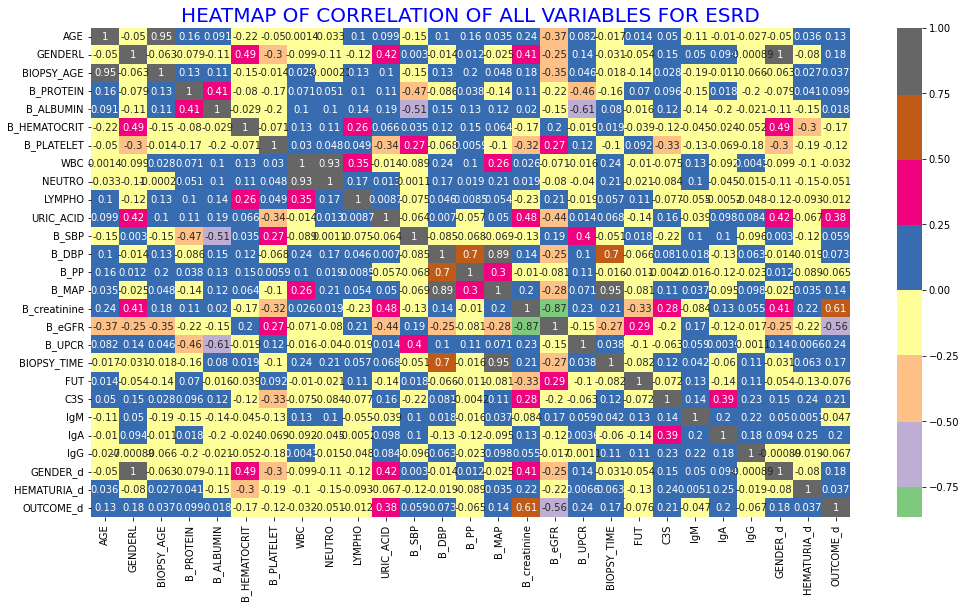

In [236]:
#plotting the correlation of all variables in esrd data
plt.figure(figsize = (17,9))
sns.heatmap(OUTCOME.corr(), annot = True, center = 0, cmap = 'Accent')
plt.title('HEATMAP OF CORRELATION OF ALL VARIABLES FOR ESRD', color='b', size=20.0)


THIS CORRELATION HEATMAP SHOWS THAT THERE IS A POSITIVE CORRELATION BETWEEN BASELINE CREATININE AND ESRD AND ALSO URIC ACID, THUS IT MEANS THAT THE HIGHER THE CREATININE AND URIC ACID, THE MORE LIKELY IT IS FOR ESRD WHILE THE HIGHER THE EGFR (NEGATIVE CORRELATION), THE LESS LIKELY FOR ONE TO DEVELOP ESRD. OTHER PARAMETERS OF NOTE HERE ARE C3STAIN, IgA AND UPCR WITH SLIGHT POSITIVE CORRELATION.

Text(0.5, 1.0, 'HEATMAP OF CORRELATION OF ALL VARIABLES FOR ESRD')

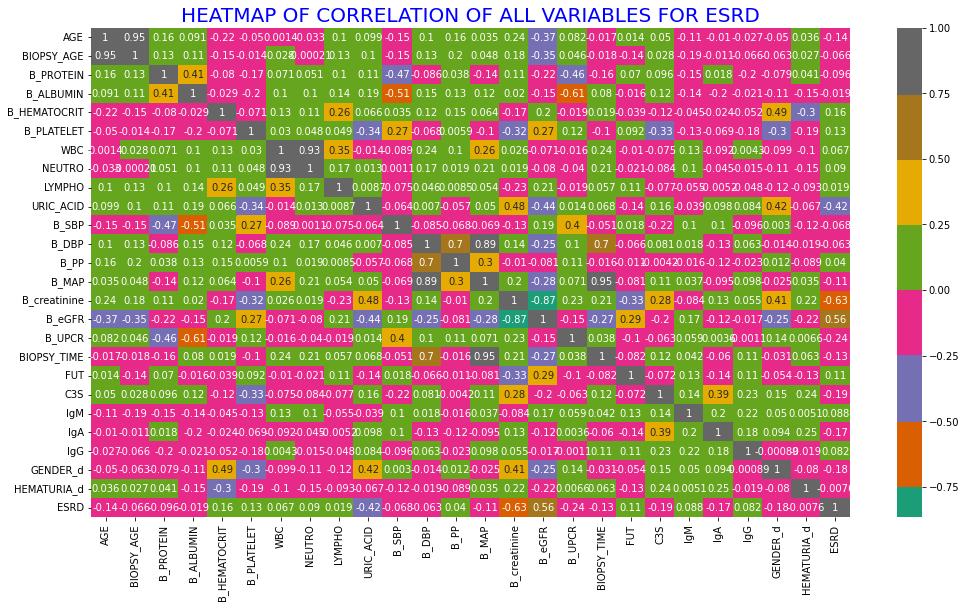

In [237]:
#plotting the correlation of all variables 
plt.figure(figsize = (17,9))
sns.heatmap(ESRD.corr(), annot = True, center = 0, cmap = 'Dark2')
plt.title('HEATMAP OF CORRELATION OF ALL VARIABLES FOR ESRD', color='b', size=20.0)


THIS HEATMAP SHOW EVEN A STRONGER CORRELATION BETWEEN URIC ACID & CREATININE TO PROGRESSION OF ESRD. THE HIGHER THE BOTH VALUES, THE MORE LIKELY WE HAVE AN ESRD


Text(0.5, 1.0, 'HEATMAP OF CORRELATION OF ALL VARIABLES FOR 50% PROGRESSION')

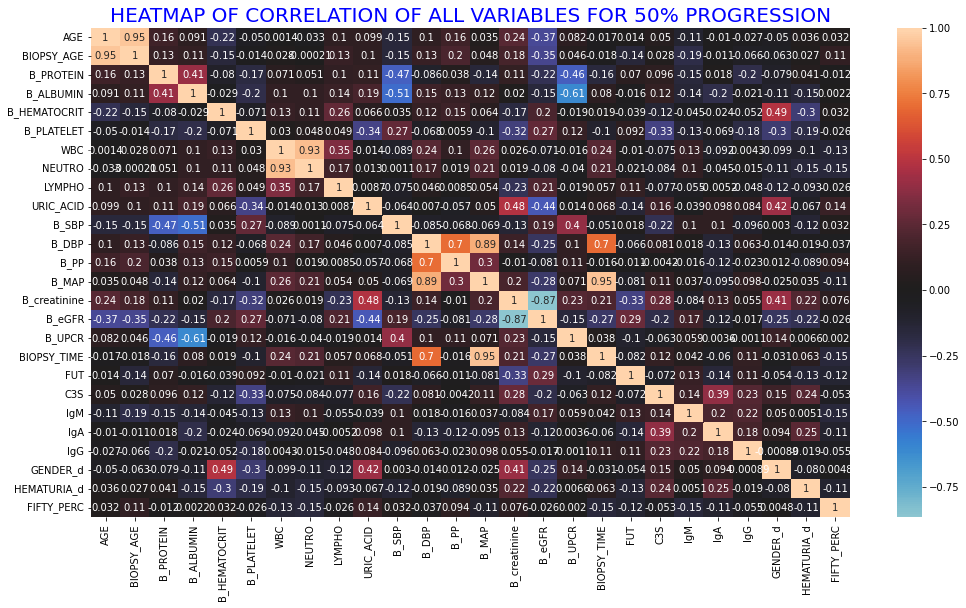

In [238]:
#plotting the correlation of all variables 
plt.figure(figsize = (17,9))
sns.heatmap(FIFTY_PERC.corr(), annot = True, center = 0)
plt.title('HEATMAP OF CORRELATION OF ALL VARIABLES FOR 50% PROGRESSION', color='b', size=20.0)

THERE IS NO SIGNIFICANT RELATIONSHIP BETWEEN HE VARIABLES AND 50 PERCENT PROGRESSION

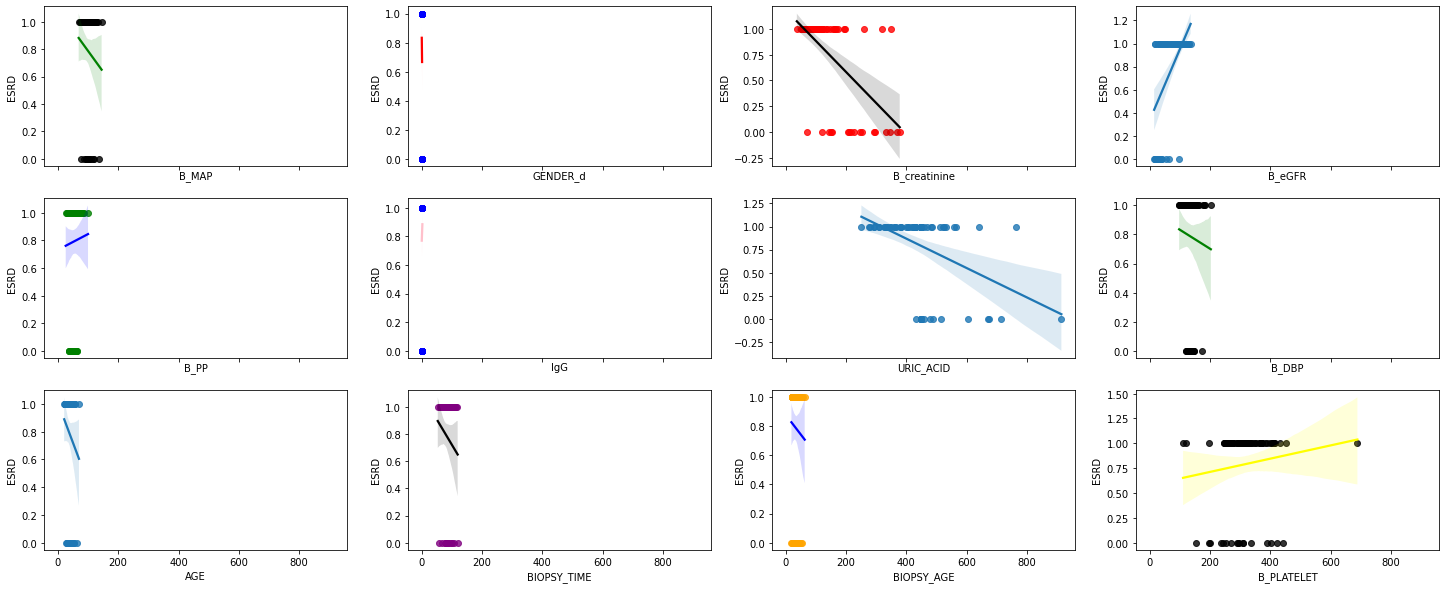

In [239]:
#This is  regression plot FOR ESRD PREDICTION
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(25,10), sharex=True)

sns.regplot(data = ESRD,  x = 'B_MAP', y = 'ESRD', ax=axs[0,0],
           scatter_kws={"color": "black"}, line_kws={"color": "green"})
            
sns.regplot(data = ESRD, x = 'GENDER_d', y = 'ESRD', ax=axs[0,1],
           scatter_kws={"color": "blue"}, line_kws={"color": "red"})
sns.regplot(data = ESRD, x = 'B_creatinine', y = 'ESRD', ax=axs[0,2],
           scatter_kws={"color": "red"}, line_kws={"color": "black"})
sns.regplot(data = ESRD, x = 'B_eGFR', y = 'ESRD', ax=axs[0,3])

sns.regplot(data = ESRD, x = 'AGE', y = 'ESRD', ax=axs[2,0])
sns.regplot(data = ESRD, x = 'BIOPSY_TIME', y = 'ESRD', ax=axs[2,1],
           scatter_kws={"color": "purple"}, line_kws={"color": "black"})
sns.regplot(data = ESRD, x = 'BIOPSY_AGE', y = 'ESRD', ax=axs[2,2],
           scatter_kws={"color": "orange"}, line_kws={"color": "blue"})
sns.regplot(data = ESRD, x = 'B_PLATELET', y = 'ESRD', ax=axs[2,3],
           scatter_kws={"color": "black"}, line_kws={"color": "yellow"})

sns.regplot(data = ESRD, x = 'B_PP', y = 'ESRD',ax=axs[1,0],
           scatter_kws={"color": "green"}, line_kws={"color": "blue"})
sns.regplot(data = ESRD, x = 'URIC_ACID', y = 'ESRD', ax=axs[1,2])
sns.regplot(data = ESRD, x = 'IgG', y = 'ESRD', ax=axs[1,1],
           scatter_kws={"color": "blue"}, line_kws={"color": "pink"})
sns.regplot(data = ESRD, x = 'B_DBP', y = 'ESRD', ax=axs[1,3],
           scatter_kws={"color": "black"}, line_kws={"color": "green"})

HERE, WE SEE THE STRONG CORRELATION BETWEEN URID ACID AND CREATININE WITH ESRD WHILE PLATELET HAVE AN OPPOSITE RELATIONSHIP (ESRD IS 0, WHILE NO PROGRESSION AND 50 PERCENT PROGRSSION IS 1 IN THE DUMMY DATA 'ESRD').



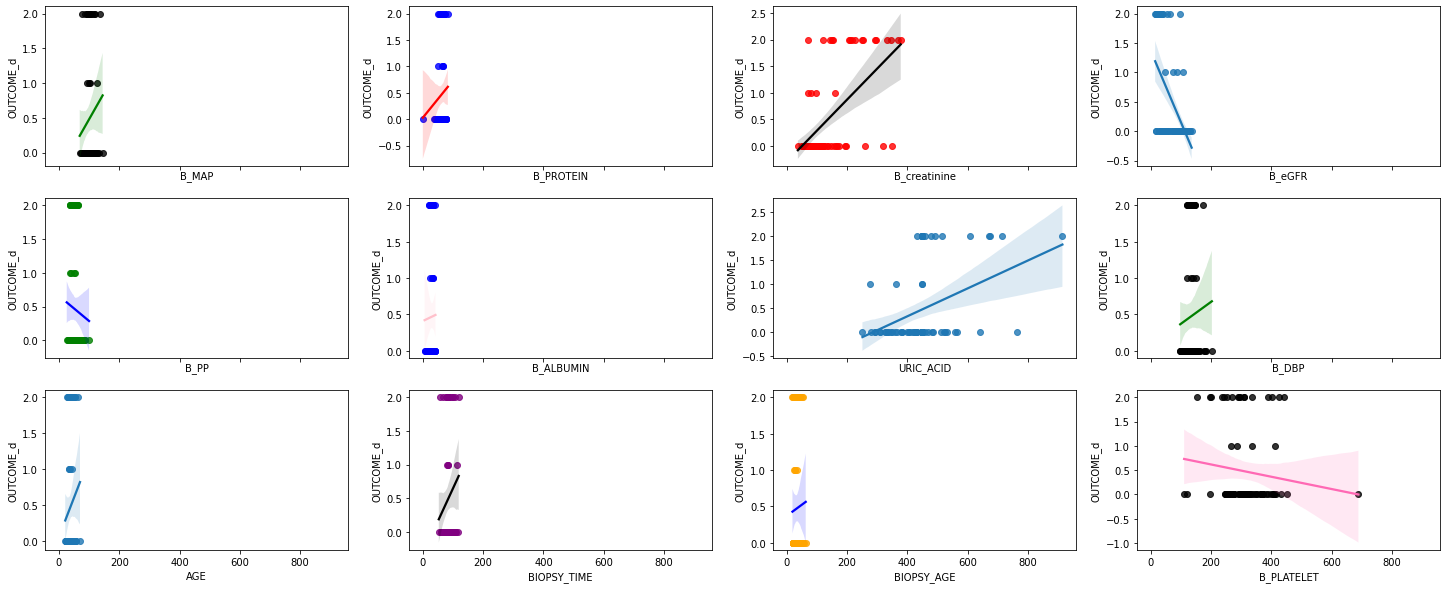

In [240]:
#This is  regression plot FOR ESRD PREDICTION
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(25,10), sharex=True)

sns.regplot(data = OUTCOME,  x = 'B_MAP', y = 'OUTCOME_d', ax=axs[0,0],
           scatter_kws={"color": "black"}, line_kws={"color": "green"})     
sns.regplot(data = OUTCOME, x = 'B_PROTEIN', y = 'OUTCOME_d', ax=axs[0,1],
           scatter_kws={"color": "blue"}, line_kws={"color": "red"})
sns.regplot(data = OUTCOME, x = 'B_creatinine', y = 'OUTCOME_d', ax=axs[0,2],
           scatter_kws={"color": "red"}, line_kws={"color": "black"})
sns.regplot(data = OUTCOME, x = 'B_eGFR', y = 'OUTCOME_d', ax=axs[0,3])

sns.regplot(data = OUTCOME, x = 'AGE', y = 'OUTCOME_d', ax=axs[2,0])
sns.regplot(data = OUTCOME, x = 'BIOPSY_TIME', y = 'OUTCOME_d', ax=axs[2,1],
           scatter_kws={"color": "purple"}, line_kws={"color": "black"})
sns.regplot(data = OUTCOME, x = 'BIOPSY_AGE', y = 'OUTCOME_d', ax=axs[2,2],
           scatter_kws={"color": "orange"}, line_kws={"color": "blue"})
sns.regplot(data = OUTCOME, x = 'B_PLATELET', y = 'OUTCOME_d', ax=axs[2,3],
           scatter_kws={"color": "black"}, line_kws={"color": "hotpink"})

sns.regplot(data = OUTCOME, x = 'B_PP', y = 'OUTCOME_d',ax=axs[1,0],
           scatter_kws={"color": "green"}, line_kws={"color": "blue"})
sns.regplot(data = OUTCOME, x = 'URIC_ACID', y = 'OUTCOME_d', ax=axs[1,2])
sns.regplot(data = OUTCOME, x = 'B_ALBUMIN', y = 'OUTCOME_d', ax=axs[1,1],
           scatter_kws={"color": "blue"}, line_kws={"color": "pink"})
sns.regplot(data = OUTCOME, x = 'B_DBP', y = 'OUTCOME_d', ax=axs[1,3],
           scatter_kws={"color": "black"}, line_kws={"color": "green"})

THE URIC ACID AND CREATININE ARE TOWARDS 2.0 (WHICH IS OUR ESRD, 1 IS 50 PERCENT PROGRESSION WHILE 0 IS NO PROGRESSION IN THE DUMMY VARIABLE "OUTCOME_d") IS STRONGLY CORRELATED WITH ESRD WHILE PLATELET SHOWS AN OPPOSITE RELATIONSHIP

Text(0.5, 1.0, 'regression plot of outcome with uric acid')

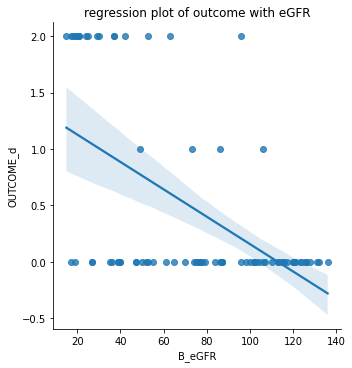

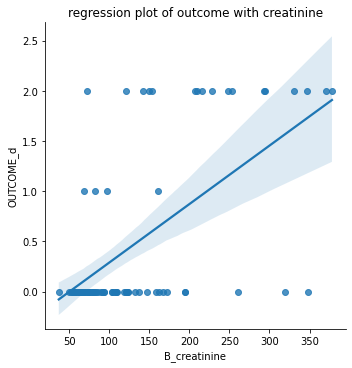

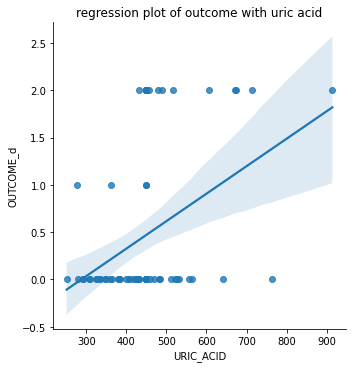

In [241]:

sns.lmplot(data = OUTCOME, x = 'B_eGFR', y = 'OUTCOME_d')
plt.title('regression plot of outcome with eGFR')

sns.lmplot(data = OUTCOME, x = 'B_creatinine', y = 'OUTCOME_d')
plt.title('regression plot of outcome with creatinine')

sns.lmplot(data = OUTCOME, x = 'URIC_ACID', y = 'OUTCOME_d')
plt.title('regression plot of outcome with uric acid')


THIS REGRESSION PLOT SHOWS THAT THE HIGHER THE CREATININE, THE HIGHER THE RISK OF ESRD SO ALSO URIC ACID, WHICH AGREES WITH THE CORRELATION HEATMAP WHILE THE HIGHER THE eGFR, THE LESS LIKELY IT IS FOR ONE TO DEVELOP ESRD

Text(0.5, 1.0, 'regression plot of outcome with platelet and IgA')

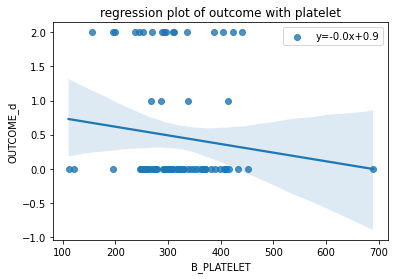

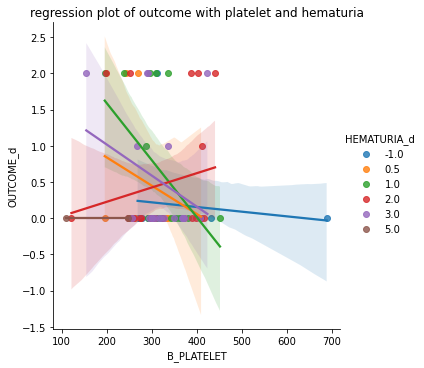

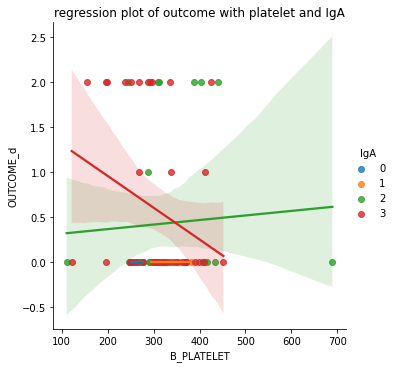

In [242]:
slope, intercept, r_value, pv, se = stats.linregress(OUTCOME['B_PLATELET'],OUTCOME['OUTCOME_d'])
sns.regplot( x = 'B_PLATELET', y = 'OUTCOME_d', data = OUTCOME, ci= 95, label="y={0:.1f}x+{1:.1f}".format(slope, intercept)).legend(loc="best")
plt.title('regression plot of outcome with platelet')

sns.lmplot(x = 'B_PLATELET', y = 'OUTCOME_d', data = OUTCOME, hue = 'HEMATURIA_d')
plt.title('regression plot of outcome with platelet and hematuria')

sns.lmplot(x = 'B_PLATELET', y = 'OUTCOME_d', data = OUTCOME, hue = 'IgA')
plt.title('regression plot of outcome with platelet and IgA')

THE MORE THE PLATELET, THE LESS LIKELY ONE CAN DEVELOP ESRD WITH SLOPE AT y = 0.00x + 0.9.  HEMATURIA 1+ HAS INCREASED PROTECTIVE EFFECT WITH PLATELET, SO ALSO PLATELET WITH IgA +++

Text(0.5, 1.0, 'regression plot of outcome with eGFR and IgG')

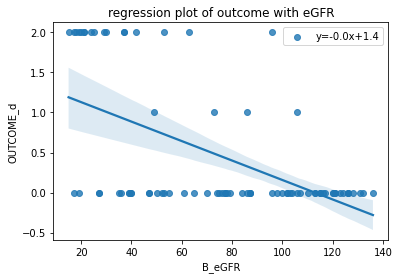

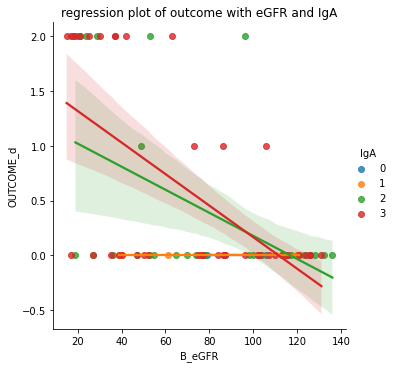

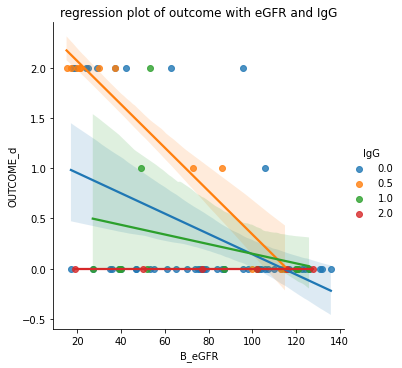

In [243]:

slope, intercept, r_value, pv, se = stats.linregress(OUTCOME['B_eGFR'],OUTCOME['OUTCOME_d'])
sns.regplot( x = 'B_eGFR', y = 'OUTCOME_d', data = OUTCOME, label="y={0:.1f}x+{1:.1f}".format(slope, intercept)).legend(loc="best")
plt.title('regression plot of outcome with eGFR')

sns.lmplot(x = 'B_eGFR', y = 'OUTCOME_d', data = OUTCOME, hue = 'IgA')
plt.title('regression plot of outcome with eGFR and IgA')

sns.lmplot(x = 'B_eGFR', y = 'OUTCOME_d', data = OUTCOME, hue = 'IgG')
plt.title('regression plot of outcome with eGFR and IgG')

THIS REGRESSION PLOT SHOWS THAT THE HIGHER THE eGFR, THE LESS LIKELY TO DEVELOP ESRD WITH SLOPE AT y = 0.00x + 1.4. WE CAN ALSO SEE THAT WITH LESS EGFR AND IgG TRACE (0.5), THERE IS HIGH RISK OF ESRD. IgA HAS NO ASSOCIATION WITH ESRD

Text(0.5, 1.0, 'regression plot of outcome with uric acid and hematuria')

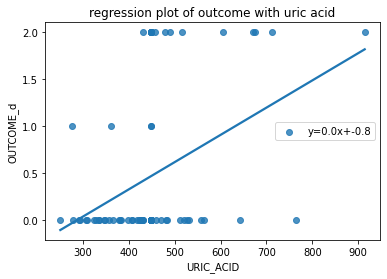

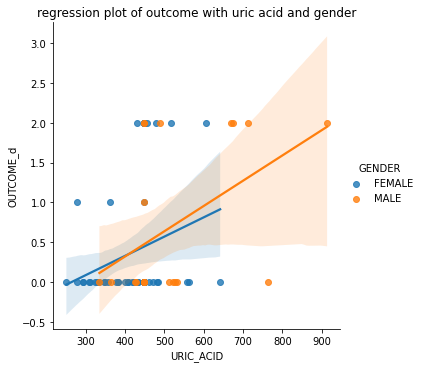

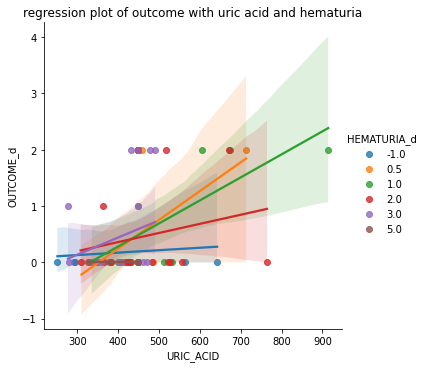

In [244]:
slope, intercept, r_value, pv, se = stats.linregress(OUTCOME['URIC_ACID'],OUTCOME['OUTCOME_d'])
sns.regplot( x = 'URIC_ACID', y = 'OUTCOME_d', data = OUTCOME, ci= None, label="y={0:.1f}x+{1:.1f}".format(slope, intercept)).legend(loc="best")
plt.title('regression plot of outcome with uric acid')

sns.lmplot(data = OUTCOME, x = 'URIC_ACID', y = 'OUTCOME_d', hue = 'GENDER')
plt.title('regression plot of outcome with uric acid and gender')

sns.lmplot(data = OUTCOME, x = 'URIC_ACID', y = 'OUTCOME_d', hue = 'HEMATURIA_d')
plt.title('regression plot of outcome with uric acid and hematuria')

THIS SHOWS THAT MALES WITH HIGHER URIC ACID HAVE HIGHER RISK OF ESRD BASED ON THIS PLOT. A TARCE OF HEMATURIA (O.5) AND 1+, CAME DOWN WITH ESRD

Text(0.5, 1.0, 'regression plot of outcome with uric acid and IgG')

<Figure size 720x432 with 0 Axes>

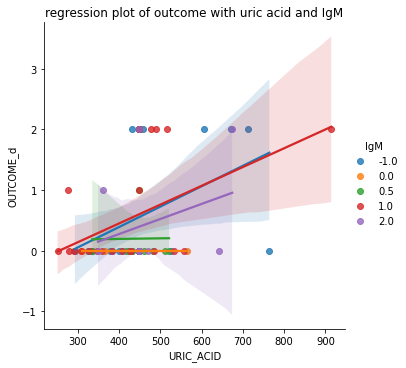

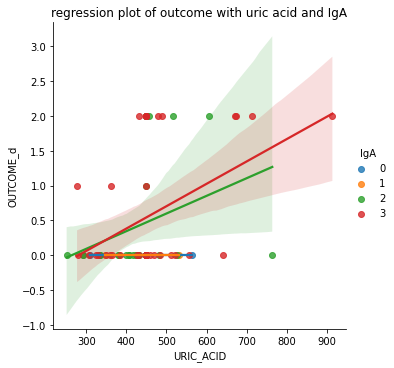

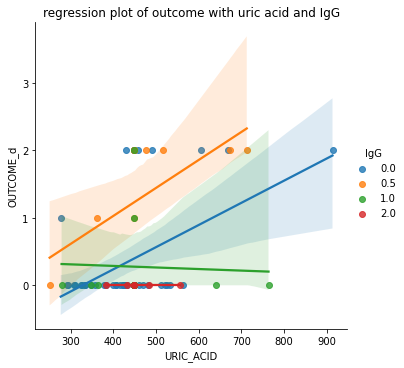

In [245]:
plt.figure(figsize = (10,6))

sns.lmplot(data = OUTCOME, x = 'URIC_ACID', y = 'OUTCOME_d', hue = 'IgM')
plt.title('regression plot of outcome with uric acid and IgM')

sns.lmplot(data = OUTCOME, x = 'URIC_ACID', y = 'OUTCOME_d', hue = 'IgA')
plt.title('regression plot of outcome with uric acid and IgA')

sns.lmplot(data = OUTCOME, x = 'URIC_ACID', y = 'OUTCOME_d', hue = 'IgG')
plt.title('regression plot of outcome with uric acid and IgG')

IgM (NEGATIVE) AND 2+, URIC ACID, IgA 3+ AND IgG (NEGATIVE & TRACE) HAVE A STRONG CORRELATION WITH DEVELOPMENT OF ESRD WHILE IgM 1+ SHOWED STRONG CORRELATION WITH NO DISEASE PROGRESSION AS WELL AS 2+ TOO  

Text(0.5, 1.0, 'regression plot of outcome with creatinine and c3stain')

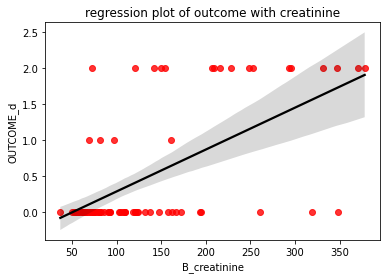

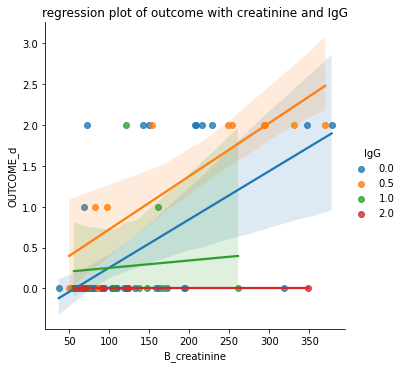

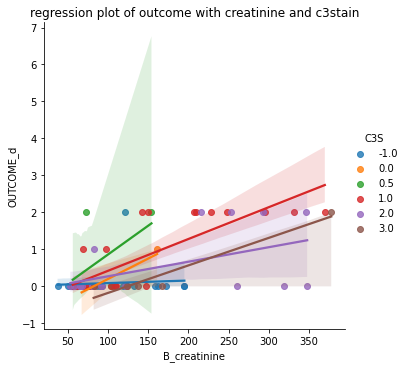

In [246]:
sns.regplot(data = OUTCOME, x = 'B_creatinine', y = 'OUTCOME_d',
           scatter_kws={"color": "red"}, line_kws={"color": "black"})
plt.title('regression plot of outcome with creatinine')

sns.lmplot(data = OUTCOME, x = 'B_creatinine', y = 'OUTCOME_d', hue = 'IgG')
plt.title('regression plot of outcome with creatinine and IgG')

sns.lmplot(data = OUTCOME, x = 'B_creatinine', y = 'OUTCOME_d', hue = 'C3S' )
plt.title('regression plot of outcome with creatinine and c3stain')

THE HIGHER THE CREATININNE, THE MORE LIKELY IT IS TO COME DOWN WITH ESRD. IgG (NONE & TRACE) HAVE AN INCREASED RISK WITH HIGHER CREATININE WHILE IgG 2+ HAVE A VERY STRONG RELATIONSHIP WITH EVEN A HIGH LEVEL OF CREATININE IN BEING PROTECTIVE.
C3STAIN HAVE A STRONG REALTIONSHIP WTH CRAETININE IN DEVELOPMENT OF ESRD WHILE A NEGATIVE C3STAIN IS ASSOCIATED WITH NO DISEASE PROGRESSION IRRESPECTIVE OF THE CREATININE VALUE.


Text(0.5, 1.0, 'regression plot of outcome with creatinine and hematuria')

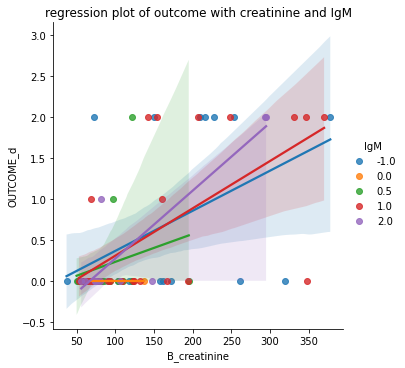

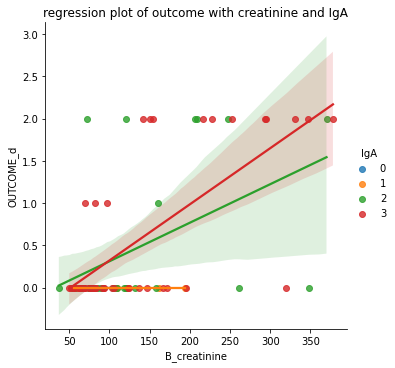

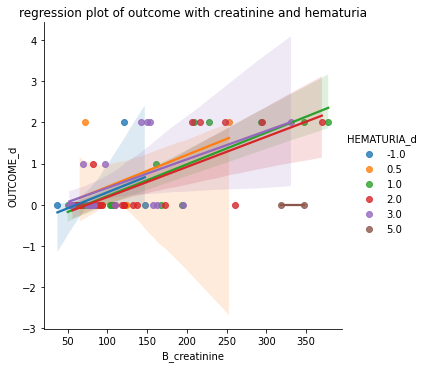

In [247]:
sns.lmplot(data = OUTCOME, x = 'B_creatinine', y = 'OUTCOME_d', hue = 'IgM')
plt.title('regression plot of outcome with creatinine and IgM')

sns.lmplot(data = OUTCOME, x = 'B_creatinine', y = 'OUTCOME_d', hue = 'IgA')
plt.title('regression plot of outcome with creatinine and IgA')

sns.lmplot(data = OUTCOME, x = 'B_creatinine', y = 'OUTCOME_d', hue = 'HEMATURIA_d')
plt.title('regression plot of outcome with creatinine and hematuria')


HEMATURIA, IgG AND IgA HAVE A STRONG CORRELATION WITH CREATININE IN DEVELOPMENT OF ESRD SO LONG AS THERE AT LEAST 1+ BUT NEGATIVE STAIN OF IgG ALSO HAVE A STRONG CORRELATION WITH HIGHER CREATININE.

Text(0.5, 1.0, 'regression plot of outcome with uric acid an c3stain')

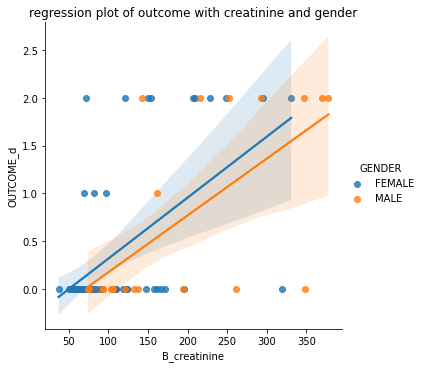

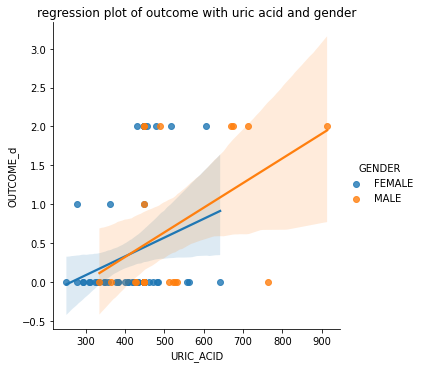

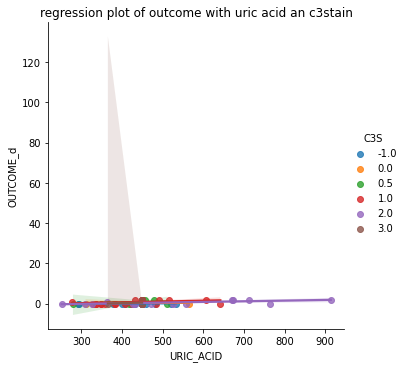

In [248]:
sns.lmplot(data = OUTCOME, x = 'B_creatinine', y = 'OUTCOME_d', hue = 'GENDER')
plt.title('regression plot of outcome with creatinine and gender')

sns.lmplot(data = OUTCOME, x = 'URIC_ACID', y = 'OUTCOME_d', hue = 'GENDER')
plt.title('regression plot of outcome with uric acid and gender')

sns.lmplot(data = OUTCOME, x = 'URIC_ACID', y = 'OUTCOME_d', hue = 'C3S')
plt.title('regression plot of outcome with uric acid an c3stain')

WITH HIGHER CREATININE BOTH GENDER ARE NOT SPARED FROM ESRD WHILE WITH HIGHER URIC ACID, ESRD WAS FOUND IN MALES WHILE C3STAIN HAS IS ASSOCIATED WITH NO DISEASE PROGRESSION

Text(0, 0.5, 'OUTCOME')

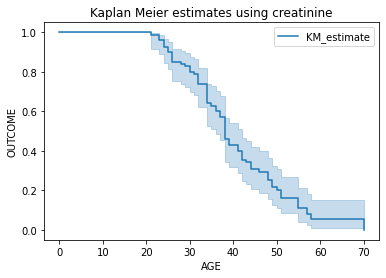

In [249]:
kmf = KaplanMeierFitter()
X = ESRD['AGE']
Y = ESRD['ESRD']
kmf.fit(X, event_observed = Y)
kmf.plot()
plt.title("Kaplan Meier estimates using creatinine")
plt.xlabel("AGE")
plt.ylabel("OUTCOME")

Text(0, 0.5, 'Survival')

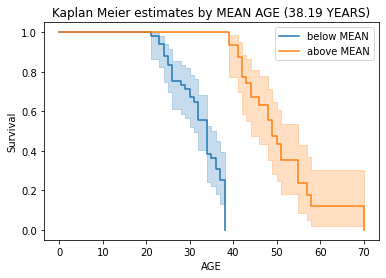

In [250]:

#kmf.survival_function_
biopsy = ESRD['AGE'] < np.mean(ESRD['AGE'])
ax = plt.subplot(111)
kmf.fit(X[biopsy], event_observed = Y[biopsy], label = 'below MEAN')
kmf.plot(ax = ax)
kmf.fit(X[~biopsy], event_observed = Y[~biopsy], label = 'above MEAN')
kmf.plot(ax = ax)
plt.title("Kaplan Meier estimates by MEAN AGE (38.19 YEARS)")
plt.xlabel("AGE")
plt.ylabel("Survival")

Text(0, 0.5, 'OUTCOME')

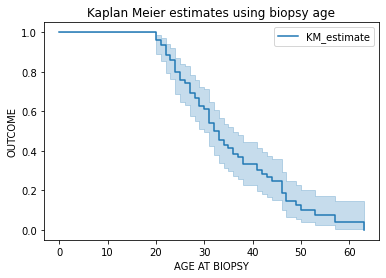

In [251]:
kmf = KaplanMeierFitter()
X = ESRD['BIOPSY_AGE']
Y = ESRD['ESRD']
kmf.fit(X, event_observed = Y)
kmf.plot()
plt.title("Kaplan Meier estimates using biopsy age")
plt.xlabel("AGE AT BIOPSY")
plt.ylabel("OUTCOME")

Text(0, 0.5, 'Survival')

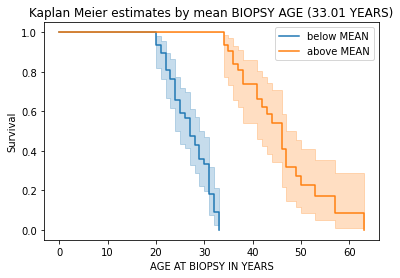

In [252]:
kmf.survival_function_
age_group = OUTCOME['BIOPSY_AGE'] < np.mean(OUTCOME['BIOPSY_AGE'])
ax = plt.subplot(111)
kmf.fit(X[age_group], event_observed = Y[age_group], label = 'below MEAN')
kmf.plot(ax = ax)
kmf.fit(X[~age_group], event_observed = Y[~age_group], label = 'above MEAN')
kmf.plot(ax = ax)
plt.title("Kaplan Meier estimates by mean BIOPSY AGE (33.01 YEARS)")
plt.xlabel("AGE AT BIOPSY IN YEARS")
plt.ylabel("Survival")


Text(0, 0.5, 'OUTCOME')

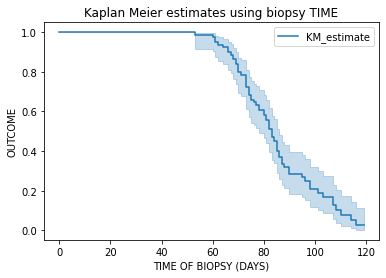

In [253]:
kmf = KaplanMeierFitter()
X = ESRD['BIOPSY_TIME']
Y = ESRD['ESRD']
kmf.fit(X, event_observed = Y)
kmf.plot()
plt.title("Kaplan Meier estimates using biopsy TIME")
plt.xlabel("TIME OF BIOPSY (DAYS)")
plt.ylabel("OUTCOME")

Text(0, 0.5, 'Survival')

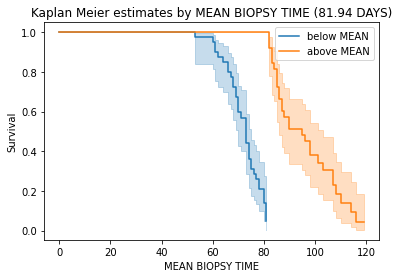

In [254]:
kmf.survival_function_
biopsy = ESRD['BIOPSY_TIME'] < np.mean(ESRD['BIOPSY_TIME'])
ax = plt.subplot(111)
kmf.fit(X[biopsy], event_observed = Y[biopsy], label = 'below MEAN')
kmf.plot(ax = ax)
kmf.fit(X[~biopsy], event_observed = Y[~biopsy], label = 'above MEAN')
kmf.plot(ax = ax)
plt.title("Kaplan Meier estimates by MEAN BIOPSY TIME (81.94 DAYS)")
plt.xlabel("MEAN BIOPSY TIME")
plt.ylabel("Survival")

Text(0, 0.5, 'OUTCOME')

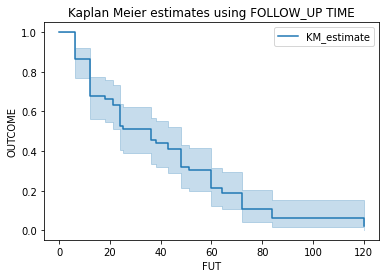

In [255]:
kmf = KaplanMeierFitter()
X = ESRD['FUT']
Y = ESRD['ESRD']
kmf.fit(X, event_observed = Y)
kmf.plot()
plt.title("Kaplan Meier estimates using FOLLOW_UP TIME")
plt.xlabel("FUT")
plt.ylabel("OUTCOME")

Text(0, 0.5, 'Survival')

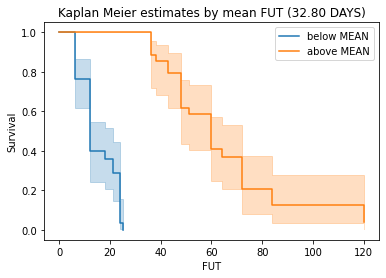

In [256]:
kmf.survival_function_
biopsy = ESRD['FUT'] < np.mean(ESRD['FUT'])
ax = plt.subplot(111)
kmf.fit(X[biopsy], event_observed = Y[biopsy], label = 'below MEAN')
kmf.plot(ax = ax)
kmf.fit(X[~biopsy], event_observed = Y[~biopsy], label = 'above MEAN')
kmf.plot(ax = ax)
plt.title("Kaplan Meier estimates by mean FUT (32.80 DAYS)")
plt.xlabel("FUT")
plt.ylabel("Survival")

Text(0.5, 1.0, 'Survival Function based on CREATININE')

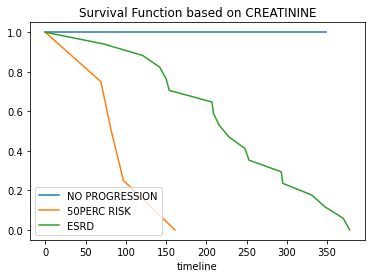

In [257]:

# Define the 3 OUTCOMES
High = (df1.OUTCOME_d == 2) 

Med  = (df1.OUTCOME_d == 1)
 
Low = (df1.OUTCOME_d == 0) 
 
# Plot the survival function
ax = plt.subplot()
 
kmf = KaplanMeierFitter()
kmf.fit(durations=df1[Low].B_creatinine,
event_observed=df1[Low].OUTCOME_d, label='NO PROGRESSION')
kmf.survival_function_.plot(ax=ax)

kmf.fit(durations=df1[Med].B_creatinine, event_observed=df1[Med].OUTCOME_d, label='50PERC RISK')
kmf.survival_function_.plot(ax=ax)
 
kmf.fit(durations=df1[High].B_creatinine, event_observed=df1[High].OUTCOME_d, label='ESRD')
kmf.survival_function_.plot(ax=ax)
 
plt.title('Survival Function based on CREATININE')

HERE, THERE IS A HIGHER CHANCE OF COMING DOWN WITH 50 PERCENT PROGRESSION THAN DEVELOPING THE FULL ESRD. WHILE 50 PERCENT PROGRESSION SHOWS VALUE AT 150 TO BE ABOUT 8% SURVIVAL, THE ESRD AT SAME VALUE OF 150 SHOWS ABOUT 75% SURVIVAL.





In [258]:
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print("median value = ", median_)
print("median CI @50% :",median_confidence_interval_)

median value =  228.0
median CI @50% :      ESRD_lower_0.95  ESRD_upper_0.95
0.5            150.0            295.0


Text(0.5, 1.0, 'Survival Function based on eGFR')

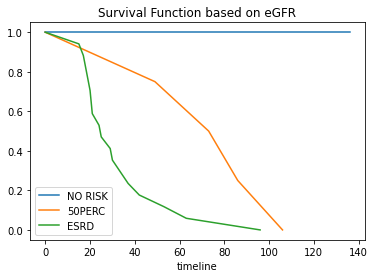

In [259]:
# Define the 3 OUTCOMES
High = (df1.OUTCOME_d == 2) 

Med  = (df1.OUTCOME_d == 1)
 
Low = (df1.OUTCOME_d == 0) 
 
# Plot the survival function
ax = plt.subplot()

kmf = KaplanMeierFitter()
kmf.fit(durations=df1[Low].B_eGFR,
event_observed=df1[Low].OUTCOME_d, label='NO RISK')
kmf.survival_function_.plot(ax=ax)

kmf.fit(durations=df1[Med].B_eGFR, event_observed=df1[Med].OUTCOME_d, label='50PERC')
kmf.survival_function_.plot(ax=ax)
 
kmf.fit(durations=df1[High].B_eGFR, event_observed=df1[High].OUTCOME_d, label='ESRD')
kmf.survival_function_.plot(ax=ax)
 
plt.title('Survival Function based on eGFR')

WITH EGFR AT 40, THERE IS 20% CHANCE OF ESRD SURVIVAL WHILE 50 PERCENT PROGRESSION AT SAME VALUE OF 40 IS ABOUT 4 TIMES OF ESRD SURVIVAL AT 80%. THUS, ITS LONGER THAN 4 TIMES OF 50 PERCENT DISEASE PROGRESSION TO MANIFEST AS FULL DISEASE ENTITY.

In [260]:
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print("median value = ", median_)
print("median CI @50% :",median_confidence_interval_)

median value =  25.0
median CI @50% :      ESRD_lower_0.95  ESRD_upper_0.95
0.5             19.0             37.0


Text(0.5, 1.0, 'Survival Function based on age')

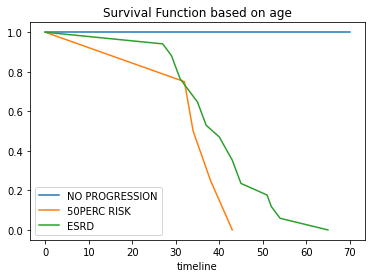

In [261]:
# Define the 3 OUTCOMES
High = (df1.OUTCOME_d == 2) 

Med  = (df1.OUTCOME_d == 1)
 
Low = (df1.OUTCOME_d == 0) 
 
# Plot the survival function
ax = plt.subplot()
 
kmf = KaplanMeierFitter()
kmf.fit(durations=df1[Low].AGE,
event_observed=df1[Low].OUTCOME_d, label='NO PROGRESSION')
kmf.survival_function_.plot(ax=ax)

kmf.fit(durations=df1[Med].AGE, event_observed=df1[Med].OUTCOME_d, label='50PERC RISK')
kmf.survival_function_.plot(ax=ax)
 
kmf.fit(durations=df1[High].AGE, event_observed=df1[High].OUTCOME_d, label='ESRD')
kmf.survival_function_.plot(ax=ax)
 
plt.title('Survival Function based on age')

AT ABOUT 34 YEARS OF AGE, THE SURVIVAL OF ESRD & 50 PERCENT PROGRESSION SEEM TO BE THE SAME AT ABOUT 70% WHILE ALL PATIENTS THAT HAD 50% PROGRESSION AT ABOUT 43 YEARS OF AGE. AND ALL PATIENTS THAT PROGRESSED TO ESRD WILL COME DOWN WITH THE DISEASE ON OR BEFORE AGE 65.

In [262]:
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print("median value = ", median_)
print("median CI @50% :",median_confidence_interval_)

median value =  40.0
median CI @50% :      ESRD_lower_0.95  ESRD_upper_0.95
0.5             31.0             45.0


Text(0.5, 1.0, 'Survival Function based on PLATELET')

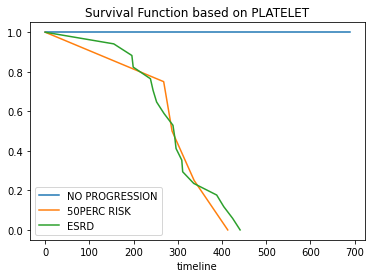

In [263]:
# Define the 3 OUTCOMES
High = (df1.OUTCOME_d == 2) 

Med  = (df1.OUTCOME_d == 1)
 
Low = (df1.OUTCOME_d == 0) 
 
# Plot the survival function
ax = plt.subplot()
 
kmf = KaplanMeierFitter()
kmf.fit(durations=df1[Low].B_PLATELET,
event_observed=df1[Low].OUTCOME_d, label='NO PROGRESSION')
kmf.survival_function_.plot(ax=ax)

kmf.fit(durations=df1[Med].B_PLATELET, event_observed=df1[Med].OUTCOME_d, label='50PERC RISK')
kmf.survival_function_.plot(ax=ax)
 
kmf.fit(durations=df1[High].B_PLATELET, event_observed=df1[High].OUTCOME_d, label='ESRD')
kmf.survival_function_.plot(ax=ax)
 
plt.title('Survival Function based on PLATELET')

HERE, 50 PERCENT PROGRESSION AND ESRD SHOW ALMOST SAME CHANCE OF SURVIVAL AND BEYOND PLATELET OF 420, THE CHNACE OF SURVIVAL IS ESTIMATED TO BE ZERO

In [264]:
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print("median value = ", median_)
print("median CI @50% :",median_confidence_interval_)

median value =  293.0
median CI @50% :      ESRD_lower_0.95  ESRD_upper_0.95
0.5            238.0            336.0


Text(0.5, 1.0, 'Survival Function based on HEMATOCRIT')

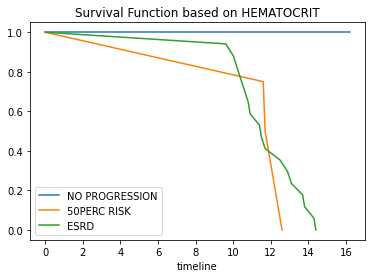

In [265]:

# Define the 3 OUTCOMES
High = (df1.OUTCOME_d == 2) 

Med  = (df1.OUTCOME_d == 1)
 
Low = (df1.OUTCOME_d == 0) 
 
# Plot the survival function
ax = plt.subplot()
 
kmf = KaplanMeierFitter()
kmf.fit(durations=df1[Low].B_HEMATOCRIT,
event_observed=df1[Low].OUTCOME_d, label='NO PROGRESSION')
kmf.survival_function_.plot(ax=ax)

kmf.fit(durations=df1[Med].B_HEMATOCRIT, event_observed=df1[Med].OUTCOME_d, label='50PERC RISK')
kmf.survival_function_.plot(ax=ax)
 
kmf.fit(durations=df1[High].B_HEMATOCRIT, event_observed=df1[High].OUTCOME_d, label='ESRD')
kmf.survival_function_.plot(ax=ax)
 
plt.title('Survival Function based on HEMATOCRIT')

WITH HEMATOCRIT OF 4.2, THERE IS 90% SURVIVAL FOR THOSE WHO HAD 50 PERCENT DISEASE PROGRESSION WHILE HEMATOCRIT FOR SAME SURVIVAL RATE IS ABOUT 11 FOR ESRD

In [266]:
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print("median value = ", median_)
print("median CI @50% :",median_confidence_interval_)

median value =  11.5
median CI @50% :      ESRD_lower_0.95  ESRD_upper_0.95
0.5             10.6             13.1


Text(0.5, 1.0, 'Survival Function based on HEMATURIA')

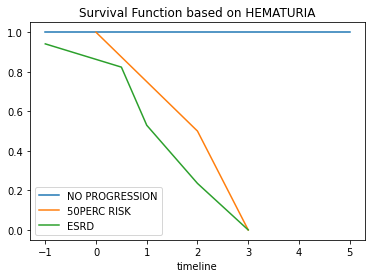

In [267]:

# Define the 3 OUTCOMES
High = (df1.OUTCOME_d == 2) 

Med  = (df1.OUTCOME_d == 1)
 
Low = (df1.OUTCOME_d == 0) 
 
# Plot the survival function
ax = plt.subplot()
 
kmf = KaplanMeierFitter()
kmf.fit(durations=df1[Low].HEMATURIA_d,
event_observed=df1[Low].OUTCOME_d, label='NO PROGRESSION')
kmf.survival_function_.plot(ax=ax)

kmf.fit(durations=df1[Med].HEMATURIA_d, event_observed=df1[Med].OUTCOME_d, label='50PERC RISK')
kmf.survival_function_.plot(ax=ax)
 
kmf.fit(durations=df1[High].HEMATURIA_d, event_observed=df1[High].OUTCOME_d, label='ESRD')
kmf.survival_function_.plot(ax=ax)
 
plt.title('Survival Function based on HEMATURIA')

THERE IS A HIGHER CHANCE OF ESRD WITH HEMATURIA AT ANY VALUE THAN GHAVING 50 PERCENT OF PROGRESSION WHILE AT HEMATURIA OF 3+++ OR MORE, THERE IS NO EVIDENCE OF SURVIVAL FOR BOTH GROUPS EXCEPT THOSE WHO DID NOT PROGRESS.

In [268]:
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print("median value = ", median_)
print("median CI @50% :",median_confidence_interval_)

median value =  2.0
median CI @50% :      ESRD_lower_0.95  ESRD_upper_0.95
0.5              1.0              2.0


Text(0.5, 1.0, 'Survival Function based on URIC ACID')

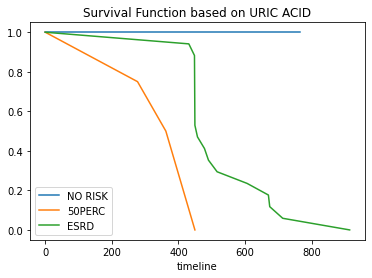

In [269]:
# Define the 3 OUTCOMES
High = (df1.OUTCOME_d == 2) 

Med  = (df1.OUTCOME_d == 1)
 
Low = (df1.OUTCOME_d == 0) 
 
# Plot the survival function
ax = plt.subplot()

kmf = KaplanMeierFitter()
kmf.fit(durations=df1[Low].URIC_ACID,
event_observed=df1[Low].OUTCOME_d, label='NO RISK')
kmf.survival_function_.plot(ax=ax)

kmf.fit(durations=df1[Med].URIC_ACID, event_observed=df1[Med].OUTCOME_d, label='50PERC')
kmf.survival_function_.plot(ax=ax)
 
kmf.fit(durations=df1[High].URIC_ACID, event_observed=df1[High].OUTCOME_d, label='ESRD')
kmf.survival_function_.plot(ax=ax)
 
plt.title('Survival Function based on URIC ACID')

THE RISK OF DEVELOPING ESRD IS MINIMAL AT VALUES BELOW URIC ACID OF 450Mmol/L BUT GREATER THA THIS VALUE, THE RISK IS DOWN TO 50% AND EVEN FURTHER BELOW 50% AT GREATER VALUES REACHING TO 0% AT ABOUT VALUE OF 700

In [270]:
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print("median value = ", median_)
print("median CI @50% :",median_confidence_interval_)

median value =  457.0
median CI @50% :      ESRD_lower_0.95  ESRD_upper_0.95
0.5       449.269231            606.0


Text(0.5, 1.0, 'Survival Function based on BIOPSY TIME')

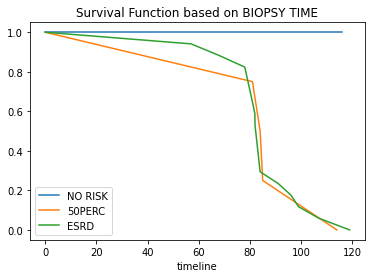

In [271]:
# Define the 3 OUTCOMES
High = (df1.OUTCOME_d == 2) 

Med  = (df1.OUTCOME_d == 1)
 
Low = (df1.OUTCOME_d == 0) 
 
# Plot the survival function
ax = plt.subplot()

kmf = KaplanMeierFitter()
kmf.fit(durations=df1[Low].BIOPSY_TIME,
event_observed=df1[Low].OUTCOME_d, label='NO RISK')
kmf.survival_function_.plot(ax=ax)

kmf.fit(durations=df1[Med].BIOPSY_TIME, event_observed=df1[Med].OUTCOME_d, label='50PERC')
kmf.survival_function_.plot(ax=ax)
 
kmf.fit(durations=df1[High].BIOPSY_TIME, event_observed=df1[High].OUTCOME_d, label='ESRD')
kmf.survival_function_.plot(ax=ax)
 
plt.title('Survival Function based on BIOPSY TIME')

BASED ON TIME OF BIOPSY, THERE IS SLIGHT STEEP IN DEVELOPING 50% PROGRESSION AND AT ABOUT 80 DAYS OF ONSET TO BIOPSY, THE RISK FOR FIFTY PERCENT PROGRESSION WAS AT ABOUT 75%. 

In [272]:
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print("median value = ", median_)
print("median CI @50% :",median_confidence_interval_)

median value =  83.0
median CI @50% :      ESRD_lower_0.95  ESRD_upper_0.95
0.5             79.0             91.0


Text(0.5, 1.0, 'Survival Function based on IgA')

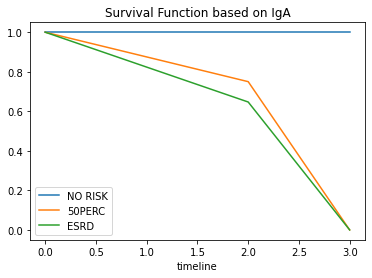

In [273]:
# Define the 3 OUTCOMES
High = (df1.OUTCOME_d == 2) 

Med  = (df1.OUTCOME_d == 1)
 
Low = (df1.OUTCOME_d == 0) 
 
# Plot the survival function
ax = plt.subplot()

kmf = KaplanMeierFitter()
kmf.fit(durations=df1[Low].IgA,
event_observed=df1[Low].OUTCOME_d, label='NO RISK')
kmf.survival_function_.plot(ax=ax)

kmf.fit(durations=df1[Med].IgA, event_observed=df1[Med].OUTCOME_d, label='50PERC')
kmf.survival_function_.plot(ax=ax)
 
kmf.fit(durations=df1[High].IgA, event_observed=df1[High].OUTCOME_d, label='ESRD')
kmf.survival_function_.plot(ax=ax)
 
plt.title('Survival Function based on IgA')

RISK OF DEVELOPMENT OF ESRD AND 50% PROGRESSION IS GREATEST AT IgA +++.

In [274]:
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print("median value = ", median_)
print("median CI @50% :",median_confidence_interval_)

median value =  3.0
median CI @50% :      ESRD_lower_0.95  ESRD_upper_0.95
0.5              2.0              3.0


Text(0.5, 1.0, 'Survival Function based on IgG')

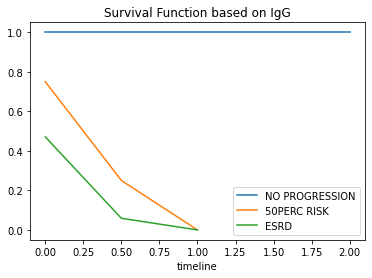

In [275]:
# Define the 3 OUTCOMES
High = (df1.OUTCOME_d == 2) 

Med  = (df1.OUTCOME_d == 1)
 
Low = (df1.OUTCOME_d == 0) 
 
# Plot the survival function
ax = plt.subplot()
 
kmf = KaplanMeierFitter()
kmf.fit(durations=df1[Low].IgG,
event_observed=df1[Low].OUTCOME_d, label='NO PROGRESSION')
kmf.survival_function_.plot(ax=ax)

kmf.fit(durations=df1[Med].IgG, event_observed=df1[Med].OUTCOME_d, label='50PERC RISK')
kmf.survival_function_.plot(ax=ax)
 
kmf.fit(durations=df1[High].IgG, event_observed=df1[High].OUTCOME_d, label='ESRD')
kmf.survival_function_.plot(ax=ax)
 
plt.title('Survival Function based on IgG')

RISK OF ESRD AND 50% PROGRESSION IS GREATEST AT IgG OF 1+

In [276]:
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print("median value = ", median_)
print("median CI @50% :",median_confidence_interval_)

median value =  0.0
median CI @50% :      ESRD_lower_0.95  ESRD_upper_0.95
0.5              0.0              0.5


Text(0.5, 1.0, 'Survival Function based on IgM')

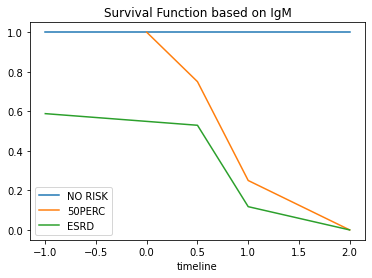

In [277]:
# Define the 3 OUTCOMES
High = (df1.OUTCOME_d == 2) 

Med  = (df1.OUTCOME_d == 1)
 
Low = (df1.OUTCOME_d == 0) 
 
# Plot the survival function
ax = plt.subplot()

kmf = KaplanMeierFitter()
kmf.fit(durations=df1[Low].IgM,
event_observed=df1[Low].OUTCOME_d, label='NO RISK')
kmf.survival_function_.plot(ax=ax)

kmf.fit(durations=df1[Med].IgM, event_observed=df1[Med].OUTCOME_d, label='50PERC')
kmf.survival_function_.plot(ax=ax)
 
kmf.fit(durations=df1[High].IgM, event_observed=df1[High].OUTCOME_d, label='ESRD')
kmf.survival_function_.plot(ax=ax)
 
plt.title('Survival Function based on IgM')

THE GREATEST RISK FOR DEVELOPMENT OF ESRD AND 50% PROGRSSION IS WITH IgM 2+

In [278]:
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print("median value = ", median_)
print("median CI @50% :",median_confidence_interval_)

median value =  1.0
median CI @50% :      ESRD_lower_0.95  ESRD_upper_0.95
0.5             -1.0              1.0


Text(0.5, 1.0, 'Survival Function based on C3STAIN')

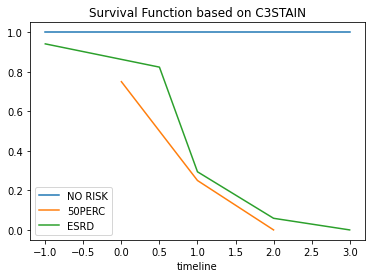

In [279]:
# Define the outcome
High = (df1.OUTCOME_d == 2) 

Med  = (df1.OUTCOME_d == 1)
 
Low = (df1.OUTCOME_d == 0) 
 
# Plot the survival function
ax = plt.subplot()

kmf = KaplanMeierFitter()
kmf.fit(durations=df1[Low].C3S,
event_observed=df1[Low].OUTCOME_d, label='NO RISK')
kmf.survival_function_.plot(ax=ax)

kmf.fit(durations=df1[Med].C3S, event_observed=df1[Med].OUTCOME_d, label='50PERC')
kmf.survival_function_.plot(ax=ax)
 
kmf.fit(durations=df1[High].C3S, event_observed=df1[High].OUTCOME_d, label='ESRD')
kmf.survival_function_.plot(ax=ax)
 
plt.title('Survival Function based on C3STAIN')

THE GREATEST RISK FORR ESRD USING C3STAIN IS 2+ AND ABOVE

In [280]:
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print("median value = ", median_)
print("median CI @50% :",median_confidence_interval_)

median value =  1.0
median CI @50% :      ESRD_lower_0.95  ESRD_upper_0.95
0.5              1.0              2.0


In [281]:
X = np.array(ESRD['URIC_ACID']).reshape(-1, 1)
y = np.array(ESRD['ESRD']).reshape(-1, 1)
  
# Separating the data into independent and dependent variable
ESRD.dropna(inplace = True)
  
# Dropping any rows with Nan values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
  
# Splitting the data into training and testing data
regr = LinearRegression()
  
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


0.2717114782396636

In [282]:
X = np.array(ESRD['URIC_ACID']).reshape(-1, 1)
y = np.array(ESRD['ESRD']).reshape(-1, 1)
  
# Separating the data into independent and dependent variable
ESRD.dropna(inplace = True)
  
# Dropping any rows with Nan values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
  
# Splitting the data into training and testing data
regr = LinearRegression()
  
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


0.17759896038328626

In [283]:

print(y_test.shape, y_train.shape, X_train.shape, X_test.shape)

(25, 1) (56, 1) (56, 1) (25, 1)


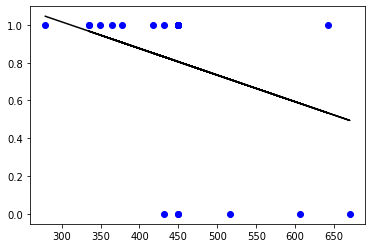

In [284]:
y_pred = regr.predict(X_test)
plt.scatter(X_test, y_test, color ='b')
plt.plot(X_test, y_pred, color ='k')


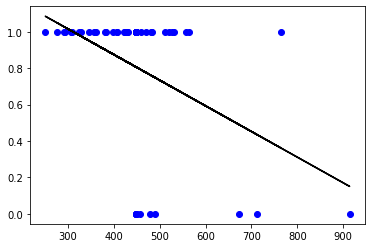

In [285]:
y_pred = regr.predict(X_train)
plt.scatter(X_train, y_train, color ='b')
plt.plot(X_train, y_pred, color ='k')

In [286]:
X = np.array(ESRD['B_eGFR']).reshape(-1, 1)
y = np.array(ESRD['ESRD']).reshape(-1, 1)

ESRD.dropna(inplace = True)
  
# Dropping any rows with Nan values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
  
# Splitting the data into training and testing data
regr = LinearRegression()
  
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


0.40139274923126267

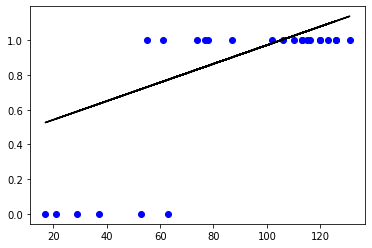

In [287]:
y_pred = regr.predict(X_test)
plt.scatter(X_test, y_test, color ='b')
plt.plot(X_test, y_pred, color ='k')

In [288]:
 
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
#squared True returns MSE value, False returns RMSE value.
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) #default=True
rmse = mean_squared_error(y_true=y_test,y_pred=y_pred,squared=False)
  
print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

MAE: 0.22872056148087264
MSE: 0.1091859625402177
RMSE: 0.3304329925116705


In [289]:

# Creating independent and dependent variables.
X, y = ESRD['B_creatinine'], ESRD['ESRD']
  
# Splitting the data into training set and test set.
X_train, X_test, y_train, y_test = X[:60], X[60:], y[:60], y[60:]
  
"""
The training set is already shuffled for us, which is good as this guarantees that all
cross-validation folds will be similar.
"""
  
# Training a binary classifier.
y_train_5 = (y_train) # True for all 5s, False for all other digits.
y_test_5 = (y_test)

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
  
never_5_clf = Never5Classifier()
score = cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

In [290]:
# Creating some predictions.
y_train_pred = cross_val_predict(never_5_clf, X_train, y_train_5, cv=3)

# Constructing the confusion matrix.
cm = confusion_matrix(y_train_5, y_train_pred)

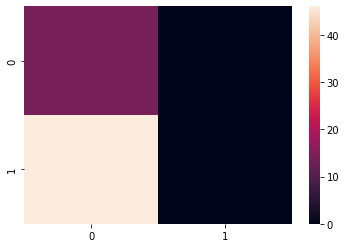

In [291]:
sns.heatmap(cm)

In [389]:
x = ESRD[['AGE', 'GENDER_d', 'B_PROTEIN', 'B_ALBUMIN', 'BIOPSY_AGE', 'IgG', 'IgM', 'IgA', 'C3S', 'URIC_ACID', 'B_HEMATOCRIT', 'B_PLATELET', 'WBC', 'NEUTRO', 'LYMPHO', 'BIOPSY_TIME', 'B_PP', 
         'B_MAP', 'HEMATURIA_d', 'B_creatinine', 'B_eGFR','FUT']]
y = ESRD['ESRD']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
x = sm.add_constant(x) # adding a constant
 
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
 
print_model = model.summary()
print(print_model)

Intercept: 
 1.1050419108915515
Coefficients: 
 [-1.35002343e-02  2.30073742e-01  3.04787022e-03  2.04660494e-03
  1.80881755e-02  1.62939559e-01  8.97468134e-03 -8.78523332e-02
 -2.13165771e-02 -8.09386243e-04  2.00483577e-03  6.52454178e-05
 -1.70632185e-02  4.13970188e-02 -6.09343341e-02 -2.02659186e-01
 -6.70404735e-02  2.02854180e-01  6.21360704e-02 -2.86822797e-03
  1.66122297e-03 -1.43604925e-03]
                            OLS Regression Results                            
Dep. Variable:                   ESRD   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     3.846
Date:                Sun, 30 Oct 2022   Prob (F-statistic):           2.06e-05
Time:                        16:26:39   Log-Likelihood:                -5.7262
No. Observations:                  81   AIC:                             57.45
Df Residuals:                      58   

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


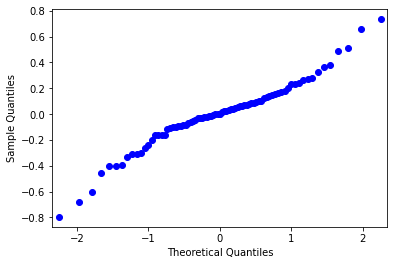

In [293]:
#plotting residual
x = sm.add_constant(x) # adding a constant
 
model = sm.OLS(y, x).fit()
res = model.resid
 
fig = sm.qqplot(res)

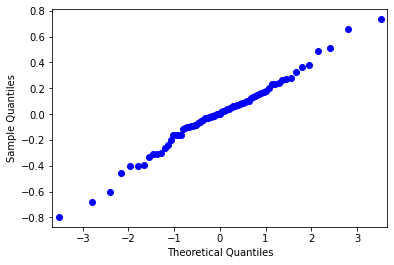

In [294]:
fig = sm.qqplot(res, stats.t, distargs=(4,))

In [390]:
#define the predictor variables and the response variable

X = ESRD[['AGE','B_HEMATOCRIT', 'GENDER_d', 'B_PLATELET', 'URIC_ACID', 'B_creatinine', 'B_eGFR', 'C3S','IgM', 'IgA', 'IgG', 'HEMATURIA_d']]
y = ESRD['ESRD']

#split the dataset into training (70%) and testing (30%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0) 

#instantiate the model
log_regression = LogisticRegression()

#fit the model using the training data
log_regression.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [391]:
Rf_model = RandomForestClassifier()

Rf_model.fit(X_train,y_train)

Rf = Rf_model.predict(X_train)

Rf_pred = Rf_model.predict(X_test)

print(accuracy_score(y_test,Rf_pred))

0.96


In [392]:
print(classification_report(y_test,Rf_pred))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.95      1.00      0.98        20

    accuracy                           0.96        25
   macro avg       0.98      0.90      0.93        25
weighted avg       0.96      0.96      0.96        25



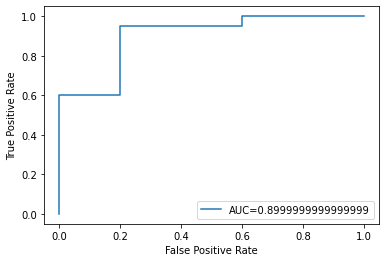

In [296]:
y_pred_proba = log_regression.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)

In [400]:
#instantiate the model
log_regression = LogisticRegression()

#fit the model using the training data
log_regression.fit(X_train,y_train)

#use model to make predictions on test data
y_pred = log_regression.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [401]:
cm = metrics.confusion_matrix(y_test, y_pred)
print("confusion matrix:\n",cm)

confusion matrix:
 [[ 1  3]
 [ 1 16]]


From the confusion matrix we can see that:

True positive predictions: 3
True negative predictions: 19
False positive predictions: 2
False negative predictions: 1

In [299]:
print("Accuracy =",metrics.accuracy_score(y_test, y_pred))

Accuracy = 0.88


In [300]:
print("f1 score =",metrics.f1_score(y_test, y_pred))

f1 score = 0.9268292682926829


In [301]:
print("precision score =",metrics.precision_score(y_test, y_pred))

precision score = 0.9047619047619048


In [302]:
print("recall score =",metrics.recall_score(y_test, y_pred))

recall score = 0.95


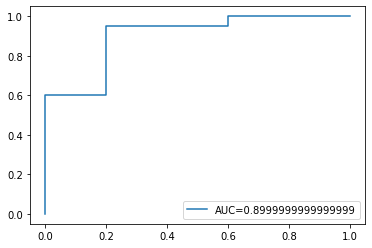

In [303]:
y_pred_proba = log_regression.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)

In [402]:
X = OUTCOME[['AGE','B_HEMATOCRIT', 'GENDERL', 'B_PLATELET', 'URIC_ACID', 'B_creatinine', 'B_eGFR', 'C3S','IgM', 'IgA', 'IgG', 'HEMATURIA_d']]
y = df1['OUTCOME']
#Fit the LDA model
model = LinearDiscriminantAnalysis()
model.fit(X, y)

LinearDiscriminantAnalysis()

In [404]:
Rf_model = RandomForestClassifier()

Rf_model.fit(X,y)

Rf = Rf_model.predict(X)

Rf_pred = Rf_model.predict(X)

print(accuracy_score(y,Rf_pred))

1.0


In [405]:
print(classification_report(y,Rf_pred))

              precision    recall  f1-score   support

      50PERC       1.00      1.00      1.00         4
        ESRD       1.00      1.00      1.00        17
          NO       1.00      1.00      1.00        60

    accuracy                           1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81



In [305]:
#Define method to evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print("mean accuracy = ", np.mean(scores))  

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  UserWarning,


mean accuracy =  0.7824074074074073


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  UserWarning,


In [306]:
#define new observation
new = [38, 12.3, 1, 317, 449, 130, 74, 1, 0.5, 2, 0.5, 2]

#predict which class the new observation belongs to
print(model.predict([new]))

['NO']


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  "X does not have valid feature names, but"


In [307]:
X = OUTCOME[['AGE','B_HEMATOCRIT', 'GENDERL', 'B_PLATELET', 'URIC_ACID', 'B_creatinine', 'B_eGFR', 'C3S','IgM', 'IgA', 'IgG', 'HEMATURIA_d']]
y = df1['OUTCOME']

#Fit the QDA model
model = QuadraticDiscriminantAnalysis()
model.fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis()

In [308]:
#Define method to evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.median(scores))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  UserWarning,


0.75


In [309]:
#define new observation
new = [68, 5, 2, 917, 949, 930, 74, 3, 104, 9, 6, 10]

#predict which class the new observation belongs to
print(model.predict([new]))

['NO']


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  "X does not have valid feature names, but"


In [310]:
X = ESRD[['AGE','B_HEMATOCRIT', 'GENDER_d', 'B_PLATELET', 'URIC_ACID', 'B_creatinine', 'B_eGFR', 'C3S','IgM', 'IgA', 'IgG', 'HEMATURIA_d']]
y = ESRD['BIOPSY_TIME']

#define cross-validation method to evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

#define model
model = RidgeCV(alphas=arange(0, 1, 0.01), cv=cv, scoring='neg_mean_absolute_error')

#fit model
model.fit(X, y)

#display lambda that produced the lowest test MSE
print(model.alpha_)

0.99


In [311]:

#define new observation
new = [70, 1.3, 2, 111, 960, 350, 35, 0, 1, 0, 1, 4]

#predict which class the new observation belongs to
print(model.predict([new]))

[52.63316032]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RidgeCV was fitted with feature names
  "X does not have valid feature names, but"


In [312]:
X = OUTCOME[['AGE','B_HEMATOCRIT', 'GENDERL', 'B_PLATELET', 'URIC_ACID', 'OUTCOME_d', 'B_eGFR', 'C3S','IgM', 'IgA', 'IgG', 'HEMATURIA_d']]
y = OUTCOME['B_creatinine']

In [313]:
#define cross-validation method to evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

#define model
model = LassoCV(alphas=arange(0, 1, 0.01), cv=cv, n_jobs=-1)

#fit model
model.fit(X, y)

#display lambda that produced the lowest test MSE
print(model.alpha_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46285.521033135476, tolerance: 56.098398611111094
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might wa

0.15


In [314]:
#define new observation
new = [70, 1.3, 2, 111, 960, 2, 35, 0, 1, 0, 1, 4]

#predict which class the new observation belongs to
print(model.predict([new]))

[352.84246201]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  "X does not have valid feature names, but"


In [315]:
ESRD.apply(stats.zscore)

AGE  BIOPSY_AGE  B_PROTEIN  B_ALBUMIN  B_HEMATOCRIT  B_PLATELET  \
0   0.180062   -0.302677   0.732025   0.654260      0.126459   -0.077597   
1  -0.018374   -0.503634   0.469358   0.388621     -0.442608    1.191917   
2  -0.018374   -0.604113   0.031578   0.654260     -0.158074    1.440841   
3   0.279280   -0.202198   0.907137   1.185539      0.695527    0.594499   
4  -0.415245   -0.905550  -1.106650  -1.338036      0.624394   -0.090043   
..       ...         ...        ...        ...           ...         ...   
76 -0.415245   -0.101719   0.000000   1.185539      2.189330   -0.687461   
77 -0.712898   -0.805071  -0.756426  -1.072396     -1.011676    0.880761   
78 -0.018374    0.099238   0.907137   0.388621      0.268726   -0.550553   
79 -1.407423   -1.206986   0.000000   1.052719      0.339860    1.017670   
80 -0.415245   -0.604113  -1.106650  -1.603675      2.331597    1.154578   

         WBC    NEUTRO    LYMPHO     URIC_ACID  ...    B_UPCR  BIOPSY_TIME  \
0   0.694749  0.096960  0.599289  5.355582e-16  ... -1.074179     0.999981   
1   0.339760  0.572230 -0.757750 -8.222193e-01  ...  0.009812    -0.066665   
2   1.049738  1.637375 -1.478678 -1.481734e+00  ... -0.513494     1.497749   
3   1.878046  1.974446  0.910278  5.355582e-16  ... -0.962042    -0.279995   
4  -0.666043 -0.698528  0.104535  5.355582e-16  ...  0.869529     0.004444   
..       ...       ...       ...           ...  ...       ...          ...   
76 -0.015229 -0.277189  1.518118  7.229297e-01  ... -0.737768     0.431103   
77 -0.754790 -0.644597 -0.573985  5.355582e-16  ...  2.028279     1.782188   
78 -0.370219 -0.674933  1.235402 -4.736186e-01  ... -0.849905     0.075554   
79 -0.044812  0.147521 -0.390219 -1.330988e+00  ... -0.812526    -0.919982   
80 -0.606878 -0.594036 -0.135774 -2.003910e-01  ...  2.439448     0.217774   

         FUT       C3S       IgM       IgA       IgG  GENDER_d  HEMATURIA_d  \
0   3.038607 -1.392753  0.060547 -0.555584  1.099437 -0.591608    -1.851102   
1   0.947763  1.042060  1.531843  0.808122  0.243145 -0.591608     0.311484   
2   0.529594 -1.392753  0.550979 -0.555584 -0.613148 -0.591608    -1.851102   
3   3.038607 -1.392753  0.550979 -1.919290  1.099437 -0.591608    -1.851102   
4   3.038607  0.230456  1.531843  0.808122 -0.613148  1.690309    -1.851102   
..       ...       ...       ...       ...       ...       ...          ...   
76 -0.411285  1.042060 -1.410749 -0.555584 -0.613148  1.690309     0.311484   
77 -0.794607  0.230456  0.550979 -0.555584 -0.613148 -0.591608     0.311484   
78 -0.515828 -1.392753 -1.410749 -0.555584 -0.613148 -0.591608    -1.851102   
79  0.355357  1.042060  0.550979  0.808122 -0.613148 -0.591608     0.311484   
80 -0.724912 -1.392753  0.550979 -0.555584 -0.613148  1.690309     0.311484   

        ESRD  
0  -1.940285  
1   0.515388  
2   0.515388  
3   0.515388  
4   0.515388  
..       ...  
76  0.515388  
77 -1.940285  
78  0.515388  
79  0.515388  
80  0.515388  

[81 rows x 26 columns]

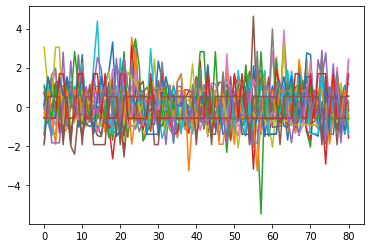

In [316]:
plt.plot(ESRD.apply(stats.zscore))

Text(0.5, 1.0, 'creatinine')

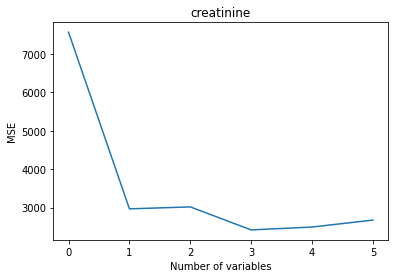

In [317]:
#scale predictor variables
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

#define cross validation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept
score = -1*model_selection.cross_val_score(regr,
           np.ones((len(X_reduced),1)), y, cv=cv,
           scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 6):
    score = -1*model_selection.cross_val_score(regr,
               X_reduced[:,:i], y, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot cross-validation results    
plt.plot(mse)
plt.xlabel('Number of variables')
plt.ylabel('MSE')
plt.title('creatinine')

In [318]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)


array([22.36, 37.44, 51.55, 60.17, 68.21, 74.98, 81.45, 86.69, 91.  ,
       94.92, 97.56, 99.99])

In [319]:
#split the dataset into training (70%) and testing (30%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0) 

#scale the training and testing data
X_reduced_train = pca.fit_transform(scale(X_train))
X_reduced_test = pca.transform(scale(X_test))[:,:1]

#train PCR model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:1], y_train)

#calculate RMSE
pred = regr.predict(X_reduced_test)
np.sqrt(mean_squared_error(y_test, pred))

53.60001287523082

We can see that the test RMSE turns out to be 53.6000123. This is the average deviation between the predicted value for creatinine and the observed value of creatinine for the observations in the testing set.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/cross_decomposition/_pls.py", line 353, in fit
    pinv2(np.dot(self.x_loadings_.T, self.x_weights_), check_finite=False),
  File "/usr/local/lib/python3.7/dist-packages/scipy/linalg/basic.py", line 1316, in pinv
    u, s, vh = decomp_svd.svd(a, full_matrices=Fal

Text(0.5, 1.0, 'OUTCOME')

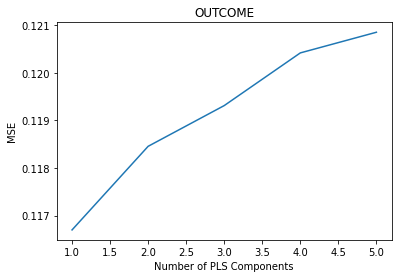

In [431]:
X = ESRD[['AGE','B_HEMATOCRIT', 'GENDER_d', 'B_PLATELET', 'URIC_ACID', 'B_creatinine', 'B_eGFR', 'C3S','IgM', 'IgA', 'IgG', 'HEMATURIA_d']]
y = ESRD['ESRD']

#define cross-validation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

mse = []
n = len(X)

# Calculate MSE with only the intercept
score = -1*model_selection.cross_val_score(PLSRegression(n_components=1),
           np.ones((n,1)), y, cv=cv, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 6):
    pls = PLSRegression(n_components=i)
    score = -1*model_selection.cross_val_score(pls, scale(X), y, cv=cv,
               scoring='neg_mean_squared_error').mean()
    mse.append(score)

#plot test MSE vs. number of components
plt.plot(mse)
plt.xlabel('Number of PLS Components')
plt.ylabel('MSE')
plt.title('OUTCOME')


In [432]:
#split the dataset into training (70%) and testing (30%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0) 

#calculate RMSE
pls = PLSRegression(n_components=2)
pls.fit(scale(X_train), y_train)

np.sqrt(mean_squared_error(y_test, pls.predict(scale(X_test))))


0.2826777787243218

In [445]:
Rf_model = RandomForestClassifier()

Rf_model.fit(X_train,y_train)

Rf = Rf_model.predict(X_train)

Rf_pred = Rf_model.predict(X_test)

print(accuracy_score(y_test,Rf_pred))

0.96


In [446]:
print(classification_report(y_test,Rf_pred))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.95      1.00      0.98        20

    accuracy                           0.96        25
   macro avg       0.98      0.90      0.93        25
weighted avg       0.96      0.96      0.96        25



In [447]:
classifier = make_pipeline(StandardScaler(), LinearSVC())
classifier.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])

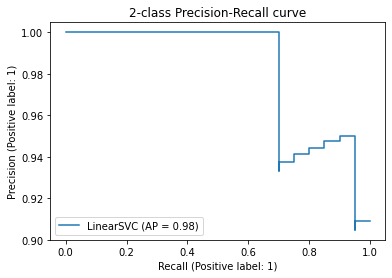

In [448]:
display = PrecisionRecallDisplay.from_estimator(
    classifier, X_test, y_test, name="LinearSVC"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

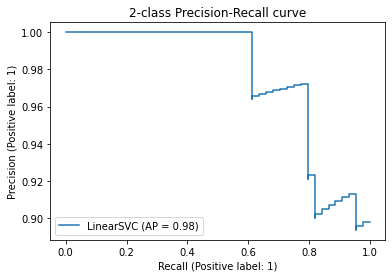

In [450]:
display = PrecisionRecallDisplay.from_estimator(
    classifier, X_train, y_train, name="LinearSVC"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/cross_decomposition/_pls.py", line 353, in fit
    pinv2(np.dot(self.x_loadings_.T, self.x_weights_), check_finite=False),
  File "/usr/local/lib/python3.7/dist-packages/scipy/linalg/basic.py", line 1316, in pinv
    u, s, vh = decomp_svd.svd(a, full_matrices=Fal

Text(0.5, 1.0, 'OUTCOME')

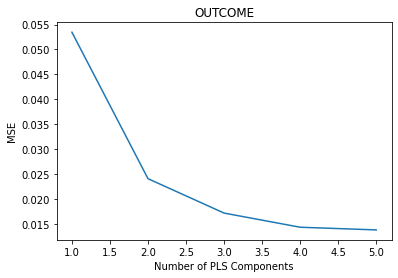

In [388]:
x = ESRD[['AGE', 'GENDER_d', 'B_PROTEIN', 'B_ALBUMIN', 'BIOPSY_AGE', 'IgG', 'IgM', 'IgA', 'C3S', 'URIC_ACID', 'B_HEMATOCRIT', 'B_PLATELET', 'WBC', 'NEUTRO', 'LYMPHO', 'BIOPSY_TIME', 'B_PP', 
         'B_MAP', 'HEMATURIA_d', 'B_creatinine', 'B_eGFR','FUT']]
y = ESRD['ESRD']

#define cross-validation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

mse = []
n = len(X)

# Calculate MSE with only the intercept
score = -1*model_selection.cross_val_score(PLSRegression(n_components=1),
           np.ones((n,1)), y, cv=cv, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 6):
    pls = PLSRegression(n_components=i)
    score = -1*model_selection.cross_val_score(pls, scale(X), y, cv=cv,
               scoring='neg_mean_squared_error').mean()
    mse.append(score)

#plot test MSE vs. number of components
plt.plot(mse)
plt.xlabel('Number of PLS Components')
plt.ylabel('MSE')
plt.title('OUTCOME')

In [437]:
# building the model and fitting the data
log_reg = sm.Logit(y_train, X_train).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.277876
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                   ESRD   No. Observations:                   56
Model:                          Logit   Df Residuals:                       44
Method:                           MLE   Df Model:                           11
Date:                Sun, 30 Oct 2022   Pseudo R-squ.:                  0.4652
Time:                        17:18:23   Log-Likelihood:                -15.561
converged:                       True   LL-Null:                       -29.096
Covariance Type:            nonrobust   LLR p-value:                  0.004483
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
AGE              0.0213      0.049      0.438      0.661      -0.074       0.116
B_HEMATOCRIT    -0.0956

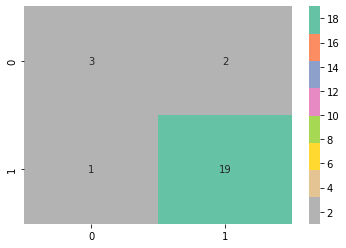

In [324]:
sns.heatmap(cm, annot = True, cmap = 'Set2_r')

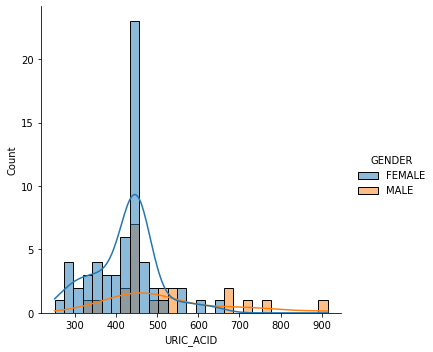

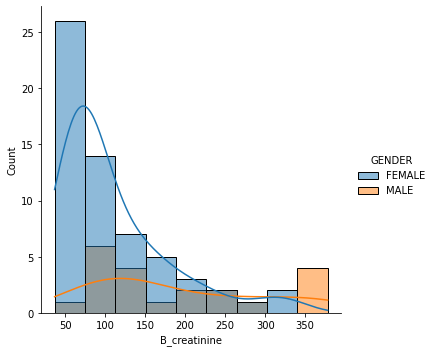

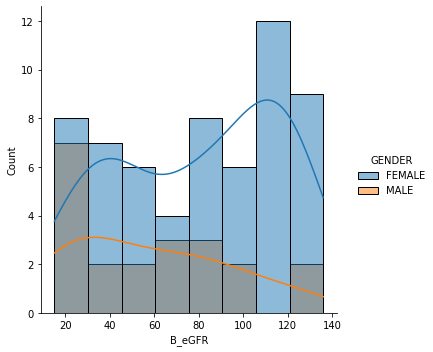

In [325]:
#OUTCOME = 0 (NO), OUTCOME = 1(50PERC) AND OUTCOME = 2 (ESRD)
sns.displot(OUTCOME, x="URIC_ACID", hue="GENDER", kde = True)

sns.displot(OUTCOME, x="B_creatinine", hue="GENDER", kde = True)

sns.displot(OUTCOME, x="B_eGFR", hue="GENDER", kde=True)


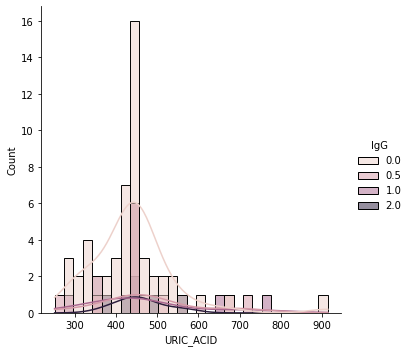

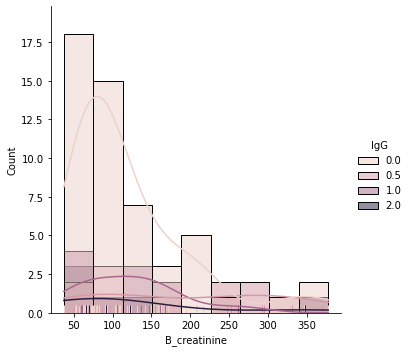

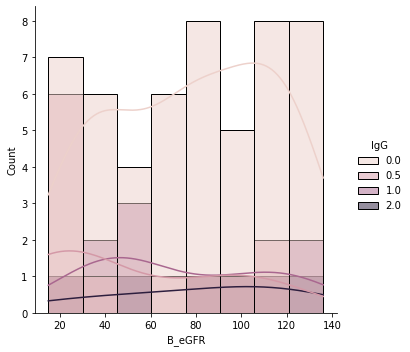

In [326]:
sns.displot(OUTCOME, x="URIC_ACID", hue="IgG", kde = True)

sns.displot(OUTCOME, x="B_creatinine", hue="IgG", kde = True, rug = True)

sns.displot(OUTCOME, x="B_eGFR", hue="IgG", kde = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103

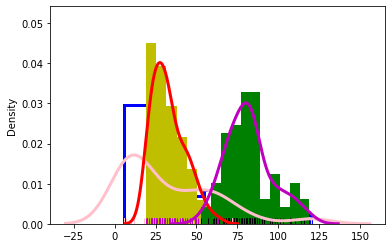

In [327]:
sns.distplot(x = OUTCOME.FUT, rug=True, rug_kws={"color": "pink"}, kde_kws={"color": "pink", "lw": 3, "label": "KDE"}, 
             hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": "b"})

sns.distplot(x = OUTCOME.BIOPSY_AGE, rug=True, rug_kws={"color": "m"}, kde_kws={"color": "r", "lw": 3, "label": "KDE"}, 
             hist_kws={"histtype": "stepfilled", "linewidth": 3, "alpha": 1, "color": "y"})

sns.distplot(x = OUTCOME.BIOPSY_TIME, rug=True, rug_kws={"color": "k"}, kde_kws={"color": "m", "lw": 3, "label": "KDE"}, 
             hist_kws={"histtype": "bar", "linewidth": 3, "alpha": 1, "color": "g"})

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103

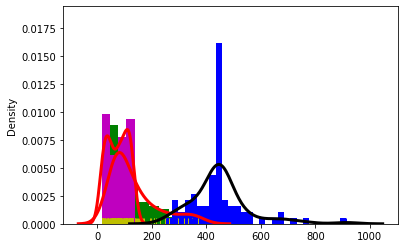

In [328]:
sns.distplot(x = OUTCOME.B_creatinine, rug=True, rug_kws={"color": "y"}, kde_kws={"color": "r", "lw": 3, "label": "KDE"}, 
             hist_kws={"histtype": "stepfilled", "linewidth": 3, "alpha": 1, "color": "g"})

sns.distplot(x = OUTCOME.B_eGFR, rug=True, rug_kws={"color": "y"}, kde_kws={"color": "r", "lw": 3, "label": "KDE"}, 
             hist_kws={"histtype": "barstacked", "linewidth": 3, "alpha": 1, "color": "m"})

sns.distplot(x = OUTCOME.URIC_ACID, rug=True, rug_kws={"color": "b"}, kde_kws={"color": "k", "lw": 3, "label": "KDE"}, 
             hist_kws={"histtype": "bar", "linewidth": 3, "alpha": 1, "color": "b"})

(array([ 1.,  1.,  4.,  3.,  6.,  4., 11.,  5., 11., 11.,  5.,  3.,  1.,
         5.,  1.,  1.,  4.,  1.,  1.,  2.]),
 array([ 53. ,  56.3,  59.6,  62.9,  66.2,  69.5,  72.8,  76.1,  79.4,
         82.7,  86. ,  89.3,  92.6,  95.9,  99.2, 102.5, 105.8, 109.1,
        112.4, 115.7, 119. ]),
 <a list of 20 Patch objects>)

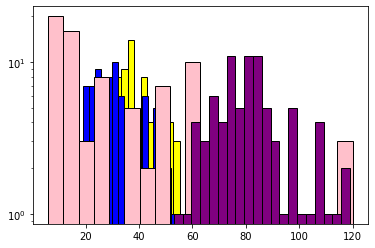

In [329]:
plt.hist(OUTCOME['AGE'], bins=20, log = True, color='yellow', edgecolor='black')

plt.hist(OUTCOME['BIOPSY_AGE'], bins=20, log = True, color='blue', edgecolor='black')

plt.hist(OUTCOME['FUT'], bins=20, log = True, color='pink', edgecolor='black')

plt.hist(OUTCOME['BIOPSY_TIME'], bins=20, log = True, color='purple', edgecolor='black')

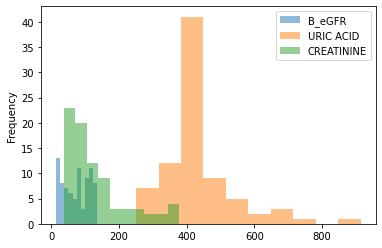

In [330]:
# Generate sample data
y1 = OUTCOME.B_eGFR
y2 = OUTCOME.URIC_ACID
y3 = OUTCOME.B_creatinine

# Plot regular histograms
plt.figure()
plt.hist(y1, alpha=0.5, label='B_eGFR')
plt.hist(y2, alpha=0.5, label='URIC ACID')
plt.hist(y3, alpha=0.5, label='CREATININE')
plt.ylabel('Frequency')
plt.legend(loc='best')

Text(0.5, 1.0, 'histogram of uric acid with IgA')

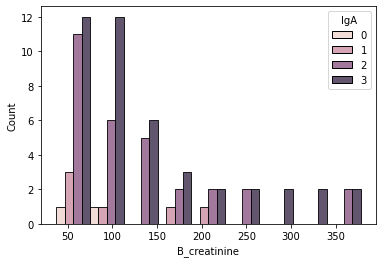

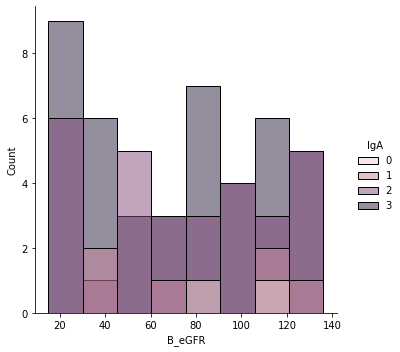

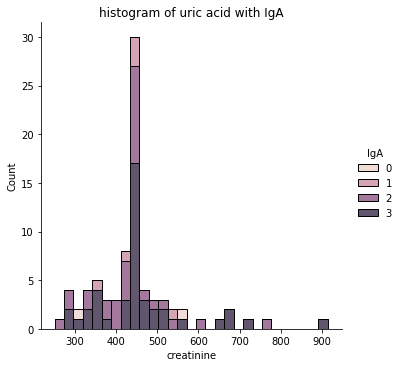

In [331]:
sns.histplot(OUTCOME, x="B_creatinine", hue="IgA", multiple = "dodge")
#plt.title('histogram of creatinine with IgA')

sns.displot(OUTCOME, x="B_eGFR", hue="IgA")
#plt.title('histogram of eGFR with IgA')

sns.displot(OUTCOME, x="URIC_ACID", hue="IgA", multiple = "stack")
plt.xlabel("creatinine")
plt.title('histogram of uric acid with IgA')

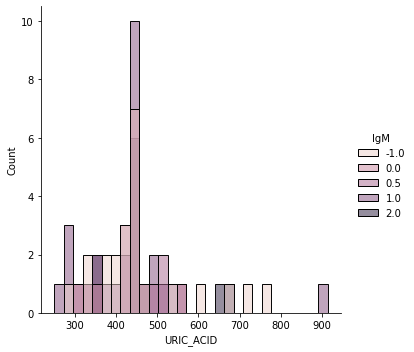

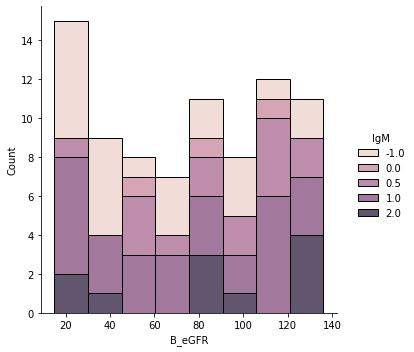

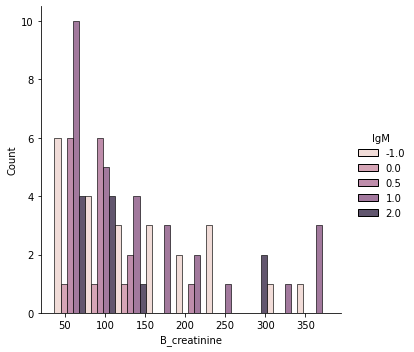

In [332]:
sns.displot(OUTCOME, x="URIC_ACID", hue="IgM")
#plt.title('hitogram of uric acid with IgM')

sns.displot(OUTCOME, x="B_eGFR", hue="IgM", multiple = 'stack')
#plt.title('histogram of eGFR with IgM')

sns.displot(OUTCOME, x="B_creatinine", hue="IgM", multiple = "dodge")
#plt.title('histogram of creatinine with IgM')

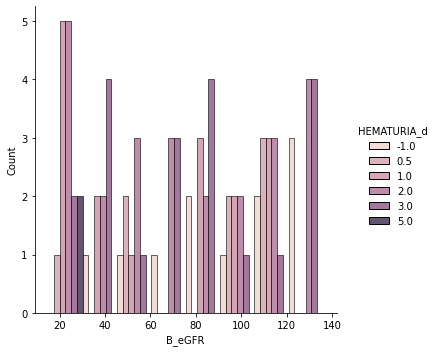

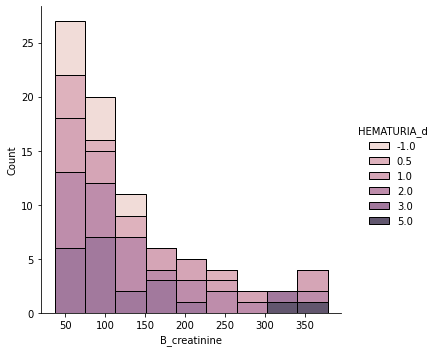

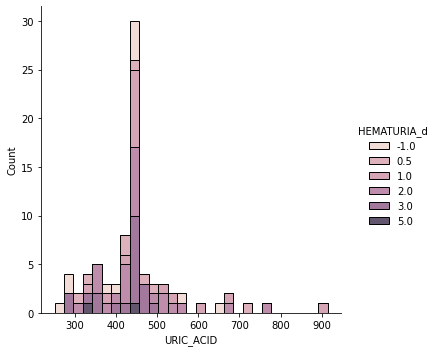

In [333]:

sns.displot(OUTCOME, x="B_eGFR", hue="HEMATURIA_d", multiple = 'dodge')
#plt.title('histogram of eGFR with HEMATURIA')

sns.displot(OUTCOME, x="B_creatinine", hue="HEMATURIA_d", multiple = "stack")
#plt.title('histogram of creatinine with HEMATURIA')

sns.displot(OUTCOME, x="URIC_ACID", hue="HEMATURIA_d", multiple = "stack")
#plt.title('hitogram of uric acid with HEMATURIA')

Text(0.5, 1.0, 'histogram of eGFR with C3STAIN')

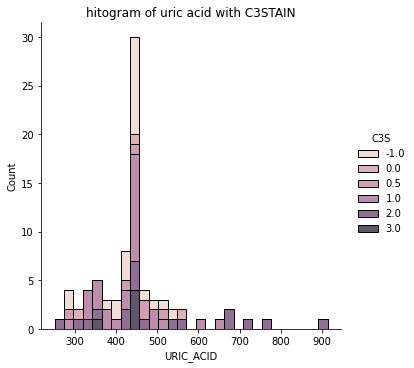

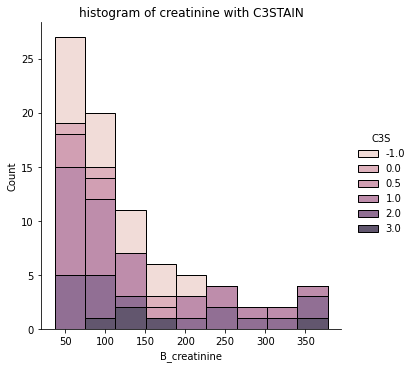

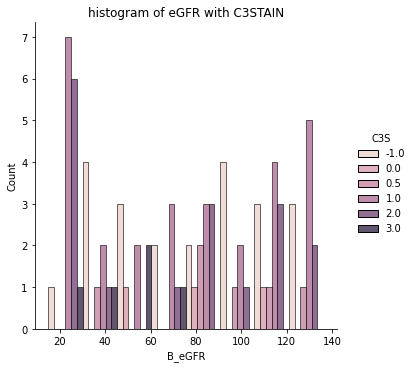

In [334]:
sns.displot(OUTCOME, x="URIC_ACID", hue="C3S", multiple = "stack")
plt.title('hitogram of uric acid with C3STAIN')

sns.displot(OUTCOME, x="B_creatinine", hue="C3S", multiple = "stack")
plt.title('histogram of creatinine with C3STAIN')

sns.displot(OUTCOME, x="B_eGFR", hue="C3S", multiple = 'dodge')
plt.title('histogram of eGFR with C3STAIN')

(array([1., 0., 0., 1., 0., 1., 3., 0., 1., 2., 1., 3., 5., 1., 0., 8., 2.,
        1., 4., 1., 3., 8., 5., 3., 3., 4., 1., 0., 3., 0., 0., 1., 2., 0.,
        3., 0., 1., 1., 0., 0., 3., 1., 0., 1., 0., 0., 1., 1., 0., 1.]),
 array([ 53.  ,  54.32,  55.64,  56.96,  58.28,  59.6 ,  60.92,  62.24,
         63.56,  64.88,  66.2 ,  67.52,  68.84,  70.16,  71.48,  72.8 ,
         74.12,  75.44,  76.76,  78.08,  79.4 ,  80.72,  82.04,  83.36,
         84.68,  86.  ,  87.32,  88.64,  89.96,  91.28,  92.6 ,  93.92,
         95.24,  96.56,  97.88,  99.2 , 100.52, 101.84, 103.16, 104.48,
        105.8 , 107.12, 108.44, 109.76, 111.08, 112.4 , 113.72, 115.04,
        116.36, 117.68, 119.  ]),
 <a list of 50 Patch objects>)

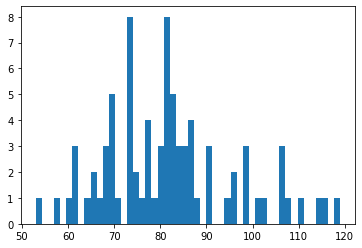

In [335]:
T = OUTCOME["BIOPSY_TIME"]
E = OUTCOME["OUTCOME_d"]
plt.hist(T, bins = 50)

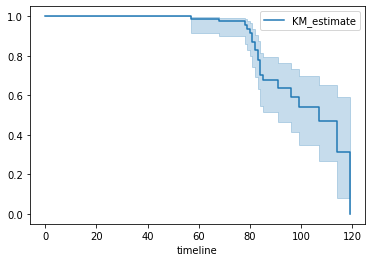

In [336]:
kmf = KaplanMeierFitter()
kmf.fit(durations = T, event_observed = E)
kmf.plot_survival_function()

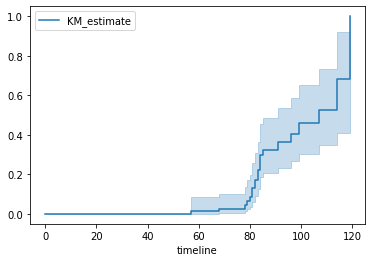

In [337]:
kmf.plot_cumulative_density() #FAILURE CURVE

(array([19.,  1., 16.,  0.,  0.,  1.,  2.,  7.,  1.,  0.,  0.,  0.,  0.,
         4.,  1.,  0.,  2.,  0.,  6.,  1.,  0.,  0.,  0., 10.,  0.,  1.,
         0.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.]),
 array([  6.  ,   8.28,  10.56,  12.84,  15.12,  17.4 ,  19.68,  21.96,
         24.24,  26.52,  28.8 ,  31.08,  33.36,  35.64,  37.92,  40.2 ,
         42.48,  44.76,  47.04,  49.32,  51.6 ,  53.88,  56.16,  58.44,
         60.72,  63.  ,  65.28,  67.56,  69.84,  72.12,  74.4 ,  76.68,
         78.96,  81.24,  83.52,  85.8 ,  88.08,  90.36,  92.64,  94.92,
         97.2 ,  99.48, 101.76, 104.04, 106.32, 108.6 , 110.88, 113.16,
        115.44, 117.72, 120.  ]),
 <a list of 50 Patch objects>)

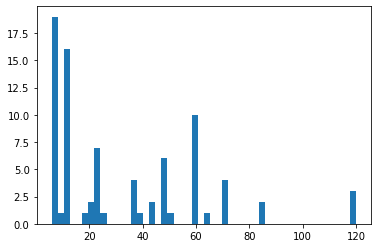

In [338]:
T = OUTCOME["FUT"]
E = ESRD["ESRD"]
plt.hist(T, bins = 50)

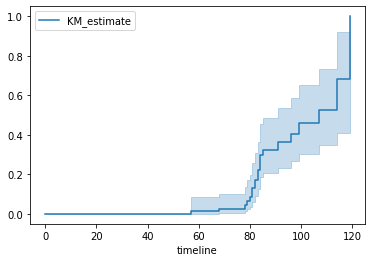

In [339]:
kmf.plot_cumulative_density()

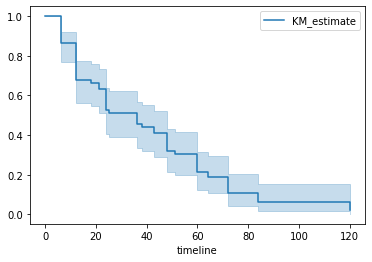

In [340]:
kmf = KaplanMeierFitter()
kmf.fit(durations = T, event_observed = E)
kmf.plot_survival_function()

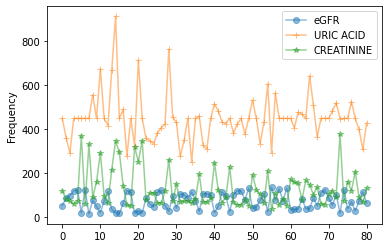

In [341]:
# Generate sample data
y1 = OUTCOME.B_eGFR
y2 = OUTCOME.URIC_ACID
y3 = OUTCOME.B_creatinine

# Plot regular histograms
plt.figure()
plt.plot(y1, alpha=0.5, label='eGFR', marker = 'o')
plt.plot(y2, alpha=0.5, label='URIC ACID', marker = '+')
plt.plot(y3, alpha=0.5, label='CREATININE', marker = '*')
plt.ylabel('Frequency')
plt.legend(loc='best')


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

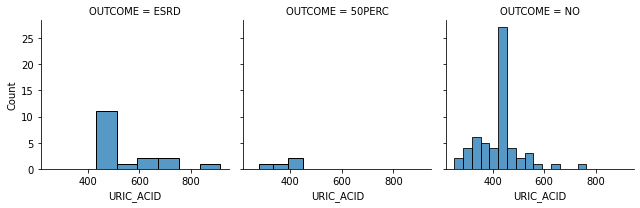

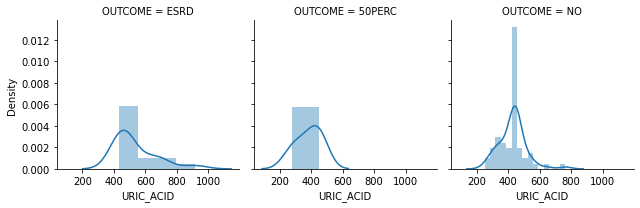

In [342]:

g = sns.FacetGrid(data=df1, col='OUTCOME')

#add histograms to each plot
g.map(sns.histplot, 'URIC_ACID')

g = sns.FacetGrid(data=df1, col='OUTCOME')

#add histograms to each plot
g.map(sns.distplot, 'URIC_ACID')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

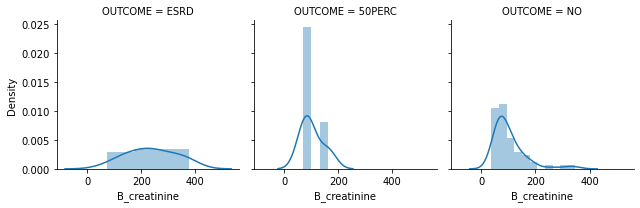

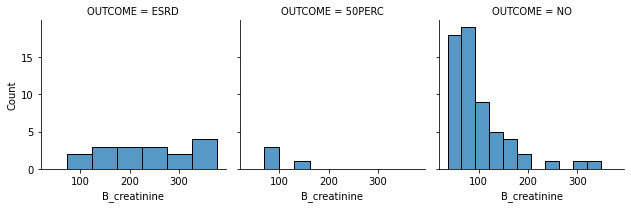

In [343]:
g = sns.FacetGrid(data=df1, col='OUTCOME')

#add histograms to each plot
g.map(sns.distplot, 'B_creatinine')

g = sns.FacetGrid(data=df1, col='OUTCOME')

#add histograms to each plot
g.map(sns.histplot, 'B_creatinine')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

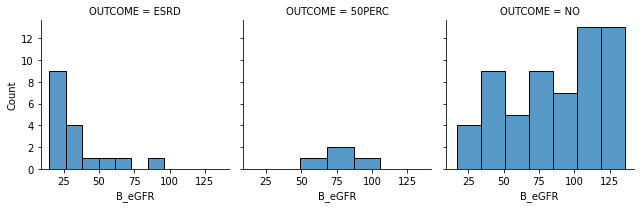

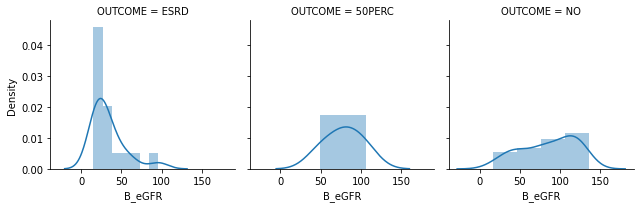

In [344]:
g = sns.FacetGrid(data=df1, col='OUTCOME')

#add histograms to each plot
g.map(sns.histplot, 'B_eGFR')

g = sns.FacetGrid(data = df1, col = "OUTCOME" )

#add distograms to each plot
g.map(sns.distplot, 'B_eGFR')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

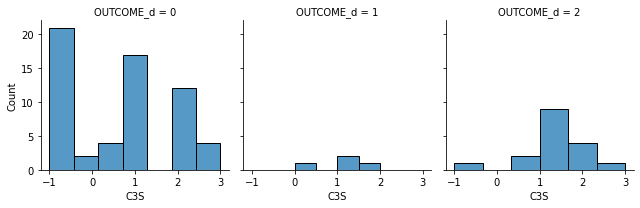

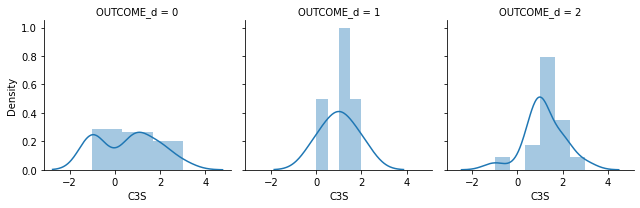

In [345]:
#OUTCOME = 0 (NO), OUTCOME = 1(50PERC) AND OUTCOME = 2 (ESRD)
g = sns.FacetGrid(data=OUTCOME, col='OUTCOME_d')

#add histograms to each plot
g.map(sns.histplot, 'C3S')

g = sns.FacetGrid(data = OUTCOME, col = "OUTCOME_d" )

#add distograms to each plot
g.map(sns.distplot, 'C3S')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

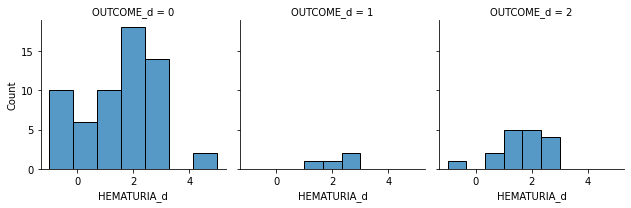

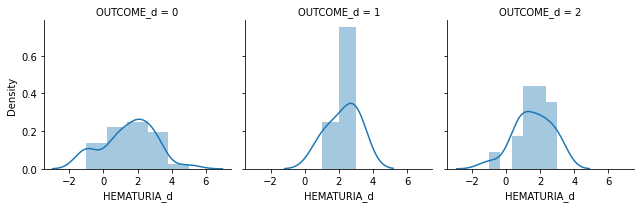

In [346]:
g = sns.FacetGrid(data=OUTCOME, col='OUTCOME_d')

#add histograms to each plot
g.map(sns.histplot, 'HEMATURIA_d')

g = sns.FacetGrid(data = OUTCOME, col = "OUTCOME_d" )

#add distograms to each plot
g.map(sns.distplot, 'HEMATURIA_d')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

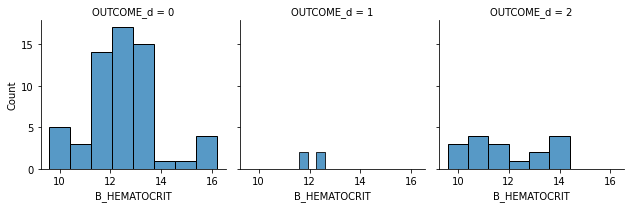

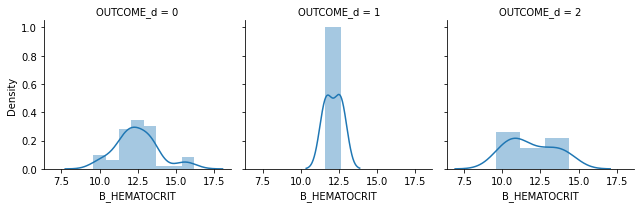

In [347]:
#OUTCOME = 0 (NO), OUTCOME = 1(50PERC) AND OUTCOME = 2 (ESRD)
g = sns.FacetGrid(data=OUTCOME, col='OUTCOME_d')

#add histograms to each plot
g.map(sns.histplot, 'B_HEMATOCRIT')

g = sns.FacetGrid(data = OUTCOME, col = "OUTCOME_d" )

#add distograms to each plot
g.map(sns.distplot, 'B_HEMATOCRIT')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

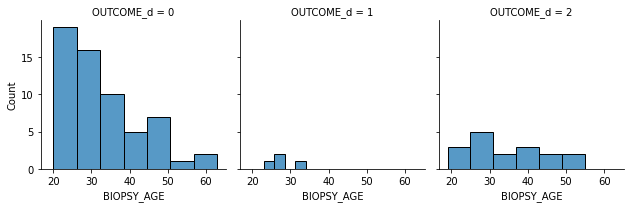

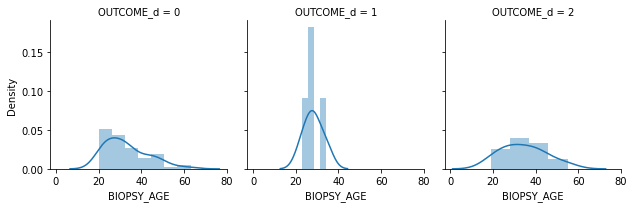

In [348]:
#OUTCOME = 0 (NO), OUTCOME = 1(50PERC) AND OUTCOME = 2 (ESRD)

g = sns.FacetGrid(data=OUTCOME, col='OUTCOME_d')

#add histograms to each plot
g.map(sns.histplot, 'BIOPSY_AGE')

g = sns.FacetGrid(data = OUTCOME, col = "OUTCOME_d" )

#add distograms to each plot
g.map(sns.distplot, 'BIOPSY_AGE')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

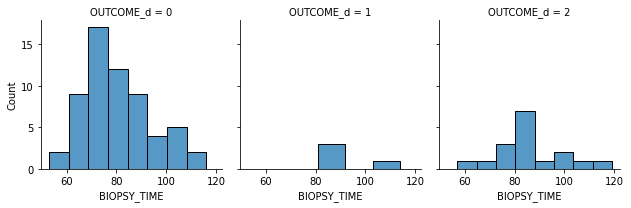

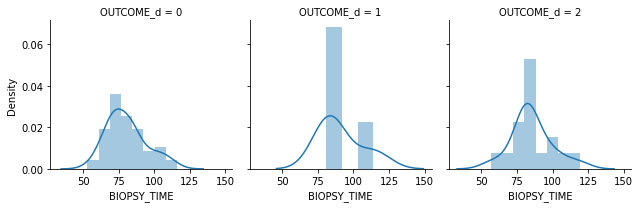

In [349]:
#OUTCOME = 0 (NO), OUTCOME = 1(50PERC) AND OUTCOME = 2 (ESRD)
g = sns.FacetGrid(data=OUTCOME, col='OUTCOME_d')

#add histograms to each plot
g.map(sns.histplot, 'BIOPSY_TIME')

g = sns.FacetGrid(data = OUTCOME, col = "OUTCOME_d" )

#add distograms to each plot
g.map(sns.distplot, 'BIOPSY_TIME')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

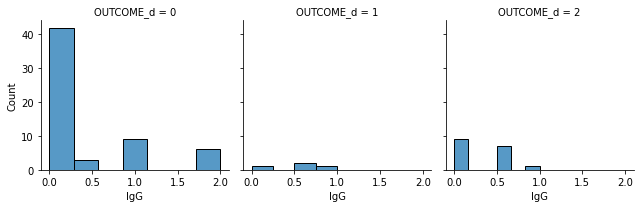

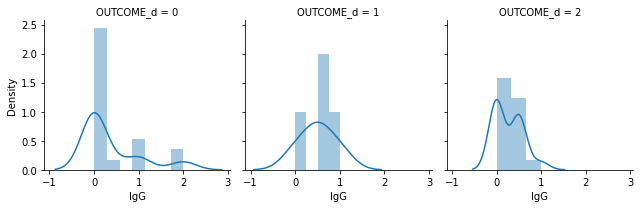

In [350]:
#OUTCOME = 0 (NO), OUTCOME = 1(50PERC) AND OUTCOME = 2 (ESRD)
g = sns.FacetGrid(data=OUTCOME, col='OUTCOME_d')

#add histograms to each plot
g.map(sns.histplot, 'IgG')

g = sns.FacetGrid(data = OUTCOME, col = "OUTCOME_d" )

#add distograms to each plot
g.map(sns.distplot, 'IgG')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

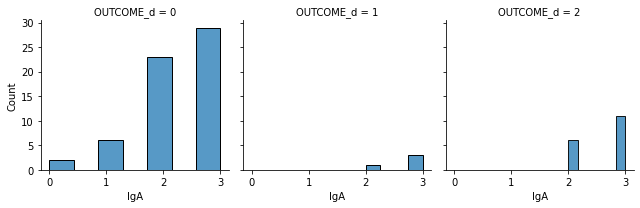

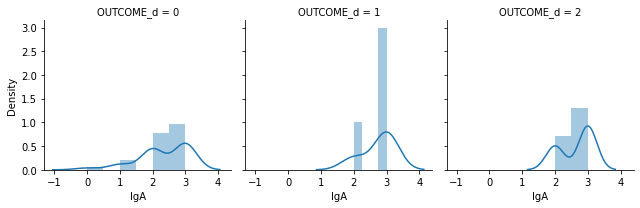

In [351]:
#OUTCOME = 0 (NO), OUTCOME = 1(50PERC) AND OUTCOME = 2 (ESRD)
g = sns.FacetGrid(data=OUTCOME, col='OUTCOME_d')

#add histograms to each plot
g.map(sns.histplot, 'IgA')

g = sns.FacetGrid(data = OUTCOME, col = "OUTCOME_d" )

#add distograms to each plot
g.map(sns.distplot, 'IgA')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

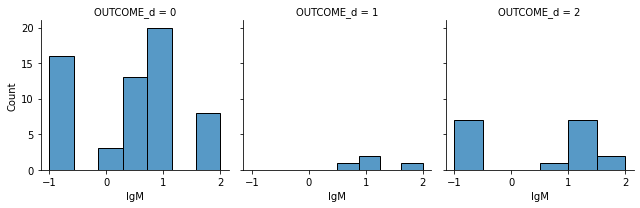

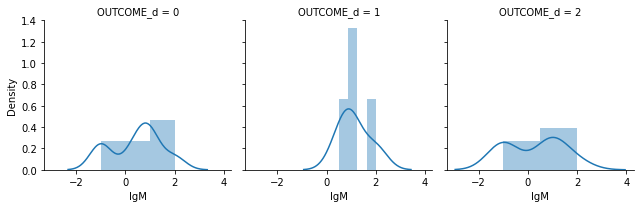

In [352]:
#OUTCOME = 0 (NO), OUTCOME = 1(50PERC) AND OUTCOME = 2 (ESRD)
g = sns.FacetGrid(data=OUTCOME, col='OUTCOME_d')

#add histograms to each plot
g.map(sns.histplot, 'IgM')

g = sns.FacetGrid(data = OUTCOME, col = "OUTCOME_d" )

#add distograms to each plot
g.map(sns.distplot, 'IgM')

In [353]:
# defining feature matrix(X) and response vector(y)
X = OUTCOME[['AGE','B_HEMATOCRIT', 'GENDERL', 'B_PLATELET', 'URIC_ACID', 'OUTCOME_d', 'B_eGFR', 'C3S','IgM', 'IgA', 'IgG', 'HEMATURIA_d']]
y = df1['OUTCOME']
 
# splitting X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=1)
  
# create logistic regression object
reg = linear_model.LogisticRegression()
  
# train the model using the training sets
reg.fit(X_train, y_train)
 
# making predictions on the testing set
y_pred = reg.predict(X_test)
  
# comparing actual response values (y_test) with predicted response values (y_pred)
print("Logistic Regression model accuracy(in %):",metrics.accuracy_score(y_test, y_pred)*100)

Logistic Regression model accuracy(in %): 95.23809523809523


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [384]:
Rf_model = RandomForestClassifier()

Rf_model.fit(X_train,y_train)

Rf = Rf_model.predict(X_train)

Rf_pred = Rf_model.predict(X_test)

print(accuracy_score(y_test,Rf_pred))

1.0


In [385]:

print(classification_report(y_test,Rf_pred))

              precision    recall  f1-score   support

      50PERC       1.00      1.00      1.00         1
        ESRD       1.00      1.00      1.00         3
          NO       1.00      1.00      1.00        17

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



In [355]:
print("Logistic Regression model recall(in %):",metrics.accuracy_score(y_test, y_pred)*100)

Logistic Regression model recall(in %): 95.23809523809523


In [356]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print("confusion matrix:\n",cnf_matrix)

confusion matrix:
 [[ 0  0  1]
 [ 0  3  0]
 [ 0  0 17]]


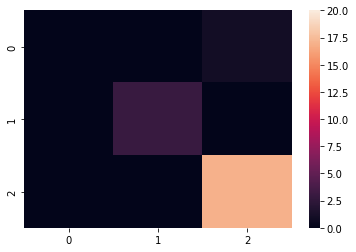

In [357]:
sns.heatmap(cnf_matrix, vmin = 0, vmax=20)

In [358]:
#fit simple linear regression model
model = ols('ESRD ~ AGE + B_HEMATOCRIT + GENDER_d + B_PLATELET + URIC_ACID + B_creatinine + B_eGFR + C3S + IgM + IgA + IgG + HEMATURIA_d + BIOPSY_AGE + BIOPSY_TIME + FUT', data=ESRD).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   ESRD   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     4.981
Date:                Sun, 30 Oct 2022   Prob (F-statistic):           2.34e-06
Time:                        16:11:59   Log-Likelihood:                -11.173
No. Observations:                  81   AIC:                             54.35
Df Residuals:                      65   BIC:                             92.66
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.6281      0.711      2.289   

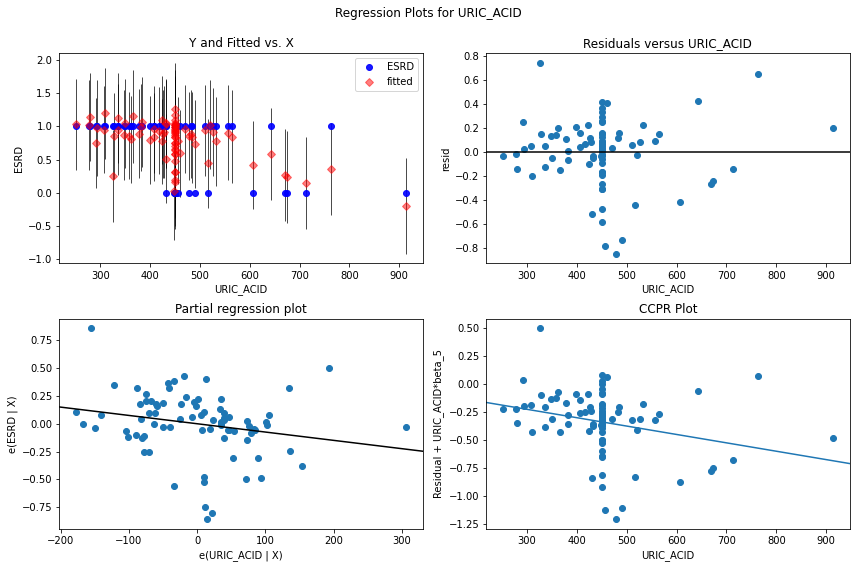

In [359]:
#define figure size
fig = plt.figure(figsize=(12,8))

#produce regression plots
fig = sm.graphics.plot_regress_exog(model, 'URIC_ACID', fig=fig)

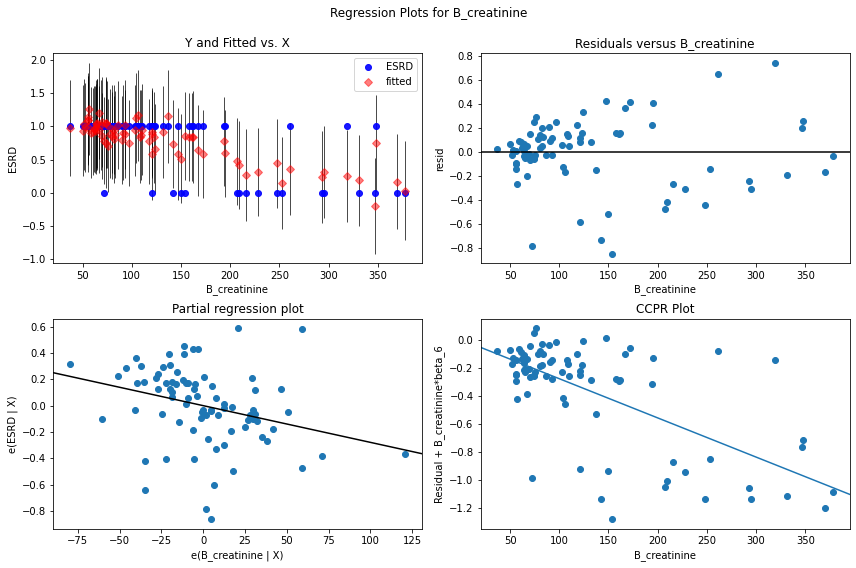

In [360]:
#define figure size
fig = plt.figure(figsize=(12,8))

#produce regression plots
fig = sm.graphics.plot_regress_exog(model, 'B_creatinine', fig=fig)

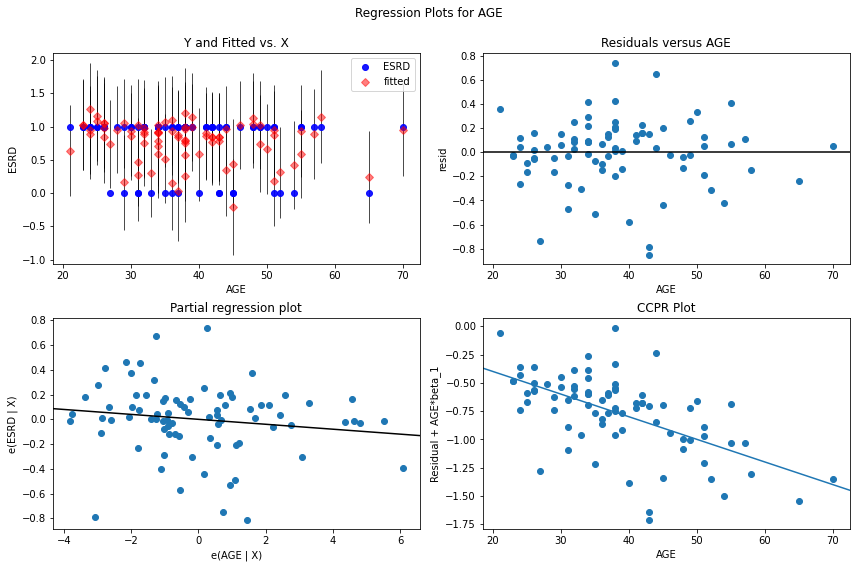

In [361]:
#define figure size
fig = plt.figure(figsize=(12,8))

#produce regression plots
fig = sm.graphics.plot_regress_exog(model, 'AGE', fig=fig)

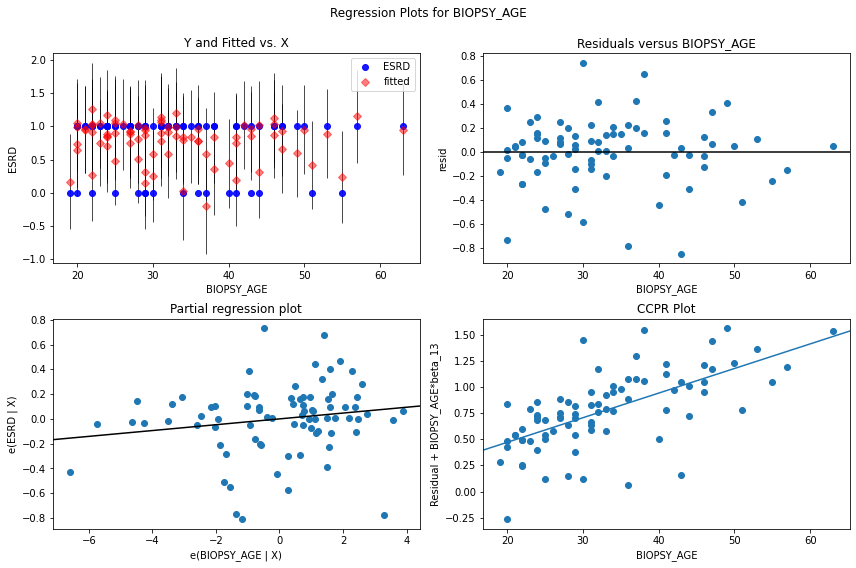

In [362]:
#define figure size
fig = plt.figure(figsize=(12,8))

#produce regression plots
fig = sm.graphics.plot_regress_exog(model, 'BIOPSY_AGE', fig=fig)

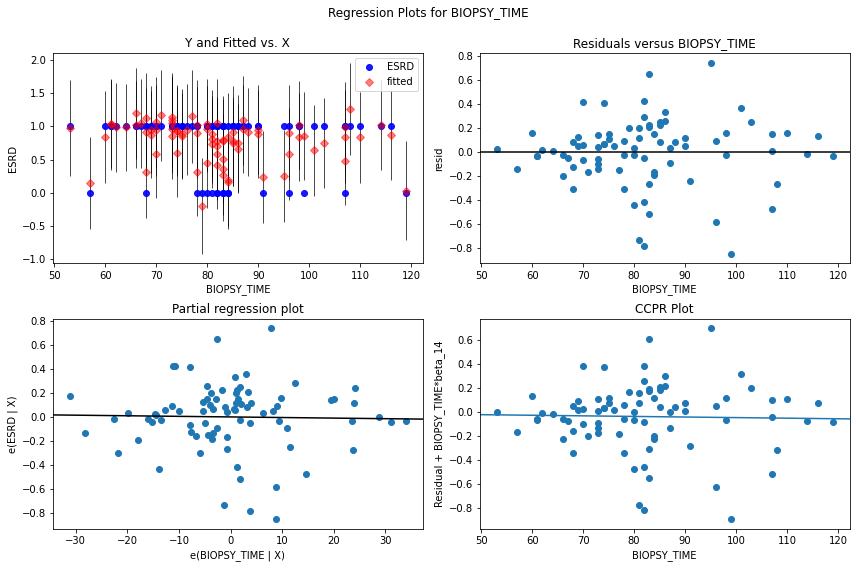

In [363]:
#define figure size
fig = plt.figure(figsize=(12,8))

#produce regression plots
fig = sm.graphics.plot_regress_exog(model, 'BIOPSY_TIME', fig=fig)

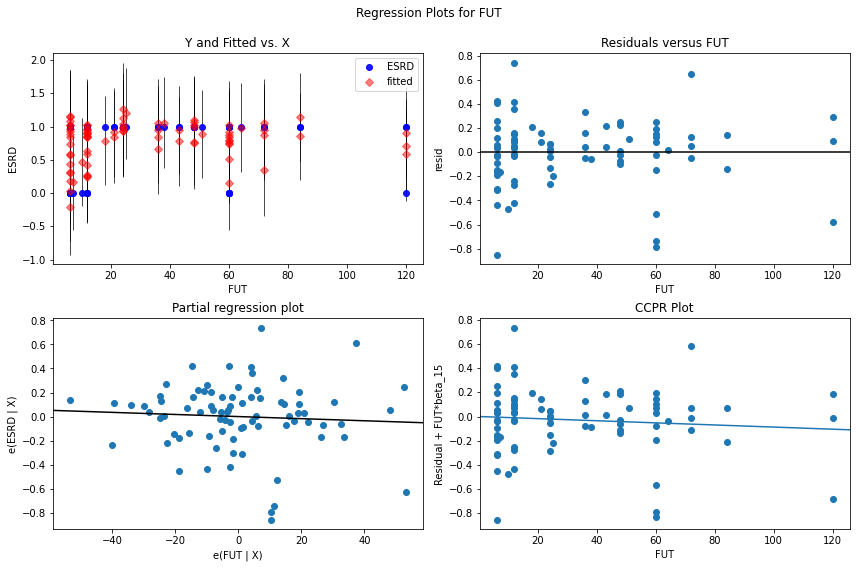

In [364]:
#define figure size
fig = plt.figure(figsize=(12,8))

#produce regression plots
fig = sm.graphics.plot_regress_exog(model, 'FUT', fig=fig)

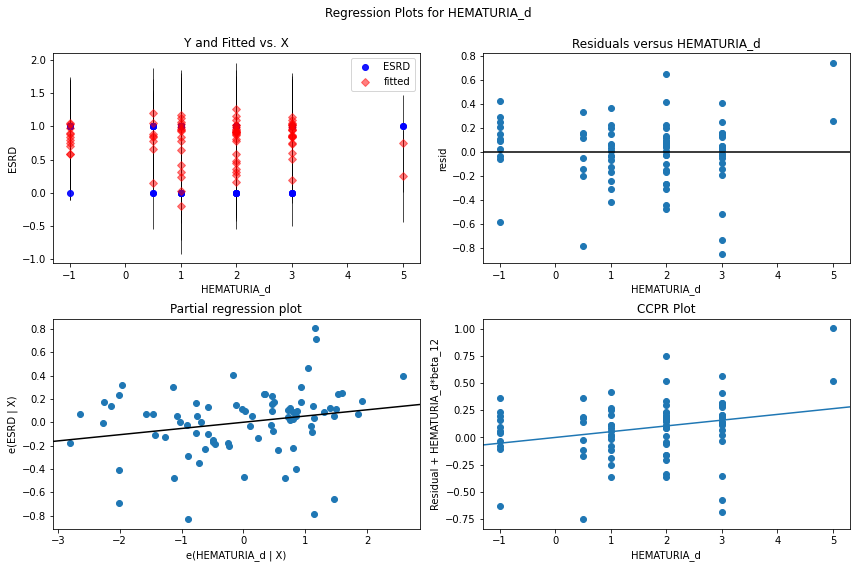

In [365]:
#define figure size
fig = plt.figure(figsize=(12,8))

#produce regression plots
fig = sm.graphics.plot_regress_exog(model, 'HEMATURIA_d', fig=fig)

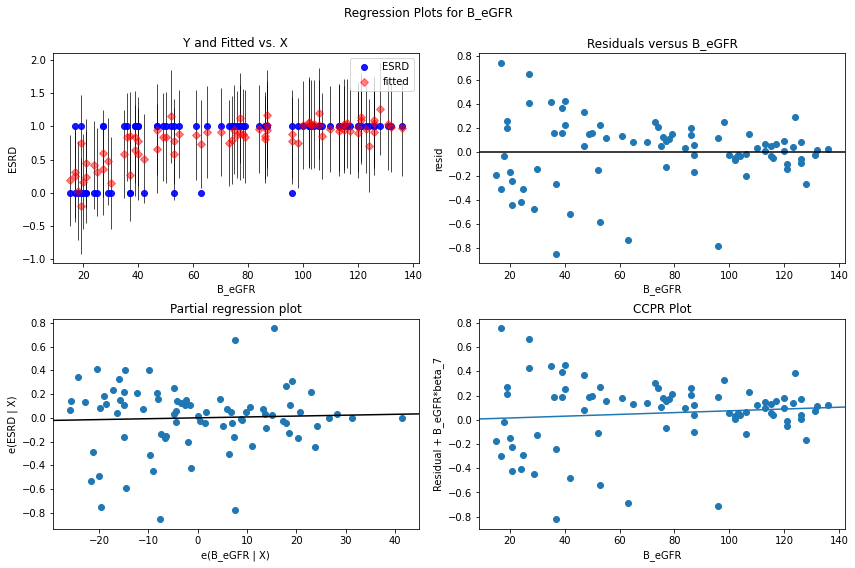

In [366]:
#define figure size
fig = plt.figure(figsize=(12,8))

#produce regression plots
fig = sm.graphics.plot_regress_exog(model, 'B_eGFR', fig=fig)

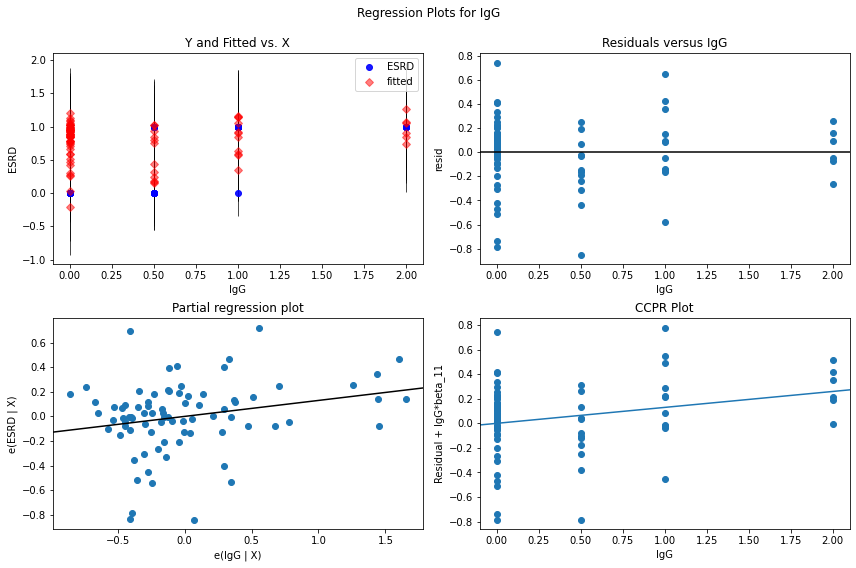

In [367]:
#define figure size
fig = plt.figure(figsize=(12,8))

#produce regression plots
fig = sm.graphics.plot_regress_exog(model, 'IgG', fig=fig)

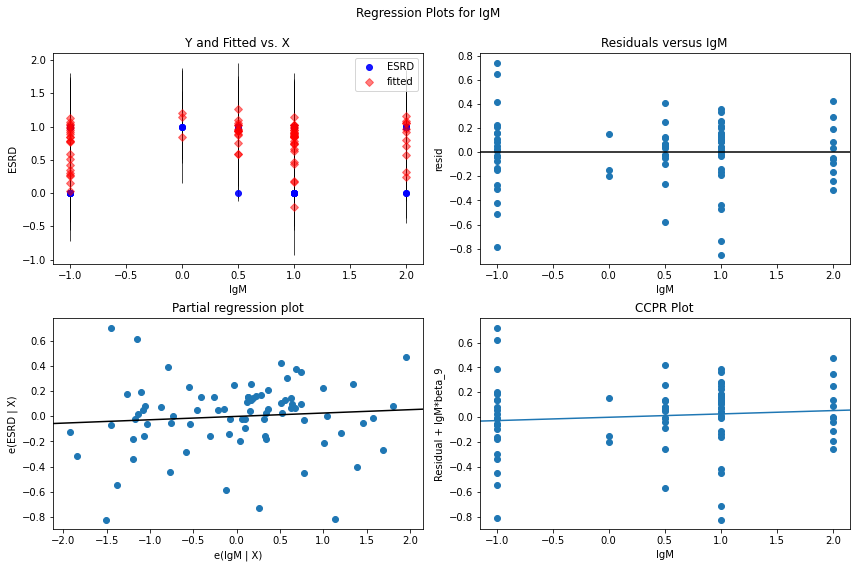

In [368]:
#define figure size
fig = plt.figure(figsize=(12,8))

#produce regression plots
fig = sm.graphics.plot_regress_exog(model, 'IgM', fig=fig)

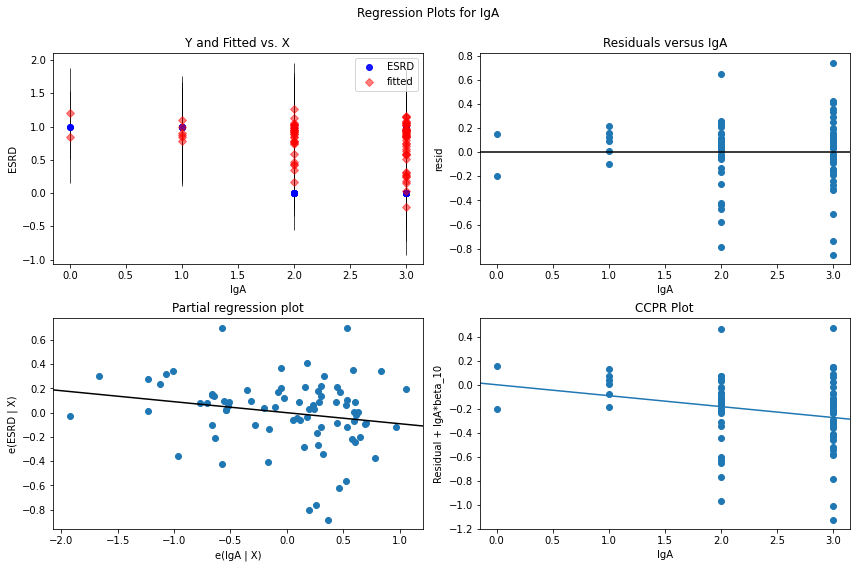

In [369]:
#define figure size
fig = plt.figure(figsize=(12,8))

#produce regression plots
fig = sm.graphics.plot_regress_exog(model, 'IgA', fig=fig)

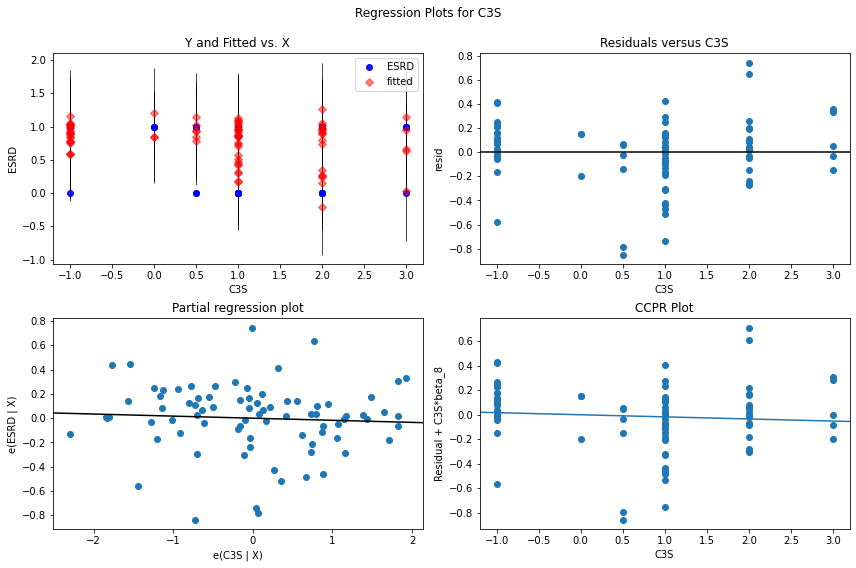

In [370]:
#define figure size
fig = plt.figure(figsize=(12,8))

#produce regression plots
fig = sm.graphics.plot_regress_exog(model, 'C3S', fig=fig)

The x-axis of the above plots (top right) shows the actual values for the predictor variabls  points and the y-axis shows the residual for those values.
Since the residuals appear to be randomly scattered around zero, this is an indication that heteroscedasticity is not a problem with any of the predictor variables here.





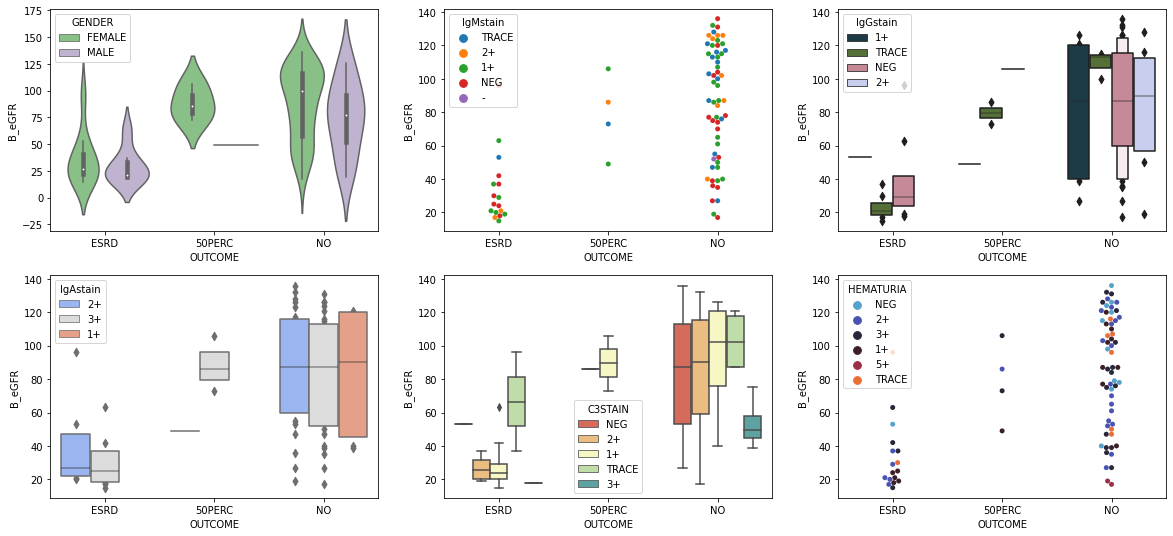

In [371]:
fig, axs = plt.subplots(2,3,figsize=(20,9))

sns.violinplot(y="B_eGFR", x="OUTCOME", hue = 'GENDER', data=df1, palette = 'Accent', ax=axs[0,0])
sns.swarmplot(y="B_eGFR", x="OUTCOME", data=df1, hue = 'IgMstain', ax=axs[0,1])

sns.boxenplot(x="OUTCOME", y="B_eGFR", hue = 'IgGstain',  palette = 'cubehelix', data=df1, ax=axs[0,-1])
sns.boxenplot(x="OUTCOME", y="B_eGFR", data=df1, hue="IgAstain",  palette = 'coolwarm', ax=axs[1,0])


sns.boxplot(x="OUTCOME", y="B_eGFR", hue = 'C3STAIN', data=df1,  palette = 'Spectral', ax=axs[1,1])
sns.swarmplot(x="OUTCOME", y="B_eGFR", data=df1, hue ="HEMATURIA",  palette = 'icefire', ax=axs[1,2])

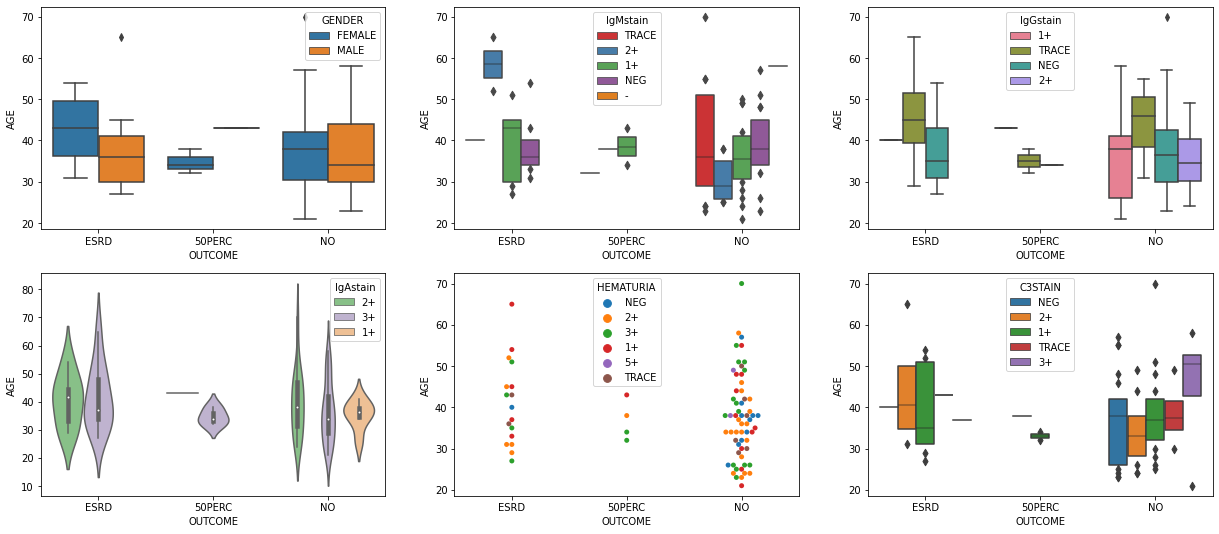

In [372]:
fig, axs = plt.subplots(2,3,figsize=(21,9))

sns.boxplot(y="AGE", x="OUTCOME", hue = 'GENDER', data=df1, ax=axs[0,0])
sns.boxenplot(y="AGE", x="OUTCOME", data=df1, hue = 'IgMstain', palette='Set1', ax=axs[0,1])

sns.boxplot(x="OUTCOME", y="AGE", hue = 'IgGstain', data=df1, palette= 'husl', ax=axs[0,-1])
sns.violinplot(x="OUTCOME", y="AGE", data=df1, hue="IgAstain", palette = "Accent", ax=axs[1,0])


sns.boxenplot(x="OUTCOME", y="AGE", hue = 'C3STAIN', data=df1, ax=axs[1,2])
sns.swarmplot(x="OUTCOME", y="AGE", data=df1, hue ="HEMATURIA", ax=axs[1,1])

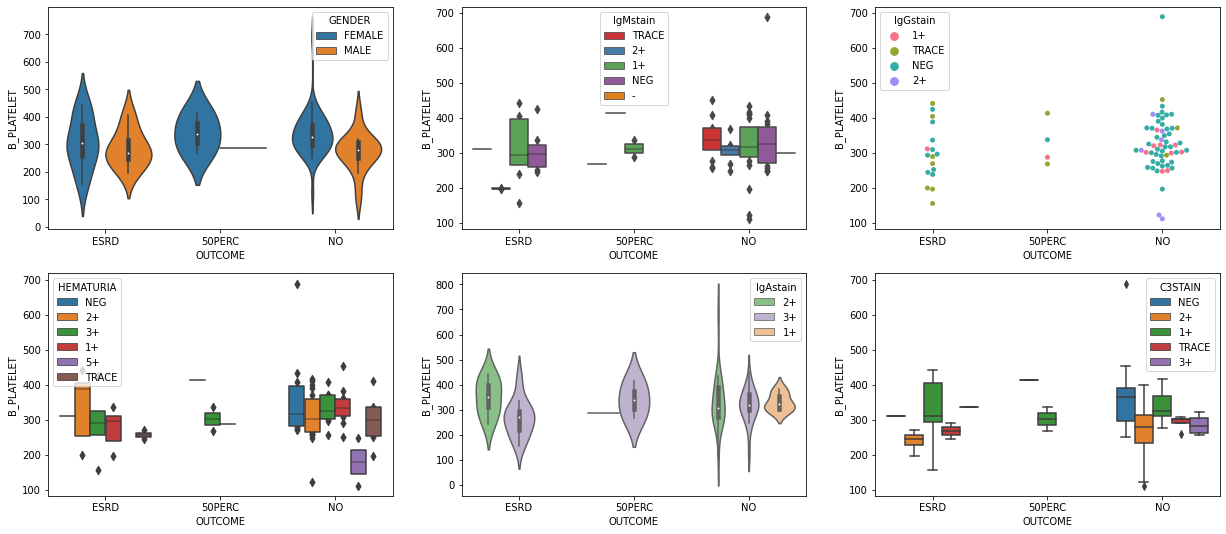

In [373]:
fig, axs = plt.subplots(2,3,figsize=(21,9))

sns.violinplot(y="B_PLATELET", x="OUTCOME", hue = 'GENDER', data=df1, ax=axs[0,0])
sns.boxenplot(y="B_PLATELET", x="OUTCOME", data=df1, hue = 'IgMstain', palette='Set1', ax=axs[0,1])

sns.swarmplot(x="OUTCOME", y="B_PLATELET", hue = 'IgGstain', data=df1, palette= 'husl', ax=axs[0,-1])
sns.violinplot(x="OUTCOME", y="B_PLATELET", data=df1, hue="IgAstain", palette = "Accent", ax=axs[1,1])


sns.boxplot(x="OUTCOME", y="B_PLATELET", hue = 'C3STAIN', data=df1, ax=axs[1,2])
sns.boxenplot(x="OUTCOME", y="B_PLATELET", data=df1, hue ="HEMATURIA", ax=axs[1,0])

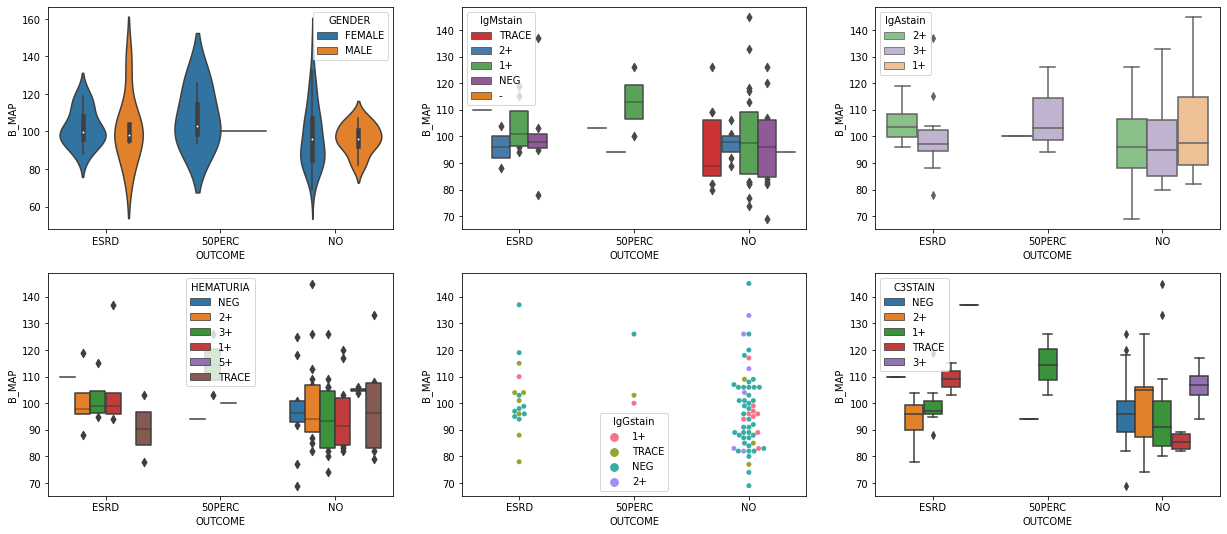

In [374]:
fig, axs = plt.subplots(2,3,figsize=(21,9))

sns.violinplot(y="B_MAP", x="OUTCOME", hue = 'GENDER', data=df1, ax=axs[0,0])
sns.boxenplot(y="B_MAP", x="OUTCOME", data=df1, hue = 'IgMstain', palette='Set1', ax=axs[0,1])

sns.swarmplot(x="OUTCOME", y="B_MAP", hue = 'IgGstain', data=df1, palette= 'husl', ax=axs[1,1])
sns.boxplot(x="OUTCOME", y="B_MAP", data=df1, hue="IgAstain", palette = "Accent", ax=axs[0,-1])


sns.boxplot(x="OUTCOME", y="B_MAP", hue = 'C3STAIN', data=df1, ax=axs[1,2])
sns.boxenplot(x="OUTCOME", y="B_MAP", data=df1, hue ="HEMATURIA", ax=axs[1,0])

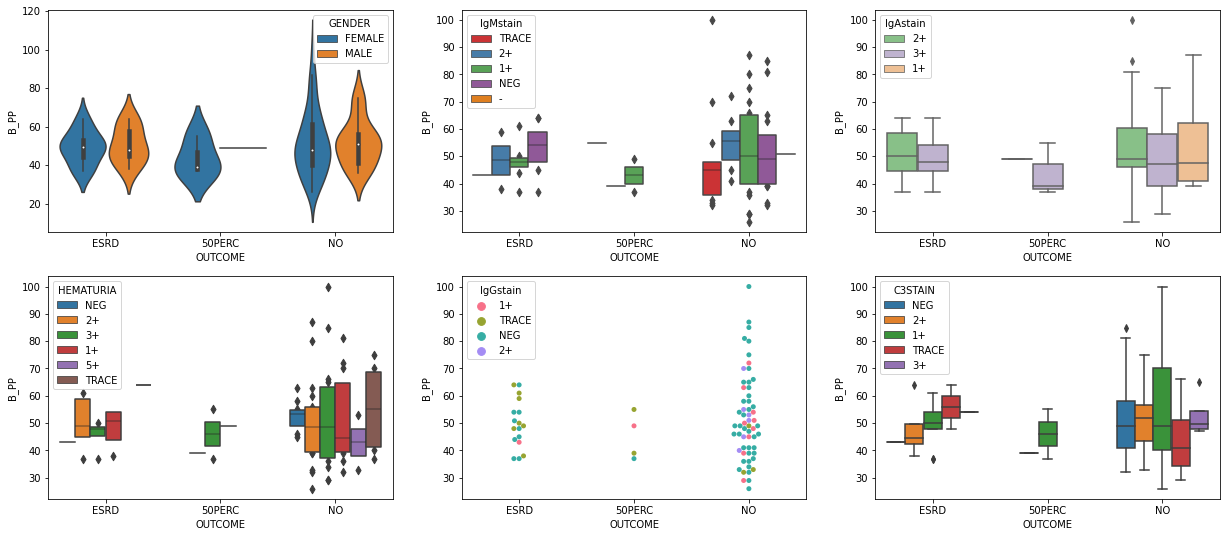

In [375]:
fig, axs = plt.subplots(2,3,figsize=(21,9))

sns.violinplot(y="B_PP", x="OUTCOME", hue = 'GENDER', data=df1, ax=axs[0,0])
sns.boxenplot(y="B_PP", x="OUTCOME", data=df1, hue = 'IgMstain', palette='Set1', ax=axs[0,1])

sns.swarmplot(x="OUTCOME", y="B_PP", hue = 'IgGstain', data=df1, palette= 'husl', ax=axs[1,1])
sns.boxplot(x="OUTCOME", y="B_PP", data=df1, hue="IgAstain", palette = "Accent", ax=axs[0,-1])


sns.boxplot(x="OUTCOME", y="B_PP", hue = 'C3STAIN', data=df1, ax=axs[1,2])
sns.boxenplot(x="OUTCOME", y="B_PP", data=df1, hue ="HEMATURIA", ax=axs[1,0])

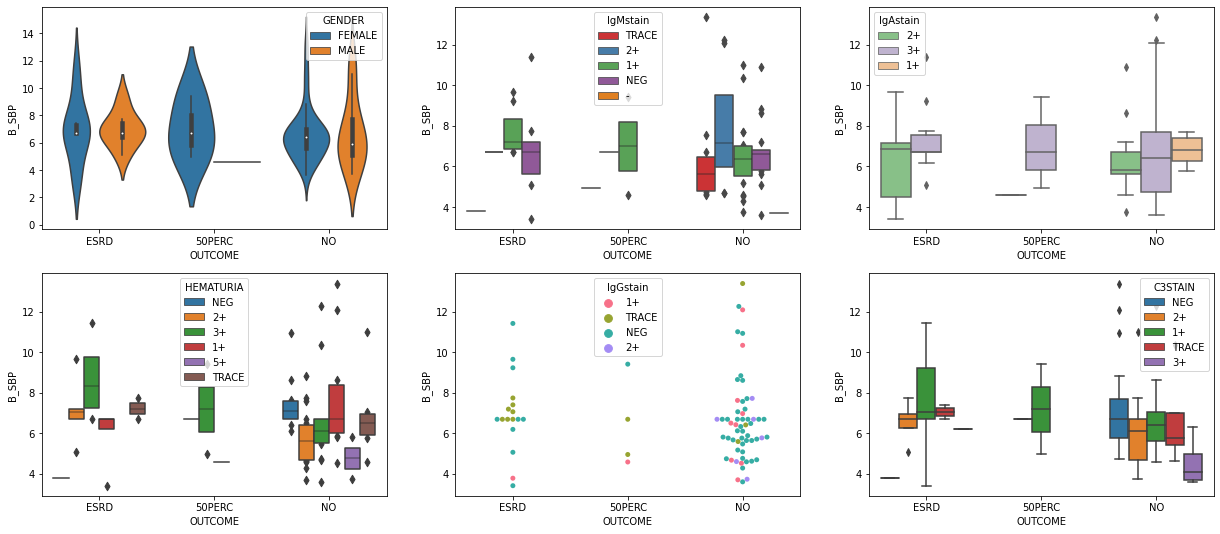

In [376]:
fig, axs = plt.subplots(2,3,figsize=(21,9))

sns.violinplot(y="B_SBP", x="OUTCOME", hue = 'GENDER', data=df1, ax=axs[0,0])
sns.boxenplot(y="B_SBP", x="OUTCOME", data=df1, hue = 'IgMstain', palette='Set1', ax=axs[0,1])

sns.swarmplot(x="OUTCOME", y="B_SBP", hue = 'IgGstain', data=df1, palette= 'husl', ax=axs[1,1])
sns.boxplot(x="OUTCOME", y="B_SBP", data=df1, hue="IgAstain", palette = "Accent", ax=axs[0,-1])


sns.boxplot(x="OUTCOME", y="B_SBP", hue = 'C3STAIN', data=df1, ax=axs[1,2])
sns.boxenplot(x="OUTCOME", y="B_SBP", data=df1, hue ="HEMATURIA", ax=axs[1,0])

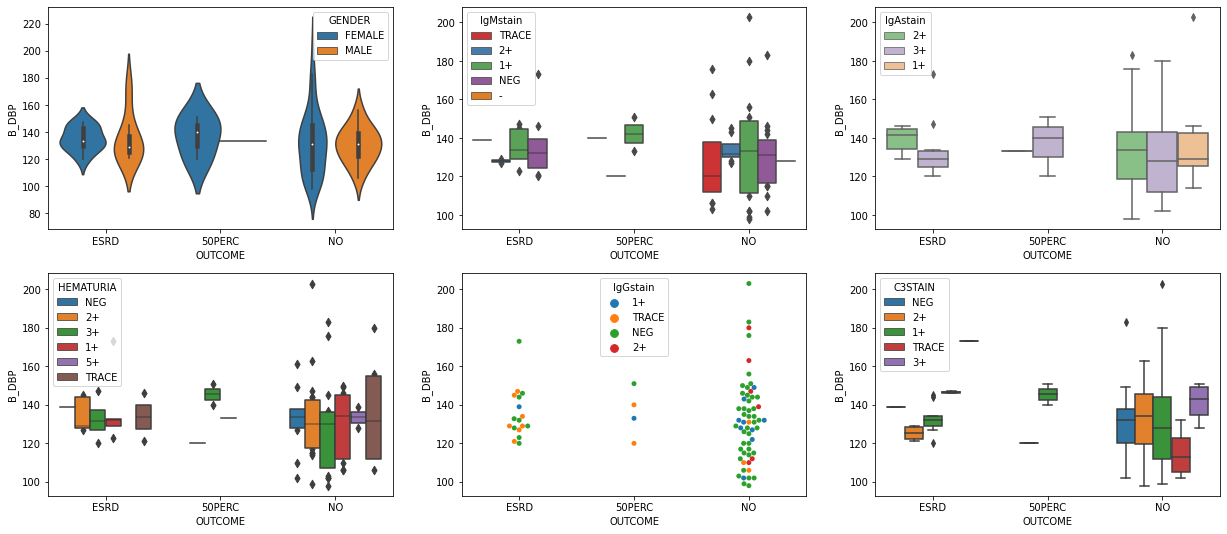

In [377]:
fig, axs = plt.subplots(2,3,figsize=(21,9))

sns.violinplot(y="B_DBP", x="OUTCOME", hue = 'GENDER', data=df1, ax=axs[0,0])
sns.boxenplot(y="B_DBP", x="OUTCOME", data=df1, hue = 'IgMstain', palette='Set1', ax=axs[0,1])

sns.swarmplot(x="OUTCOME", y="B_DBP", hue = 'IgGstain', data=df1, ax=axs[1,1])
sns.boxplot(x="OUTCOME", y="B_DBP", data=df1, hue="IgAstain", palette = "Accent", ax=axs[0,-1])


sns.boxplot(x="OUTCOME", y="B_DBP", hue = 'C3STAIN', data=df1, ax=axs[1,2])
sns.boxenplot(x="OUTCOME", y="B_DBP", data=df1, hue ="HEMATURIA", ax=axs[1,0])

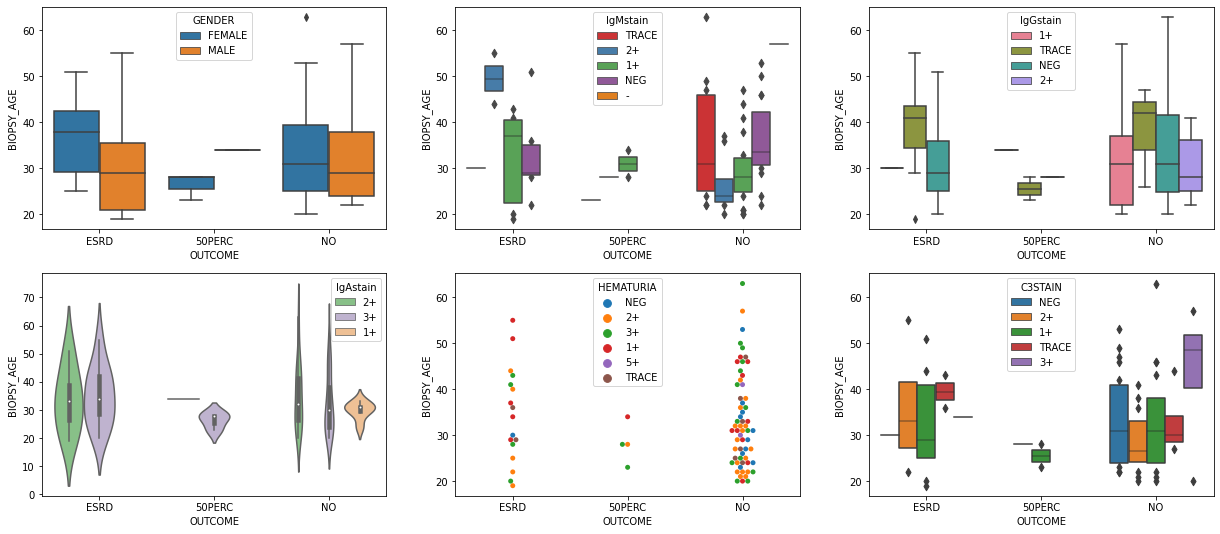

In [378]:
fig, axs = plt.subplots(2,3,figsize=(21,9))

sns.boxplot(y="BIOPSY_AGE", x="OUTCOME", hue = 'GENDER', data=df1, ax=axs[0,0])
sns.boxenplot(y="BIOPSY_AGE", x="OUTCOME", data=df1, hue = 'IgMstain', palette='Set1', ax=axs[0,1])

sns.boxplot(x="OUTCOME", y="BIOPSY_AGE", hue = 'IgGstain', data=df1, palette= 'husl', ax=axs[0,-1])
sns.violinplot(x="OUTCOME", y="BIOPSY_AGE", data=df1, hue="IgAstain", palette = "Accent", ax=axs[1,0])


sns.boxenplot(x="OUTCOME", y="BIOPSY_AGE", hue = 'C3STAIN', data=df1, ax=axs[1,2])
sns.swarmplot(x="OUTCOME", y="BIOPSY_AGE", data=df1, hue ="HEMATURIA", ax=axs[1,1])

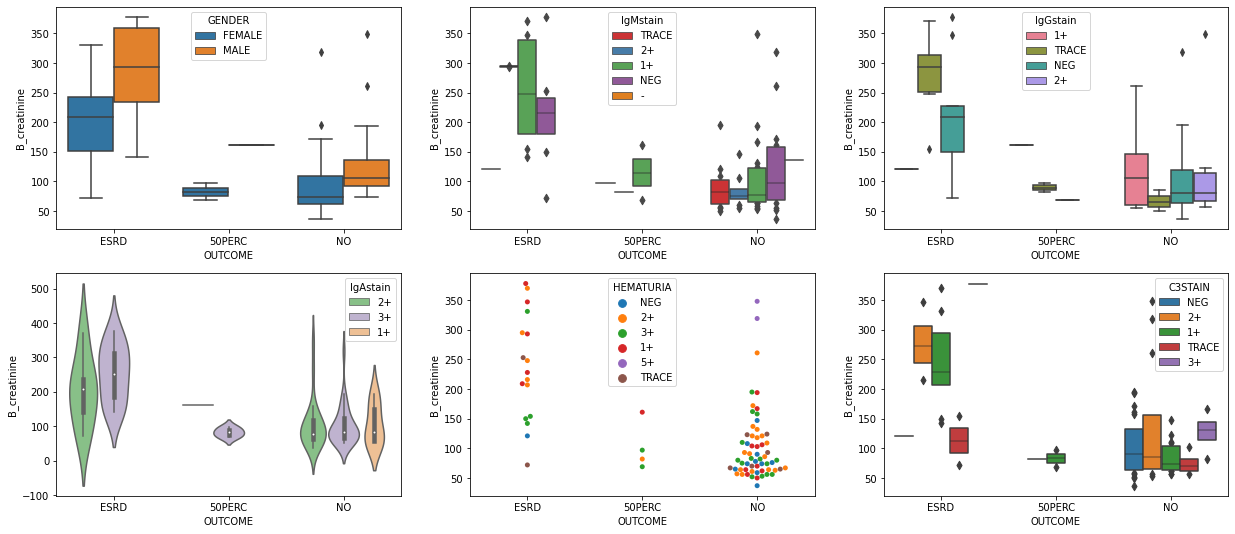

In [379]:
fig, axs = plt.subplots(2,3,figsize=(21,9))

sns.boxplot(y="B_creatinine", x="OUTCOME", hue = 'GENDER', data=df1, ax=axs[0,0])
sns.boxenplot(y="B_creatinine", x="OUTCOME", data=df1, hue = 'IgMstain', palette='Set1', ax=axs[0,1])

sns.boxplot(x="OUTCOME", y="B_creatinine", hue = 'IgGstain', data=df1, palette= 'husl', ax=axs[0,-1])
sns.violinplot(x="OUTCOME", y="B_creatinine", data=df1, hue="IgAstain", palette = "Accent", ax=axs[1,0])


sns.boxenplot(x="OUTCOME", y="B_creatinine", hue = 'C3STAIN', data=df1, ax=axs[1,2])
sns.swarmplot(x="OUTCOME", y="B_creatinine", data=df1, hue ="HEMATURIA", ax=axs[1,1])

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


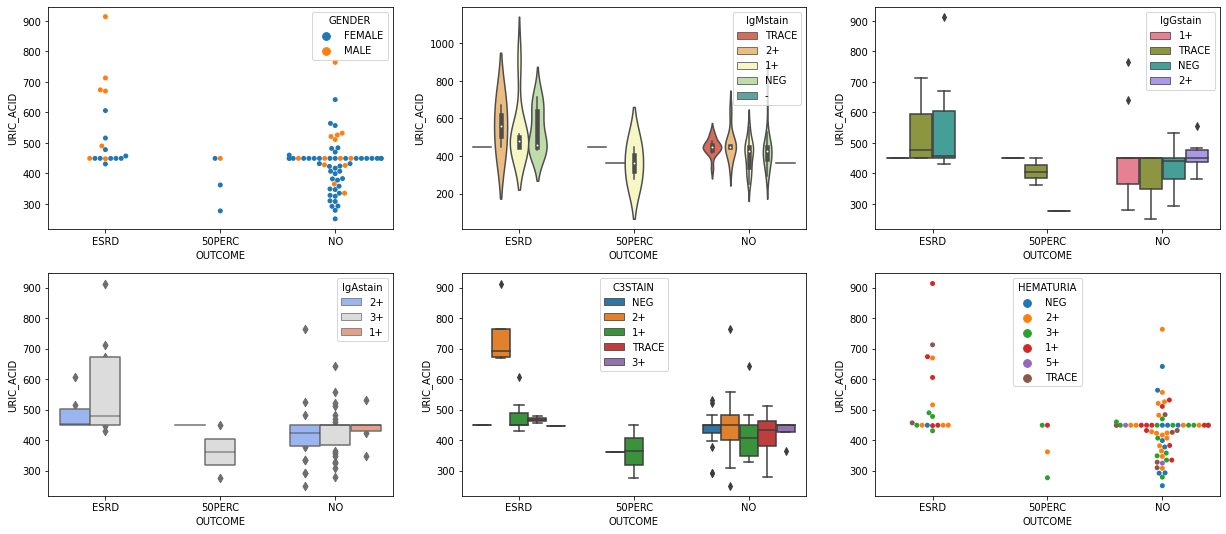

In [380]:
fig, axs = plt.subplots(2,3,figsize=(21,9))

sns.swarmplot(y="URIC_ACID", x="OUTCOME", hue = 'GENDER', data=df1, ax=axs[0,0])
sns.violinplot(y="URIC_ACID", x="OUTCOME", data=df1, hue = 'IgMstain', palette='Spectral', ax=axs[0,1])

sns.boxplot(x="OUTCOME", y="URIC_ACID", hue = 'IgGstain', data=df1, palette= 'husl', ax=axs[0,-1])
sns.boxenplot(x="OUTCOME", y="URIC_ACID", data=df1, hue="IgAstain", palette = "coolwarm", ax=axs[1,0])


sns.boxplot(x="OUTCOME", y="URIC_ACID", hue = 'C3STAIN', data=df1, ax=axs[1,1])
sns.swarmplot(x="OUTCOME", y="URIC_ACID", data=df1, hue ="HEMATURIA", ax=axs[1,2])

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 6.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


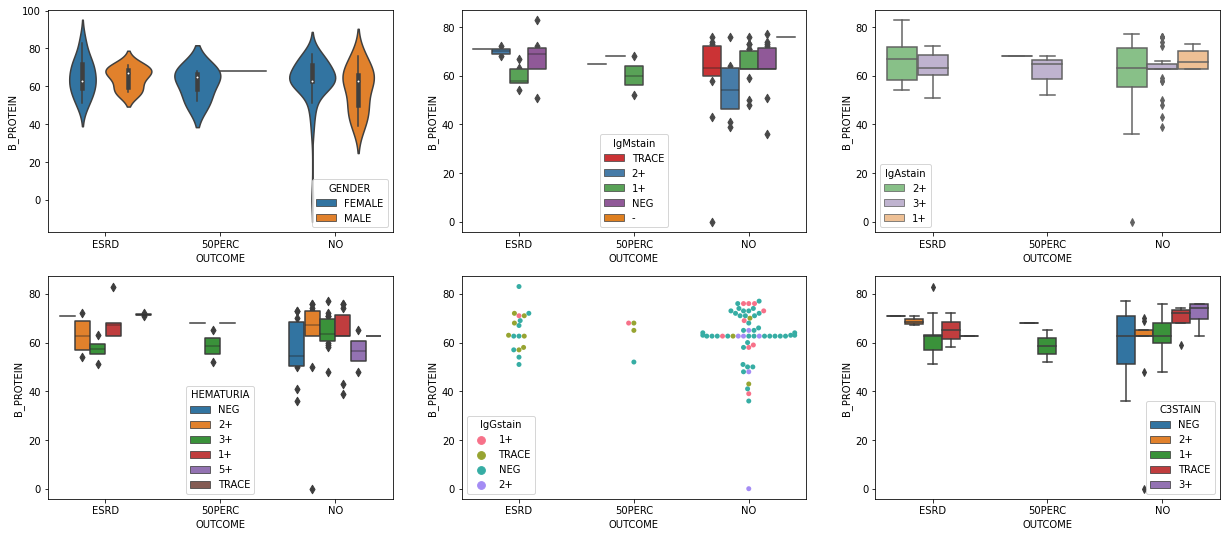

In [381]:
fig, axs = plt.subplots(2,3,figsize=(21,9))

sns.violinplot(y="B_PROTEIN", x="OUTCOME", hue = 'GENDER', data=df1, ax=axs[0,0])
sns.boxenplot(y="B_PROTEIN", x="OUTCOME", data=df1, hue = 'IgMstain', palette='Set1', ax=axs[0,1])

sns.swarmplot(x="OUTCOME", y="B_PROTEIN", hue = 'IgGstain', data=df1, palette= 'husl', ax=axs[1,1])
sns.boxplot(x="OUTCOME", y="B_PROTEIN", data=df1, hue="IgAstain", palette = "Accent", ax=axs[0,-1])


sns.boxplot(x="OUTCOME", y="B_PROTEIN", hue = 'C3STAIN', data=df1, ax=axs[1,2])
sns.boxenplot(x="OUTCOME", y="B_PROTEIN", data=df1, hue ="HEMATURIA", ax=axs[1,0])

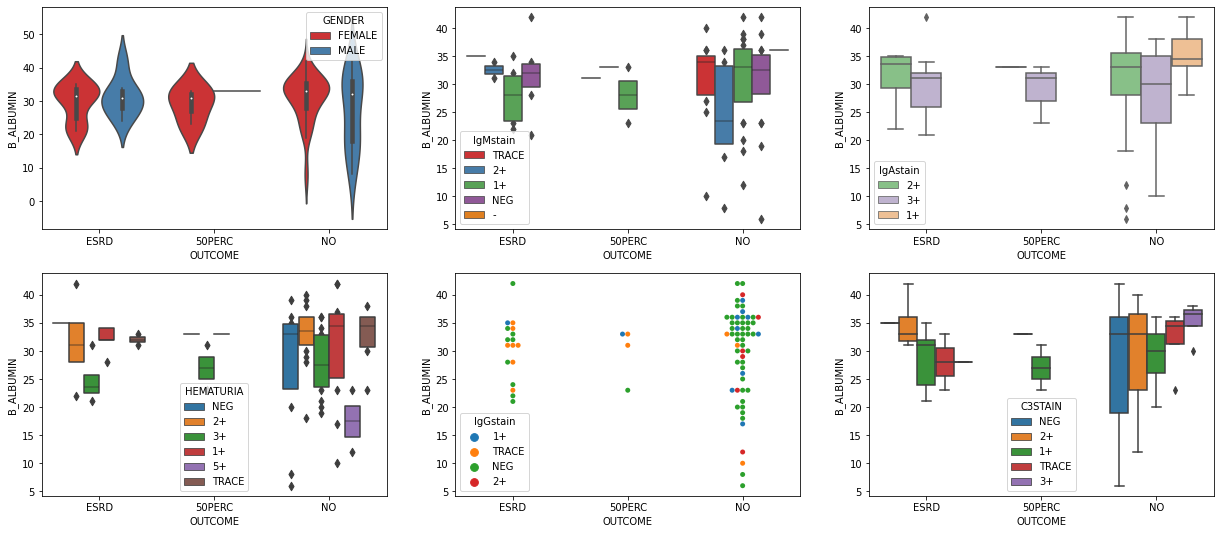

In [382]:
fig, axs = plt.subplots(2,3,figsize=(21,9))

sns.violinplot(y="B_ALBUMIN", x="OUTCOME", hue = 'GENDER', palette = 'Set1', data=df1, ax=axs[0,0])
sns.boxenplot(y="B_ALBUMIN", x="OUTCOME", data=df1, hue = 'IgMstain', palette='Set1', ax=axs[0,1])

sns.swarmplot(x="OUTCOME", y="B_ALBUMIN", hue = 'IgGstain', data=df1, ax=axs[1,1])
sns.boxplot(x="OUTCOME", y="B_ALBUMIN", data=df1, hue="IgAstain", palette = "Accent", ax=axs[0,-1])


sns.boxplot(x="OUTCOME", y="B_ALBUMIN", hue = 'C3STAIN', data=df1, ax=axs[1,2])
sns.boxenplot(x="OUTCOME", y="B_ALBUMIN", data=df1, hue ="HEMATURIA", ax=axs[1,0])

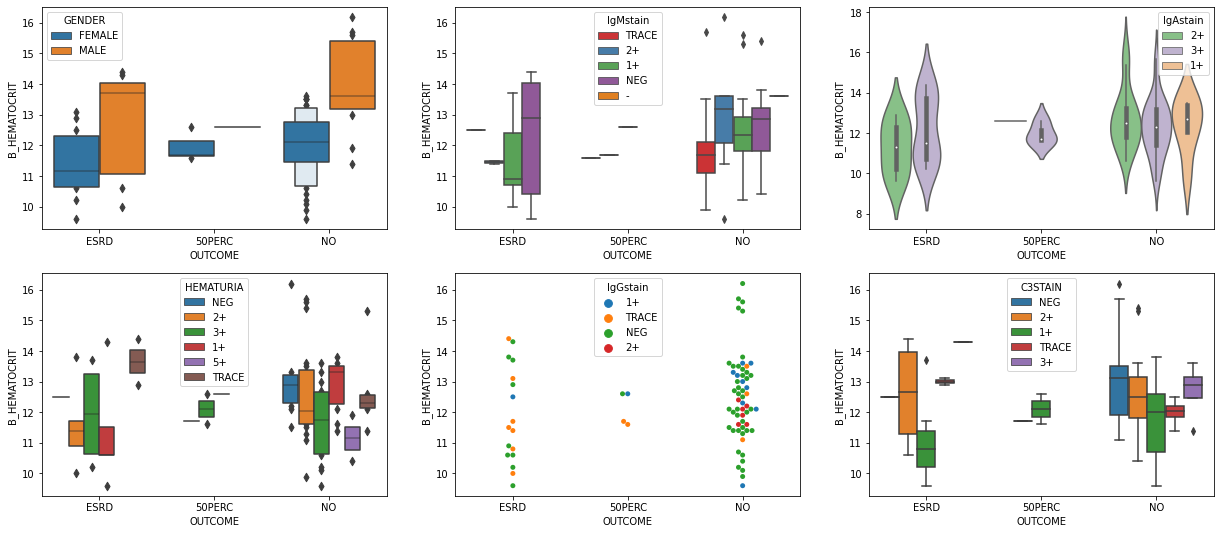

In [383]:
fig, axs = plt.subplots(2,3,figsize=(21,9))

sns.boxenplot(y="B_HEMATOCRIT", x="OUTCOME", hue = 'GENDER', data=df1, ax=axs[0,0])
sns.boxplot(y="B_HEMATOCRIT", x="OUTCOME", data=df1, hue = 'IgMstain', palette='Set1', ax=axs[0,1])

sns.swarmplot(x="OUTCOME", y="B_HEMATOCRIT", hue = 'IgGstain', data=df1, ax=axs[1,1])
sns.violinplot(x="OUTCOME", y="B_HEMATOCRIT", data=df1, hue="IgAstain", palette = "Accent", ax=axs[0,-1])


sns.boxplot(x="OUTCOME", y="B_HEMATOCRIT", hue = 'C3STAIN', data=df1, ax=axs[1,2])
sns.boxenplot(x="OUTCOME", y="B_HEMATOCRIT", data=df1, hue ="HEMATURIA", ax=axs[1,0])

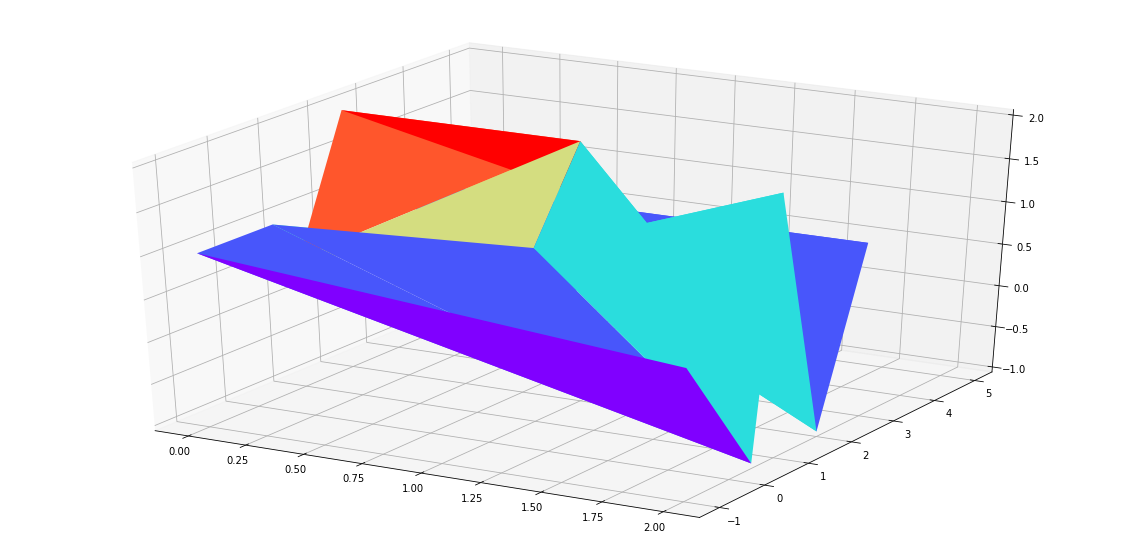

In [393]:
plt.figure(figsize=(20,10))

# all three axes
x = OUTCOME.OUTCOME_d
y = OUTCOME.HEMATURIA_d
z = OUTCOME.IgM
  
ax = plt.axes(projection ='3d')
ax.plot_trisurf(x, y, z, cmap ='rainbow', linewidths = 0.2);

Text(0.5, 0.92, '3D line plot')

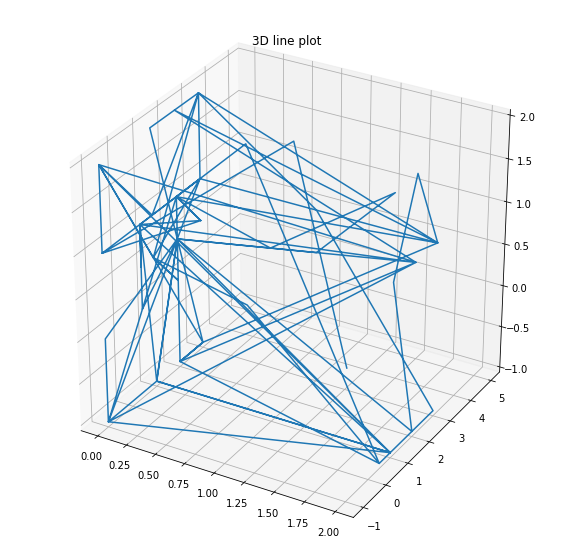

In [394]:
plt.figure(figsize=(10,10))

# all three axes
x = OUTCOME.OUTCOME_d
y = OUTCOME.HEMATURIA_d
z = OUTCOME.IgM

ax = plt.axes(projection ='3d')

ax.plot3D(x, y, z)
ax.set_title('3D line plot')

Text(0.5, 0.92, '3d Scatter plot')

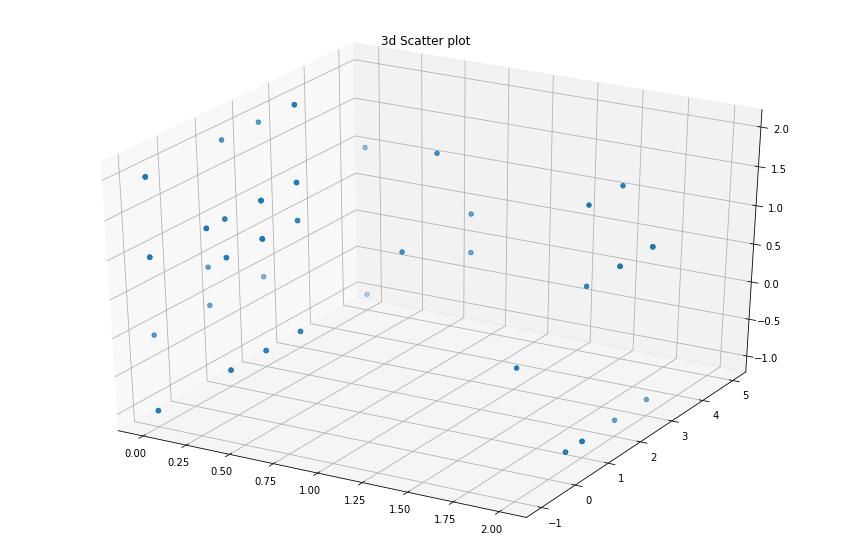

In [395]:
plt.figure(figsize=(15,10))
ax = plt.axes(projection ='3d')
 
ax.scatter(x, y, z)
 
# syntax for plotting
ax.set_title('3d Scatter plot')

In [396]:
# Build Random forest model
# 1. splitting the dataset into test and train
y= ESRD['ESRD']
ESRD.drop('ESRD',axis=1,inplace=True)
X_train,X_test,y_train,y_test=train_test_split(ESRD,y)

# 2. creating the model
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
model = RandomForestClassifier(n_estimators = 150, 
                               random_state = 101)

# 3. fitting the model
model.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


RandomForestClassifier(n_estimators=150, random_state=101)

In [397]:

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None, criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=100, verbose=0, warm_start=False)

RandomForestClassifier(n_estimators=80, random_state=100)

In [398]:
!pip install treeinterpreter # for installing the first time
from treeinterpreter import treeinterpreter as ti
rownames = X_test.values[None,1]
prediction, bias, contributions = ti.predict(model, rownames)
contributions = [contributions[0][i][0] for i in range(len(contributions[0]))]
colnames = X_test.columns[0:].values

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for waterfallcharts: filename=waterfallcharts-3.8-py3-none-any.whl size=3413 sha256=b11280d084b02a49593212ab673e2fa2456789218769f2130ede4850cbe7c791
  Stored in directory: /root/.cache/pip/wheels/4a/b2/85/9b6eda27fab2effa580c6942fb094e8536cc46e8741ec5f586
Successfully built waterfallcharts


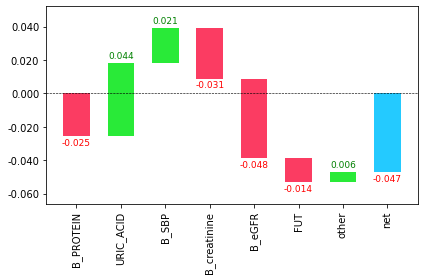

In [399]:

!pip install waterfallcharts
import waterfall_chart
my_plot=waterfall_chart.plot(colnames, contributions, rotation_value=90, threshold=0.3,formatting='{:,.3f}')